# Speaker-Independent Spoken Digit Recognition (xSDR)


One of the successful stories of deep neural networks is the proliferation of commercial of automatic speech recognition (ASR) systems. This project aims to explore one application of ML-powered ASR to the problem of spoken digit recognition (SDR). Since digits are widely used as unique identifiers for bank information, social security numbers, post codes, etc, SDR systems can be an efficient alternative to fully-fledged ASR systems since the domain is more predictable than other applications of ASR. 

In this project, we focus on developing a SDR system in a speaker-independent setting. That is, the speakers in the evaluation set are disjoint from the training set speakers. We do so because we expect real-world ASR systems to generalize to different speakers than those we have data for. Moreover, for many languages that are under-resourced, we have have (limited) annotated speech data from a single speaker, but we would still want the system to be deployed to work on any speaker of that language. We tackle the problem of spoken digit recognition as a sequence classification task. Concretely, the inputs are short audio clips of a specific digit (in the range 0-9), then the goal is to build deep neural network models to classify a short audio clip and predict the digit that was spoken.

# Notes

## Code Submission

You don't necessarily need to complete the code in this Jupyter Notebook, you are free to use another notebook or a python script file, as you would like. You are expected to submit the code by **22.03.2023**.

Your code should be clean and well commented. We also expect that if we decide to run it on our system, it should be straighforward to do so. We recommend creating a ```requirements.txt``` file with the names of all the libraries with their versions. If applicable, please mention the python version in a ```README.md``` file, which should also include instructions on how to run your code.

As mentioned for the assignments, always remember to cite the code with the links as comments, if you decide to use it from a public repository.

## Report Submission

With the code, you are also expected to submit a report with a maximum of 4 pages. You should write your report in LaTeX using this template for ACL 2023 [Overleaf Link](https://www.overleaf.com/latex/templates/acl-2023-proceedings-template/qjdgcrdwcnwp). Use this document to fill in any missing information that are not necessarily covered during your presentation for the sake of time in the presentation. While writing your report, we would highly encourgae you to cite the papers behind each tool / library / function that you might use for your experiments. We have also released an example on how to write equations in LaTeX [here](https://piazza.com/class/l9so16qqvk34hu/post/52).

You art also expected to submit this report with your code. You should provide the **.tex, .pdf and all image files** zipped with the same naming convention as it was in your assignment(s).

## Presentation

During the last week of March 2023, i.e. 27.03 -- 31.03, each team will be presenting their works for 15 minutes. We expect equal contribution from each member in delivery and content of the presentation. So roughly 5 minutes for one person, if you have 3 people in your team. There will be 5 minutes for some Q&A. At-least one person from your team should be present to do an in-person presentation, rest of your team could join remotely, if they are not present.

## Important Dates

 - Code & Report Submission: 22.03.2023 (08.00)
 - Presentation: 27.03.2023 -- 31.03.2023
 
 You'll get a precise date and time for your team's presentation at a later time.

### Grading

In this project, your final grades will be determined as follows:

 - **30%**: &emsp; Completing all the tasks
 - **30%**: &emsp; Providing scientific-backings for all the methods used
 - **20%**: &emsp; Quality of the content of the presentation
 - **20%**: &emsp; Delivery of the presentation

In [81]:
#%matplotlib inline
import numpy as np
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import torch
import pandas as pd

from sklearn  import preprocessing


from collections import defaultdict, Counter

# add this to ignore warnings from Librosa
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import random

In [2]:
# for linear models 
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE as tsne

In [3]:
from sklearn.neural_network import MLPClassifier

In [4]:
torch.cuda.is_available()
device = torch.device("cuda")

## Exploring the Dataset 

The speech samples are already divied into training, development, and test spilts. The splits are made in such way that evaluation speakers are not present in training split. You should use the splits as they are. 

**CAUTION:** 

In this project, you are not allowed to use any external data for this problem (at least for the main three tasks). Exploring the effect of additional datasets in this project can only included as a further step after completing the main requirements with the given data. 

In [5]:
# read tsv file into a dataframe 
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')

In [6]:
sdr_df.head(100)

,identifier,speaker,split,label,file
0,5_theo_23,theo,TRAIN,5,speech_data/5_theo_23.wav
1,2_yweweler_39,yweweler,TEST,2,speech_data/2_yweweler_39.wav
2,6_yweweler_34,yweweler,DEV,6,speech_data/6_yweweler_34.wav
3,6_yweweler_16,yweweler,DEV,6,speech_data/6_yweweler_16.wav
4,9_yweweler_2,yweweler,TEST,9,speech_data/9_yweweler_2.wav
...,...,...,...,...,...
95,1_nicolas_26,nicolas,TRAIN,1,speech_data/1_nicolas_26.wav
96,3_jackson_18,jackson,TRAIN,3,speech_data/3_jackson_18.wav
97,0_yweweler_41,yweweler,DEV,0,speech_data/0_yweweler_41.wav
98,9_yweweler_22,yweweler,DEV,9,speech_data/9_yweweler_22.wav


In [7]:
set(sdr_df.speaker.values)

{'george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler'}

In [8]:
# explore one sample: 7_theo_0
sdr_df.loc[sdr_df['identifier'] == '7_theo_0']

,identifier,speaker,split,label,file
700,7_theo_0,theo,TRAIN,7,speech_data/7_theo_0.wav


In [9]:
sample_wav_file = sdr_df.loc[sdr_df['identifier'] == '7_theo_0'].file[700]

## The Speech Waveform

The acoustic realization of speech segment can be (digitally) viewed as a time-variant wavform $\mathbf{S} \in \mathbb{R}^{n}$. Here, $n$ depends on both the duration of the speech segment and the sampling rate of the continous speech singal. Let's check out one sample from the data set. 

In [10]:
# play and listen to a sample 
SAMPLING_RATE = 8000 # This value is determined by the wav file, DO NOT CHANGE

x, sr = librosa.load(sample_wav_file, sr=SAMPLING_RATE) #, 
ipd.Audio(x, rate=sr)

In [11]:
x.shape

(3428,)

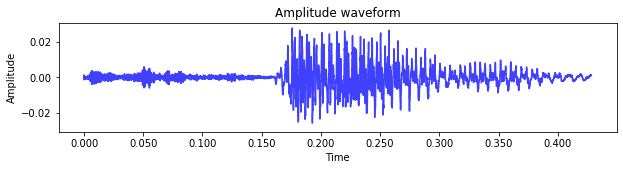

In [12]:
# plot as a waveform 
fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.waveshow(y=x, sr=sr, alpha=0.75, x_axis='time', color='blue')

ax.set(title='Amplitude waveform')
ax.set_ylabel('Amplitude')
ax.label_outer()

In [13]:
# sample duration in milliseconds
(1000*len(x))/SAMPLING_RATE

428.5

In the cell above, you can see the temporal duration of the audio is 428.5 milliseconds. For digits in the range 0-9, the duration of the speech segment should be around 0.5 seconds with reasonable variation depending on speech rate (i.e., how fast the speaker speaks). 

## The Speech Signal Representation - Mel Spectrograms

Humans can recognize and differentiate different speech sounds based on the frequency characteristics of the sounds. For machine learning applications, human speech is represented using spectro-temporal features in the [Mel-scale](https://en.wikipedia.org/wiki/Mel_scale) extracted from the speech sample. Mel-scale features are inspired by human speech perception and auditory processing whereby the human ear has difference sensitivity (or resolution) in differet frequency bandes. That is, the human ear can better recognize differences in in lower range frequences, while higher range frequences have a lower resolution. The Mel-scale is linear for frequencies in the range (0-1kHz), and logarithmic for frequencies above 1kHz.

In the spectro-temporal representation of speech, a speech sample can be seen as a sequence of $T$ spectral vectors as $\mathbf{X} = (\mathbf{x}^1, \mathbf{x}^2, \dots, \mathbf{x}^T)$. Each spectral vector $\mathbf{x}^t \in \mathbb{R}^{k}$ at time-step $t$ is extracted from a short speech segment (~25 milliseconds) with the assumption that the signal is time-invariant in this small time window. Here, $k$ is the number of frequency bands in the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) and this is a parameter of the feature extraction pipeline. The representation is based on the Fourier transform to convert the temporal signal into the frequency domain. 

In automatic speech recognition (ASR) research and applications, spectral vectors are usually referred to as "acoustic frames". Morover, adjacent frames are extracted with some overlap between them, usually ~10 milliseconds. 

In [14]:
def extract_melspectrogram(signal, sr, num_mels):
    """
    Given a time series speech signal (.wav), sampling rate (sr), 
    and the number of mel coefficients, return a mel-scaled 
    representation of the signal as numpy array.
    """
    
    mel_features = librosa.feature.melspectrogram(y=signal,
        sr=sr,
        n_fft=200, # with sampling rate = 8000, this corresponds to 25 ms
        hop_length=80, # with sampling rate = 8000, this corresponds to 10 ms
        n_mels=num_mels, # number of frequency bins, use either 13 or 39
        fmin=50, # min frequency threshold
        fmax=4000 # max frequency threshold, set to SAMPLING_RATE/2
    )
    
    # for numerical stability added this line
    mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

    # 20 * log10 to convert to log scale
    log_mel_features = 20*np.log10(mel_features)

    # feature scaling
    scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)
    
    return scaled_log_mel_features

In [15]:
melspectrogram = extract_melspectrogram(x, sr, num_mels=13)

melspectrogram.shape

(13, 43)

Note that the shape of the array (K x T) represents the number of frequency bands (K) and the number of spectral vectors in this representation (here, K=13, T=43). K is a hyperparameter and the recommended values in ASR research are (13, 39, 81, etc). Here, we fix K = 13. On the other hand, T varies from sample to sample depending on the duration of the sample.  

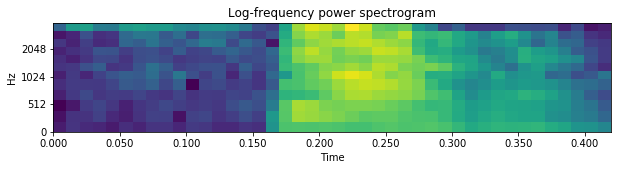

In [16]:
# plot and view the spectrogram

fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.specshow(
    melspectrogram, 
    sr=sr, 
    x_axis='time', 
    y_axis='mel', 
    cmap='viridis', 
    fmax=4000, 
    hop_length=80
)

ax.set(title='Log-frequency power spectrogram')

ax.label_outer()

As you can see above from the figure, the spectrogram representation can be viewed as a matrix $\mathbf{X} \in \mathbb{R}^{T} \times \mathbb{R}^{k}$.  

## Task I
1. One problem with the spectrogram as a speech feature represetation is that different speech samples would have dfferent durations due to inherent speech variability (e.g., speech rate, speaker dialect, etc). That is, the $T$ in the $(T \times k)$-dimensional representation would be different for each sample. Therefore, for the baseline model, we will implement a method to have a fixed-size representation for all speech samples. Write a function downsample_spectrogram(X, N) that takes as input a spectrogram $\mathbf{X} \in \mathbb{R}^{T \times k}$ and a parameter N <= 25. The function should (1) make N equally-sized splits of S across the time-axis, (2) apply a pooling technique (e.g., mean pooling) to each split across the frequency axis to obtain an array that represents a downsampled version of the spectrogram $\mathbf{X}' \in \mathbb{R}^{N \times k}$, and (3) re-arange $\mathbf{X}'$ as a vector $\mathbf{v} \in \mathbb{R}^{Nk}$.    

2. Using the downsample_spectrogram(X, N) function, transform all the speech samples into vectors $\mathbf{v} \in \mathbb{R}^{Nk}$. 

3. Given the speaker-based train/dev/test spilts in the SDR_metadata.tsv, fit a linear model on the training samples. That is, your model should be build on data from 4 speakers {'nicolas', 'theo' , 'jackson',  'george'}. Hint: you can experiment with a few model alternatives in the SGDClassifier module in scikit-learn. 

4. Evaluate you model on the dev and test splits. Use accuracy as an evaluation metric. Analyze the model performance using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of the all possible labels (0-9), Analyze [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall), [F1-score](https://en.wikipedia.org/wiki/F-score) for each label. Report your observation.

## Baseline Model

In [69]:
def maxmin(x):
    maxi=np.max(x)
    mini=np.min(x)
    if abs(maxi)>abs(mini):
        return maxi
    elif abs(maxi)<=abs(mini):
        return mini

x=np.random.randn(5)
print("input array:\n",x)
print("output:\n")
print(maxmin(x))

#### Reasoning behind downsampled_spectrogram()
for the downsampled_spectrogram() fucntion we have first padded the given signal to a value where its sequence length is divisible by the value of N given. To aggregate the values we have used absolute pooling so that the variation at the maximum level both negative and positve can be preserved[1].



In [78]:
def downsample_spectrogram(X, N):
    """
    Given a spectrogram of an arbitrary length/duration (X ∈ K x T), 
    return a downsampled version of the spectrogram v ∈ K * N
    """
    # ... your code here
    x=X
    lrb = N-x.shape[1]%N #remaining values
    zp=np.zeros((x.shape[0],lrb))
    x=np.concatenate((x,zp),axis=1)
    zX = np.zeros((x.shape[0],N))
    #number of split
    wsn = int(x.shape[1]/N) #within split population
    for i in range(x.shape[0]):
        for j in range(N):
            zX[i,j] = maxmin(x[i,j*wsn:(j+1)*wsn])
            
    X=torch.tensor(zX).view(1,-1)
    X=X.numpy()
    return X

In [79]:
downsample_spectrogram(melspectrogram,25).shape

(1, 325)

In [82]:
# prepare data and split 
N=25
dummy=np.zeros((1,N*13))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label in tqdm(zip(sdr_df['file'],sdr_df['split'],sdr_df['label'])):
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
        data=downsample_spectrogram(melspectrogram, N)
        datadict[split]=np.concatenate((datadict[split],data),axis=0)
        labeldict[split].append(label)
train_data = datadict['TRAIN'][1:]
test_data = datadict['TEST'][1:]
val_data = datadict['DEV'][1:]
train_y = labeldict['TRAIN'] 
test_y = labeldict['TEST']
val_y = labeldict['DEV']

3000it [00:16, 179.74it/s]


The data produced is normalised using the simple standardscalar() function and the regularisation penalty used is elasticnet [2]. This is because elastic net combines both L1 and L2 regularization methods to balance between the sparsity of the model and the size of the coefficients. To find the optimal hyperparameter we have ran multiple training sessions and evaluated on the validation dataset. We then used the set of hyperparameter with the best validation set error for further training and evaluated the trained model on the test dataset. 

In [83]:
# train a linear model
PPD = StandardScaler()
PPD.fit(train_data)
Xtrain = PPD.transform(train_data)
Xtest = PPD.transform(test_data)
Xdev = PPD.transform(val_data)
#model defined
model1 = SGDClassifier(loss="log",penalty='elasticnet',l1_ratio=0.15,alpha=0.0001,max_iter=1000)
#model training
model1.fit(Xtrain, train_y)
print(f'The accuracy on validation set: {accuracy_score(val_y, model1.predict(Xdev))*100}%')

#tuning of hyperparameter using the dev set

acc=0
lam=0
l1r=0
lambdas = [0.1,0.01,0.005,0.001,0.0005,0.0001]
l1_rat = [0.15,0.25,0.35]


for l1_r in l1_rat:
    for l in lambdas:
        model1 = SGDClassifier(loss="log",penalty='elasticnet',l1_ratio=l1_r,alpha=l,max_iter=1000)
        model1.fit(Xtrain, train_y)
        if acc < accuracy_score(val_y, model1.predict(Xdev)):
            lam=l
            l1r=l1_r
            acc=accuracy_score(val_y, model1.predict(Xdev))


        
# model trained with optimal parameter 
model1 = SGDClassifier(loss="log",penalty='elasticnet',l1_ratio=l1r,alpha=lam,max_iter=1000)   
model1.fit(Xtrain, train_y)
print(f'The accuracy on train set: {accuracy_score(train_y, model1.predict(Xtrain))*100}%')
print(f'the best validation accuracy achieved is:{accuracy_score(val_y, model1.predict(Xdev))*100}%\n')
print(f'the optimal regularisation value acheived is: {lam}\n')
print(f'the optimal l1 ratio is :{l1r}\n')

# evaluate the model using accuracy metric on test set
print(f'\nThe accuracy on test set: {accuracy_score(test_y, model1.predict(Xtest))*100}%')
# analyze the confusion matrix of the baseline
print('\nConfusion Matrix onn the test data \n', confusion_matrix(test_y,model1.predict(Xtest)))
# report precision, recall, F1-score for each label
print("\nThe Classification Report for test set classification\n",classification_report(test_y, model1.predict(Xtest), labels=list(range(10))))






The accuracy on validation set: 34.80885311871227%
The accuracy on train set: 95.39999999999999%
the best validation accuracy achieved is:35.2112676056338%

the optimal regularisation value acheived is: 0.0001

the optimal l1 ratio is :0.35


The accuracy on test set: 40.15904572564612%

Confusion Matrix onn the test data 
 [[26  0  3  0  0  0  7 15  0  2]
 [ 0 26  0  0  0  0 18  6  2  3]
 [ 0  0  8  1  0  1 30 13  1  0]
 [ 0  0  0  7  1  0 30  1  0  7]
 [ 0  1  1  2  8  0 17 15  0  2]
 [ 0  0  0  1  1 13 30  4  0  1]
 [ 0  0  0  1  0  0 40  2  0  3]
 [ 0  0  0  1  0  1 14 30  1  0]
 [ 0  1  1  0  1  1 29  3 19  1]
 [ 0  1  0  0  0  6 13  4  1 25]]

The Classification Report for test set classification
               precision    recall  f1-score   support

           0       1.00      0.49      0.66        53
           1       0.90      0.47      0.62        55
           2       0.62      0.15      0.24        54
           3       0.54      0.15      0.24        46
           4    

#### Visualization using TSNE [10]

In [96]:
X_emb =tsne(n_components=2,init='random', perplexity=3).fit_transform(Xtest)

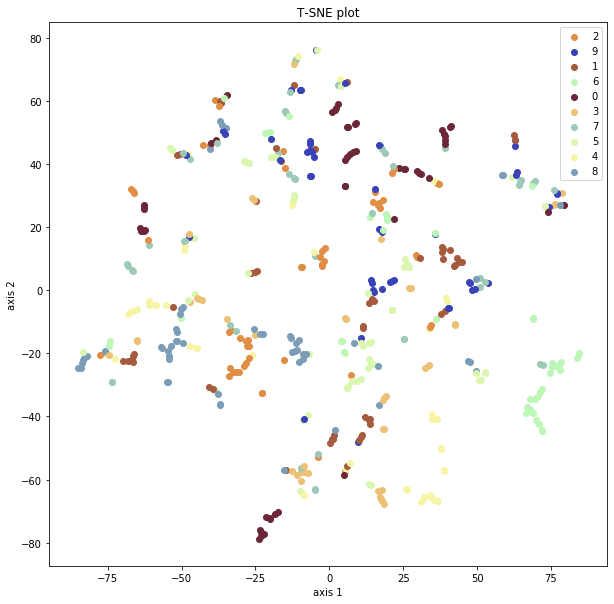

In [114]:
labels=torch.tensor(test_y)
color_dict={0:'#6B2737',1:'#A65B3E',2:'#E08E45',3:'#ECC176',4:'#F8F4A6',5:'#DBF6AF',6:'#BDF7B7',7:'#9CCAB7',8:'#7B9DB7',9:'#3943B7'}
fig=plt.figure(figsize=(10,10))
rec=[]
for i in range(X_emb.shape[0]):
    if labels[i].item() not in rec:
        rec.append(labels[i].item())
        plt.scatter(X_emb[i][0],X_emb[i][1],color=color_dict[labels[i].item()],label=str(labels[i].item()))
    else:
        plt.scatter(X_emb[i][0],X_emb[i][1],color=color_dict[labels[i].item()])
plt.xlabel("axis 1")   
plt.ylabel("axis 2")
plt.title("T-SNE plot")
plt.legend()

## Task II
1. Having established a baseline with a linear model trained on a downsampled signal representation of the speech segment, this task aims to learn a classifier based on the full speech segment. To this end, you will implement a neural model that is suitable for sequential data such as recurrent DNN, convolutional DNN with 1-D temporal convolution, or an audio transformer. The model should take the acoustic sample as it is (i.e., the Mel spectrogram could have an arbitrary length) without the need to downsample the segment. You need to implement at least two of the aforementioned models. Do the neural models improve accuracy over the baseline model? Do you observe any signs of overfitting to the training data? How do the hyperparameters affect the model performance? Report and discuss your observations.        

2. Evaluate your (best) neural models and compare to the baseline model using the same evalution process as in task I.4. 

3. Use a dimensionality reduction algorithm such as t-SNE \[[1](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding),[2](https://pypi.org/project/tsne-torch/),[3](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)\] or [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) to analyze how the different models seperate the different classes (the last non-linear layer in your model). Compare to the downsampled representation you used in the baseline and report your observations.

4. Are the differences between the different models statistically significant? To answer this question, you need to implement a statistical significance test based on bootstrapping method. To read more how to estiame p-values based on bootstrapping, we recommend the materials on this paper https://aclanthology.org/D12-1091.pdf. Include the baseline model in your evaluation. 

In [602]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
from tqdm import tqdm
from torchmetrics import F1Score
from torch.utils.data import Dataset,DataLoader
from tsne_torch import TorchTSNE as TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

In [430]:
###Helper function
#calculating loss over a dataset
def test(model,test_loader):
        loss_fn = nn.CrossEntropyLoss()
        loss=0
        for i,(xs,ys) in enumerate(test_loader):
            xs=xs.to(device)
            ys=ys.to(device)
            pred = model.forward(xs.type(torch.FloatTensor).cuda())
            loss+= loss_fn(pred,ys).item()
        print(loss/len(test_loader))
        return (loss/len(test_loader))
##function to get accuracy:
def get_accuracy(data,model):
    accdata=data
    train_acc=0
    i=0
    for X,Y in accdata:
        i+=len(X)
        X=X.to(device)
        Y=Y.to(device)
        ypred=model.forward(X.type(torch.FloatTensor).cuda())
        train_acc += torch.sum(ypred.argmax(1) == Y)
    accuracy = train_acc/i
    
    print(accuracy.item()*100,"%")
    return (accuracy.item())
#function to get the f1 score
def get_f1(data,model):
    accdata=data
    F1=0
    i=0
    for X,Y in accdata:
        i+=len(X)
        X=X.to(device)
        Y=Y.to(device)
        f1= F1Score(task="multiclass", num_classes=10).to(device)
        ypred=model.forward(X.type(torch.FloatTensor).cuda())
        f1 = f1(ypred.argmax(1),Y)
        F1+=f1.item()
    print("F1 score:",F1/i)
    return (f1.item())
#function to plot the training loss and change in norm of weight's gradient
def plot(lossrec,par):
    fig, axs = plt.subplots(1,2,figsize=(20,7))
    axs[0].set_title('epoch vs log loss')
    axs[0].plot(range(len(lossrec)),lossrec,color='orange',label='Training loss')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('log loss')
    axs[1].plot(range(len(par)),par,marker='o',color='violet',label='weight grad')
    axs[1].set_ylabel('norm of weights grad')
    axs[1].set_xlabel('epochs')
    axs[1].set_title('change of weight grad over epochs ')
    axs[1].legend()
    plt.show()

#function to get the embedding from the models 
def create_embedding(data,model):
    accdata=data
    train_acc=0
    i=0
    YP=torch.ones(1,10)
    Ys=[]
    for X,Y in accdata:
        ypred=model.forward(X.type(torch.FloatTensor).cuda())
        YP=torch.tensor(np.concatenate((YP,ypred.detach().cpu().numpy()),axis=0))
        Ys+=Y
    return YP[1:],Ys
# function to visualise the data using tsne
def tsne_map(testdl2,modellstm):
    embeds,labels=create_embedding(testdl2,modellstm)
    X_emb = tsne(n_components=2,init='random', perplexity=3).fit_transform(embeds.cpu().detach().numpy())
    color_dict={0:'#6B2737',1:'#A65B3E',2:'#E08E45',3:'#ECC176',4:'#F8F4A6',5:'#DBF6AF',6:'#BDF7B7',7:'#9CCAB7',8:'#7B9DB7',9:'#3943B7'}
    fig=plt.figure(figsize=(10,10))
    rec=[]
    for i in range(X_emb.shape[0]):
        if labels[i].item() not in rec:
            rec.append(labels[i].item())
            plt.scatter(X_emb[i][0],X_emb[i][1],color=color_dict[labels[i].item()],label=str(labels[i].item()))
        else:
            plt.scatter(X_emb[i][0],X_emb[i][1],color=color_dict[labels[i].item()])
    plt.xlabel("axis 1")   
    plt.ylabel("axis 2")
    plt.title("T-SNE plot")
    plt.legend()
    
# function to plot the confusion matrix
def confusionplot(data,model):
    accdata=data
    
    YP=[]
    Ys=[]
    for X,Y in accdata:
        X=X.to(device)
        y_pred=torch.argmax(model.forward(X.type(torch.FloatTensor).cuda()),dim=1)
        YP+=y_pred.cpu()
        Ys+=Y
    cf_matrix = confusion_matrix(Ys, YP)
    classes = (0,1,2,3,4,5,6,7,8,9)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,10))
    sn.heatmap(df_cm, annot=True)
def classificationReport(data,model):
    accdata=data
    YP=[]
    Ys=[]
    for X,Y in accdata:
        X=X.to(device)
        y_pred=torch.argmax(model.forward(X.type(torch.FloatTensor).cuda()),dim=1)
        YP+=y_pred.cpu()
        Ys+=Y
    print(classification_report(Ys, YP, labels=list(range(10))))

In [19]:
class customDataset(Dataset):
    def __init__(self, datalist, labels):
        self.labels = labels #contains the labels of the audio samples
        self.datalist = datalist # contains the audio samples in a numpy array form
        
    def __len__(self):
        return self.datalist.shape[0]
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.datalist[idx]
        return data, label


class customDataLoader(DataLoader):
    def __init__(self, customdata, batch_size, collate_fn=None):
        self.customdata = customdata
        self.batch_size = batch_size

    def loader(self):
        return DataLoader(self.customdata, self.batch_size)

In [20]:
## data processing

# determining the longest sequence
maxlength=0
for path,split,label in zip(sdr_df['file'],sdr_df['split'],sdr_df['label']):
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
        if maxlength < melspectrogram.shape[1]:
            maxlength = melspectrogram.shape[1]
print(maxlength)

229


In [21]:
## finding the maximum value in the melspectrogram # used later for normalising the data
max_val = -np.inf
for path, split, label in zip(sdr_df['file'], sdr_df['split'], sdr_df['label']):
    x, sr = librosa.load(path, sr=SAMPLING_RATE)
    melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
    if np.max(melspectrogram) > max_val:
        max_val = np.max(melspectrogram)

### Model 1: 1D CNN based

The data for the CNN based model was prepared such that all the samples are of the size 13X256. The longest sequence from the dataset turned out to be 229 which was then padded by 27 so that a size which is a power of 2 is obtained. This is done so that the size can be tracked easily after downsampling from maxpooling layer occurs. And since CNN is translational equivarient so it does not affect the performance that much[4]. The data is also normalised.  

In [37]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label in zip(sdr_df['file'],sdr_df['split'],sdr_df['label']):
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
train_data = datadict['TRAIN'][1:]
test_data = datadict['TEST'][1:]
val_data = datadict['DEV'][1:]
train_y = labeldict['TRAIN'] 
test_y = labeldict['TEST']
val_y = labeldict['DEV']

In [38]:
custom_train_dataset = customDataset(train_data, train_y)
custom_train_loader = customDataLoader(custom_train_dataset, batch_size=32)
traindl = custom_train_loader.loader()

custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=503)
testdl = custom_test_loader.loader()

custom_val_dataset = customDataset(val_data, val_y)
custom_val_loader = customDataLoader(custom_val_dataset, batch_size=32)
valdl = custom_val_loader.loader()

The CNN architecture is having 6 convolutional blocks and each of them is composed of two convolutional layers followed by Batch Normalisation, Relu Activation and Maxpooling layer. A dropout layer is applied after every convolutional layer. the dropout probability is determined later during hyperparameter tuning.

In [39]:
class cnnModel(nn.Module):
    def __init__(self, input_dim, kernel_size,d):
        super(cnnModel, self).__init__() 
        self.input_dim = input_dim
        self.k_size = kernel_size 
        self.d=d
        layers = []
        layers.append(nn.Conv1d(in_channels=self.input_dim, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        
        layers.append(nn.Conv1d(in_channels=26, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=52, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(52))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        
        layers.append(nn.Conv1d(in_channels=52, out_channels=104, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=104, out_channels=104, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(104))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        layers.append(nn.Conv1d(in_channels=104, out_channels=104, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=104, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(52))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        
        layers.append(nn.Conv1d(in_channels=52, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=52, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        
        self.conv_layers = nn.Sequential(*layers)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(26 * 4, 350, bias=True),
            nn.ReLU(),
            nn.Linear(350, 10, bias=True),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Reshape input tensor to be compatible with convolutional layers
        x = self.conv_layers(x.type(torch.FloatTensor).cuda())
        x = x.view(x.size(0), -1)  # Flatten tensor
        
        # Feed flattened tensor through fully connected layers
        x = self.fc_layers(x)
        
        return x
    
    def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01,opti='adam'):
        optidict={'adagrad':torch.optim.Adagrad(self.parameters(), lr=learning_rate),'adam':torch.optim.Adam(self.parameters(),lr=learning_rate),'sgd':torch.optim.SGD(self.parameters(), lr=learning_rate)}
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optidict[opti]
        optimizer.weight_decay = lam #torch.optim.Adam(self.parameters(),lr=learning_rate,weight_decay=lam)
        lossrec=[]
        par_grad=[]
        for epoch in range(epochs):
            tloss=0
            total_grad=0
            for i,(xs,ys) in enumerate(train_loader):
                xs=xs.to(device)
                ys=ys.to(device)
                pred = self.forward(xs.type(torch.FloatTensor).cuda())                
                loss = loss_fn(pred,ys) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                grad=0
                for p in self.parameters():
                    grad+=torch.norm(p.grad).item()
                    
                total_grad+=grad
                tloss+=loss
            lossrec.append((tloss/len(train_loader)).log().item())
            par_grad.append((total_grad/len(train_loader)))
            print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item(),'grad:',(total_grad/len(train_loader)))
        return lossrec,par_grad

#### Tuning the Hyperparameters
The following script is for selecting the optimal values for the hyperparameter by training the model multiple times with the different set of hyperparameters and then evaluating them based on the validation loss obtained. The hyperparameter values that gives the lowest values for validation loss are reported.

In [583]:
##hyperparameter tuning
la=0
optim=''
op=0
lams = [0.005,0.001,0.0005,0.0001]
optis = ['adagrad','adam','sgd']
dp=[0.2,0.3,0.35,0.5]
valoss=999
for d in dp:
    for l in lams:
            for opt in optis:
                modelcnn = cnnModel(13,3,d)
                modelcnn.to(device)
                modelcnn.train(traindl,epochs = 500, learning_rate=0.001,lam=l,opti=opt)
                if valoss>test(modelcnn,valdl):
                    valoss=test(modelcnn,valdl)
                    print(valoss)
                    la=l
                    optim=opt
                    op=d
print("optimal dropout",op)
print("optimal lambda",la)
print("optimal optimiser",optim)                    

epoch: 0 loss: 2.2930805683135986 grad: 1.5850450685561916
epoch: 1 loss: 2.240147829055786 grad: 1.427302191736147
epoch: 2 loss: 2.22637677192688 grad: 1.2675270126681657
epoch: 3 loss: 2.2212109565734863 grad: 1.214669512860137
epoch: 4 loss: 2.2173714637756348 grad: 1.294983855655624
epoch: 5 loss: 2.215639352798462 grad: 1.3666256525394846
epoch: 6 loss: 2.211505651473999 grad: 1.4911880902243808
epoch: 7 loss: 2.2052409648895264 grad: 1.6296624009467897
epoch: 8 loss: 2.1931262016296387 grad: 1.9753857920803721
epoch: 9 loss: 2.1798388957977295 grad: 2.4817684924059975
epoch: 10 loss: 2.1689720153808594 grad: 2.6472616388447703
epoch: 11 loss: 2.1603729724884033 grad: 3.02328000206589
epoch: 12 loss: 2.153085708618164 grad: 3.1691630611284856
epoch: 13 loss: 2.1430416107177734 grad: 3.515254119932208
epoch: 14 loss: 2.136294364929199 grad: 3.6435443219167016
epoch: 15 loss: 2.124990940093994 grad: 4.113669657022766
epoch: 16 loss: 2.114968776702881 grad: 4.437692186373862
epoch: 

epoch: 273 loss: 1.5928117036819458 grad: 12.94690791644629
epoch: 274 loss: 1.5875407457351685 grad: 12.657472598758186
epoch: 275 loss: 1.5787863731384277 grad: 11.931470529701087
epoch: 276 loss: 1.5878088474273682 grad: 13.120213040823323
epoch: 277 loss: 1.5863579511642456 grad: 13.297351765867678
epoch: 278 loss: 1.5789457559585571 grad: 12.595597066103466
epoch: 279 loss: 1.5757815837860107 grad: 12.55801556926472
epoch: 280 loss: 1.5783814191818237 grad: 12.516437652979105
epoch: 281 loss: 1.5890586376190186 grad: 12.755204377230257
epoch: 282 loss: 1.5783932209014893 grad: 12.429789298095756
epoch: 283 loss: 1.57935631275177 grad: 12.04805052004725
epoch: 284 loss: 1.5864462852478027 grad: 13.07054606435584
epoch: 285 loss: 1.577509880065918 grad: 12.80815263945491
epoch: 286 loss: 1.5759285688400269 grad: 12.384754111243796
epoch: 287 loss: 1.5685598850250244 grad: 12.37966501110396
epoch: 288 loss: 1.581834316253662 grad: 12.782997038111919
epoch: 289 loss: 1.577016472816467

epoch: 43 loss: 1.599351167678833 grad: 6.400820044397228
epoch: 44 loss: 1.5762724876403809 grad: 5.42666734858531
epoch: 45 loss: 1.5474992990493774 grad: 4.58220737812172
epoch: 46 loss: 1.56564462184906 grad: 5.617485897874996
epoch: 47 loss: 1.563116192817688 grad: 4.868974728767288
epoch: 48 loss: 1.5748023986816406 grad: 5.700690776416671
epoch: 49 loss: 1.5642521381378174 grad: 5.083966845912322
epoch: 50 loss: 1.575982928276062 grad: 5.558300637641965
epoch: 51 loss: 1.5705410242080688 grad: 4.784823198645845
epoch: 52 loss: 1.5705052614212036 grad: 5.185697816783814
epoch: 53 loss: 1.5648044347763062 grad: 5.394676554928887
epoch: 54 loss: 1.5656358003616333 grad: 4.749142314244593
epoch: 55 loss: 1.5752038955688477 grad: 6.342319727507423
epoch: 56 loss: 1.57538902759552 grad: 6.295640248458947
epoch: 57 loss: 1.5615038871765137 grad: 4.376180237707399
epoch: 58 loss: 1.5539402961730957 grad: 5.091849935661346
epoch: 59 loss: 1.5657848119735718 grad: 4.72040641216781
epoch: 

epoch: 316 loss: 1.5077182054519653 grad: 3.7920677489925274
epoch: 317 loss: 1.5029776096343994 grad: 2.430120952841146
epoch: 318 loss: 1.4998291730880737 grad: 2.675488773213607
epoch: 319 loss: 1.493503451347351 grad: 1.6235137526238628
epoch: 320 loss: 1.512334942817688 grad: 2.641348240744091
epoch: 321 loss: 1.4998362064361572 grad: 1.9088459932382813
epoch: 322 loss: 1.5074483156204224 grad: 2.9799234050639174
epoch: 323 loss: 1.5016560554504395 grad: 1.1088363660822425
epoch: 324 loss: 1.499989628791809 grad: 2.696858078402449
epoch: 325 loss: 1.507567048072815 grad: 2.815922259023575
epoch: 326 loss: 1.5102472305297852 grad: 2.2643079573440854
epoch: 327 loss: 1.4973043203353882 grad: 2.0248681964645128
epoch: 328 loss: 1.5401523113250732 grad: 2.900291541594777
epoch: 329 loss: 1.5103963613510132 grad: 2.0513898172798197
epoch: 330 loss: 1.5007542371749878 grad: 2.4464096706978755
epoch: 331 loss: 1.5047271251678467 grad: 2.987615454334247
epoch: 332 loss: 1.505662202835083 

epoch: 87 loss: 2.301201820373535 grad: 1.5279387116232621
epoch: 88 loss: 2.3010616302490234 grad: 1.5229398180834122
epoch: 89 loss: 2.3009276390075684 grad: 1.5301522645334313
epoch: 90 loss: 2.3017771244049072 grad: 1.5175319907148295
epoch: 91 loss: 2.3008036613464355 grad: 1.5407615230743965
epoch: 92 loss: 2.3008265495300293 grad: 1.5285852972015237
epoch: 93 loss: 2.301095485687256 grad: 1.5274479548550315
epoch: 94 loss: 2.300771474838257 grad: 1.5330784062222977
epoch: 95 loss: 2.301344871520996 grad: 1.5227380555403967
epoch: 96 loss: 2.300814628601074 grad: 1.5335654183475684
epoch: 97 loss: 2.3009350299835205 grad: 1.532312415719461
epoch: 98 loss: 2.300408124923706 grad: 1.5416976912612361
epoch: 99 loss: 2.3009049892425537 grad: 1.5381169028668886
epoch: 100 loss: 2.3009586334228516 grad: 1.5192196661299686
epoch: 101 loss: 2.3004491329193115 grad: 1.5394820104194213
epoch: 102 loss: 2.300675392150879 grad: 1.5366607013820035
epoch: 103 loss: 2.3004863262176514 grad: 1.5

epoch: 359 loss: 2.2670416831970215 grad: 2.4582494497299194
epoch: 360 loss: 2.2647664546966553 grad: 2.546633932236878
epoch: 361 loss: 2.267204761505127 grad: 2.5434748846778854
epoch: 362 loss: 2.2690701484680176 grad: 2.5999013430084146
epoch: 363 loss: 2.265957832336426 grad: 2.580254005955621
epoch: 364 loss: 2.263889789581299 grad: 2.6243934790448598
epoch: 365 loss: 2.263291120529175 grad: 2.6729671121353196
epoch: 366 loss: 2.2639284133911133 grad: 2.6592189924835803
epoch: 367 loss: 2.261939764022827 grad: 2.7158800385862825
epoch: 368 loss: 2.261488676071167 grad: 2.743188621498467
epoch: 369 loss: 2.25821852684021 grad: 2.80503869543059
epoch: 370 loss: 2.2591733932495117 grad: 2.8912792692796163
epoch: 371 loss: 2.258540391921997 grad: 2.8427407327625485
epoch: 372 loss: 2.2577147483825684 grad: 2.9290745283277437
epoch: 373 loss: 2.254122734069824 grad: 2.963291515141637
epoch: 374 loss: 2.2525339126586914 grad: 2.940809825612676
epoch: 375 loss: 2.2514045238494873 grad:

epoch: 132 loss: 1.6683872938156128 grad: 11.207667439229905
epoch: 133 loss: 1.6817480325698853 grad: 11.837802822095535
epoch: 134 loss: 1.6732252836227417 grad: 10.363514271875223
epoch: 135 loss: 1.681817889213562 grad: 11.710762376172674
epoch: 136 loss: 1.6746857166290283 grad: 11.669900666013183
epoch: 137 loss: 1.672948956489563 grad: 11.608433217416325
epoch: 138 loss: 1.6767101287841797 grad: 11.761718867974917
epoch: 139 loss: 1.669561743736267 grad: 10.902147856511412
epoch: 140 loss: 1.6661088466644287 grad: 10.705006586609496
epoch: 141 loss: 1.6707255840301514 grad: 12.461996726122582
epoch: 142 loss: 1.6655502319335938 grad: 11.03874643102643
epoch: 143 loss: 1.671895146369934 grad: 10.932943417686998
epoch: 144 loss: 1.6600170135498047 grad: 11.154792878392433
epoch: 145 loss: 1.670245885848999 grad: 12.023290196086265
epoch: 146 loss: 1.6632194519042969 grad: 11.305983431119886
epoch: 147 loss: 1.6664484739303589 grad: 11.095670279714145
epoch: 148 loss: 1.66627097129

epoch: 402 loss: 1.5500348806381226 grad: 12.343130655472152
epoch: 403 loss: 1.5555033683776855 grad: 12.470974453490243
epoch: 404 loss: 1.5516986846923828 grad: 11.502057754678564
epoch: 405 loss: 1.5477900505065918 grad: 12.234796667190652
epoch: 406 loss: 1.5498942136764526 grad: 11.85323823750433
epoch: 407 loss: 1.5460866689682007 grad: 10.785382113855569
epoch: 408 loss: 1.5534342527389526 grad: 11.657043452489205
epoch: 409 loss: 1.550368309020996 grad: 12.246219610104278
epoch: 410 loss: 1.5498230457305908 grad: 11.130193057045016
epoch: 411 loss: 1.5485363006591797 grad: 10.987125598677686
epoch: 412 loss: 1.5507785081863403 grad: 11.475731454050493
epoch: 413 loss: 1.5490727424621582 grad: 11.660106593048171
epoch: 414 loss: 1.545487880706787 grad: 11.099891232407932
epoch: 415 loss: 1.5467199087142944 grad: 11.477215831894206
epoch: 416 loss: 1.5426318645477295 grad: 11.951705430771062
epoch: 417 loss: 1.5519404411315918 grad: 12.856594745376487
epoch: 418 loss: 1.55072259

epoch: 175 loss: 1.5250561237335205 grad: 4.331941203539602
epoch: 176 loss: 1.519188642501831 grad: 2.3339511512595355
epoch: 177 loss: 1.5142806768417358 grad: 2.324693840607272
epoch: 178 loss: 1.5095572471618652 grad: 2.197158758960149
epoch: 179 loss: 1.5211974382400513 grad: 2.968113400744191
epoch: 180 loss: 1.510475993156433 grad: 2.553490041709419
epoch: 181 loss: 1.5156124830245972 grad: 3.963123481111855
epoch: 182 loss: 1.5302150249481201 grad: 3.2789711572675873
epoch: 183 loss: 1.5150123834609985 grad: 3.707062680729723
epoch: 184 loss: 1.5160280466079712 grad: 3.329274545039459
epoch: 185 loss: 1.522995948791504 grad: 3.6755793555831406
epoch: 186 loss: 1.5131906270980835 grad: 3.5895887527226575
epoch: 187 loss: 1.5094720125198364 grad: 2.8778583358355982
epoch: 188 loss: 1.5409013032913208 grad: 4.074593964276272
epoch: 189 loss: 1.5194607973098755 grad: 3.404243497668528
epoch: 190 loss: 1.5256866216659546 grad: 3.464597461234128
epoch: 191 loss: 1.5283305644989014 gr

epoch: 445 loss: 1.4998071193695068 grad: 2.119086554859631
epoch: 446 loss: 1.5006814002990723 grad: 3.110711134146517
epoch: 447 loss: 1.4994468688964844 grad: 2.110218951468867
epoch: 448 loss: 1.492106556892395 grad: 1.5070332474718395
epoch: 449 loss: 1.496382713317871 grad: 1.3367802114946035
epoch: 450 loss: 1.5097113847732544 grad: 2.5021951563432774
epoch: 451 loss: 1.4982552528381348 grad: 2.543609401920156
epoch: 452 loss: 1.4937511682510376 grad: 1.8750620766144903
epoch: 453 loss: 1.4930189847946167 grad: 2.5460510832878627
epoch: 454 loss: 1.498647689819336 grad: 2.8257505920697232
epoch: 455 loss: 1.4903838634490967 grad: 1.305831836451303
epoch: 456 loss: 1.485292673110962 grad: 1.1962881067367086
epoch: 457 loss: 1.4980072975158691 grad: 2.6009093105609975
epoch: 458 loss: 1.4935718774795532 grad: 1.862499498264393
epoch: 459 loss: 1.4954036474227905 grad: 1.5029233286543655
epoch: 460 loss: 1.4979290962219238 grad: 1.8282669857167866
epoch: 461 loss: 1.480596065521240

epoch: 218 loss: 2.258265972137451 grad: 2.294876620299109
epoch: 219 loss: 2.25773549079895 grad: 2.195196610271177
epoch: 220 loss: 2.2556941509246826 grad: 2.1279625071707877
epoch: 221 loss: 2.2542576789855957 grad: 2.0796599165344287
epoch: 222 loss: 2.252755641937256 grad: 2.0516240674640156
epoch: 223 loss: 2.2537624835968018 grad: 2.047844059724686
epoch: 224 loss: 2.251457929611206 grad: 1.9833010414519185
epoch: 225 loss: 2.250713586807251 grad: 1.9635783981103154
epoch: 226 loss: 2.2515904903411865 grad: 1.9726802144358526
epoch: 227 loss: 2.248377561569214 grad: 1.8926262236255709
epoch: 228 loss: 2.2498178482055664 grad: 1.9097113530742862
epoch: 229 loss: 2.247657537460327 grad: 1.8504144923192345
epoch: 230 loss: 2.2482237815856934 grad: 1.901328616376434
epoch: 231 loss: 2.247603416442871 grad: 1.8426657189238107
epoch: 232 loss: 2.2460310459136963 grad: 1.8210642763805236
epoch: 233 loss: 2.2447705268859863 grad: 1.7811255755738193
epoch: 234 loss: 2.244868755340576 gr

epoch: 490 loss: 2.173626184463501 grad: 2.197178065588343
epoch: 491 loss: 2.175212860107422 grad: 2.3801750898886
epoch: 492 loss: 2.175781488418579 grad: 2.3494127567742935
epoch: 493 loss: 2.1748368740081787 grad: 2.279024456762561
epoch: 494 loss: 2.1740028858184814 grad: 2.290554709671553
epoch: 495 loss: 2.1758296489715576 grad: 2.3916785196024213
epoch: 496 loss: 2.173600196838379 grad: 2.4012635589802698
epoch: 497 loss: 2.1723647117614746 grad: 2.4093578052725495
epoch: 498 loss: 2.173295259475708 grad: 2.342843115071042
epoch: 499 loss: 2.171808958053589 grad: 2.419130266721671
2.2303716093301773
epoch: 0 loss: 2.290409803390503 grad: 1.742264002053407
epoch: 1 loss: 2.2398643493652344 grad: 2.2140455541555726
epoch: 2 loss: 2.2008745670318604 grad: 2.072609248231091
epoch: 3 loss: 2.185945987701416 grad: 2.1401665803000687
epoch: 4 loss: 2.1777851581573486 grad: 2.129654939199561
epoch: 5 loss: 2.171133279800415 grad: 2.1946045387562156
epoch: 6 loss: 2.162231683731079 grad

epoch: 263 loss: 1.6020523309707642 grad: 12.78325109426967
epoch: 264 loss: 1.601541519165039 grad: 12.08682209568187
epoch: 265 loss: 1.597174048423767 grad: 12.394308279128007
epoch: 266 loss: 1.602845311164856 grad: 11.987406848767211
epoch: 267 loss: 1.5981202125549316 grad: 12.300810154261333
epoch: 268 loss: 1.6034234762191772 grad: 12.4861013897739
epoch: 269 loss: 1.6017892360687256 grad: 12.678882669480075
epoch: 270 loss: 1.5976064205169678 grad: 12.894438176608038
epoch: 271 loss: 1.595649003982544 grad: 12.934068076260802
epoch: 272 loss: 1.5925904512405396 grad: 11.771185993534765
epoch: 273 loss: 1.5976849794387817 grad: 12.213296373034753
epoch: 274 loss: 1.6110504865646362 grad: 13.369162073721075
epoch: 275 loss: 1.5975059270858765 grad: 12.979874502047009
epoch: 276 loss: 1.600878119468689 grad: 12.49882570611653
epoch: 277 loss: 1.5899348258972168 grad: 12.487816364999624
epoch: 278 loss: 1.5863099098205566 grad: 12.177751062962685
epoch: 279 loss: 1.596678495407104

epoch: 34 loss: 1.6063016653060913 grad: 6.118090392853663
epoch: 35 loss: 1.6160072088241577 grad: 6.48392538545863
epoch: 36 loss: 1.5984313488006592 grad: 5.913014768875337
epoch: 37 loss: 1.5987005233764648 grad: 7.832699138897638
epoch: 38 loss: 1.6124656200408936 grad: 6.118363355457635
epoch: 39 loss: 1.5803303718566895 grad: 5.789141745078629
epoch: 40 loss: 1.5967351198196411 grad: 6.521418322728081
epoch: 41 loss: 1.58103346824646 grad: 5.356973634377288
epoch: 42 loss: 1.6023669242858887 grad: 5.794090027779309
epoch: 43 loss: 1.620063066482544 grad: 7.8629932652863594
epoch: 44 loss: 1.6037358045578003 grad: 6.476878418964055
epoch: 45 loss: 1.5948843955993652 grad: 6.452696831532641
epoch: 46 loss: 1.5840691328048706 grad: 5.21232243297605
epoch: 47 loss: 1.5683002471923828 grad: 5.148507261971804
epoch: 48 loss: 1.5691877603530884 grad: 5.2119871205425925
epoch: 49 loss: 1.599223017692566 grad: 6.192165338179678
epoch: 50 loss: 1.5786982774734497 grad: 5.053869121955638
e

epoch: 307 loss: 1.5113800764083862 grad: 1.4933631190976275
epoch: 308 loss: 1.5159190893173218 grad: 3.701297549247792
epoch: 309 loss: 1.519187569618225 grad: 2.8650193959838224
epoch: 310 loss: 1.509589433670044 grad: 2.477565083400619
epoch: 311 loss: 1.499950647354126 grad: 2.3139139912553643
epoch: 312 loss: 1.4943217039108276 grad: 1.9417242978328793
epoch: 313 loss: 1.499916434288025 grad: 2.7415029953864503
epoch: 314 loss: 1.5151629447937012 grad: 2.5619694213395197
epoch: 315 loss: 1.521702766418457 grad: 3.615077993613581
epoch: 316 loss: 1.5060899257659912 grad: 2.9724818805069817
epoch: 317 loss: 1.513778567314148 grad: 2.2642501651125526
epoch: 318 loss: 1.4978071451187134 grad: 2.3513929641765334
epoch: 319 loss: 1.532547950744629 grad: 3.2892787663417886
epoch: 320 loss: 1.505248785018921 grad: 1.799235790647739
epoch: 321 loss: 1.5028722286224365 grad: 2.486006705305049
epoch: 322 loss: 1.5135369300842285 grad: 4.034887507889455
epoch: 323 loss: 1.513380765914917 gra

epoch: 79 loss: 2.3011534214019775 grad: 1.6534727838237784
epoch: 80 loss: 2.3010528087615967 grad: 1.6582193774455745
epoch: 81 loss: 2.3010432720184326 grad: 1.6589082851895087
epoch: 82 loss: 2.301077127456665 grad: 1.662388843790968
epoch: 83 loss: 2.301009178161621 grad: 1.6654880161744556
epoch: 84 loss: 2.301180839538574 grad: 1.645524248961241
epoch: 85 loss: 2.300567865371704 grad: 1.6672459320527397
epoch: 86 loss: 2.301227569580078 grad: 1.658738358129215
epoch: 87 loss: 2.3011677265167236 grad: 1.6575597179573147
epoch: 88 loss: 2.301320791244507 grad: 1.6706640912212491
epoch: 89 loss: 2.3006386756896973 grad: 1.662129311633873
epoch: 90 loss: 2.300227642059326 grad: 1.6825083776502796
epoch: 91 loss: 2.3008177280426025 grad: 1.6659528619909127
epoch: 92 loss: 2.3005847930908203 grad: 1.666390021834227
epoch: 93 loss: 2.3003594875335693 grad: 1.6915941561945522
epoch: 94 loss: 2.301086664199829 grad: 1.6811838018678364
epoch: 95 loss: 2.300527811050415 grad: 1.68959806361

epoch: 351 loss: 2.1662869453430176 grad: 2.5624635679913417
epoch: 352 loss: 2.163923978805542 grad: 2.3309590174033055
epoch: 353 loss: 2.1670913696289062 grad: 2.5618411163071406
epoch: 354 loss: 2.1636855602264404 grad: 2.465608689120956
epoch: 355 loss: 2.16520094871521 grad: 2.5343290106670575
epoch: 356 loss: 2.165828227996826 grad: 2.5106684470564007
epoch: 357 loss: 2.1637656688690186 grad: 2.4839646876216794
epoch: 358 loss: 2.1644954681396484 grad: 2.4597208892449824
epoch: 359 loss: 2.1627471446990967 grad: 2.4377554283747154
epoch: 360 loss: 2.164215326309204 grad: 2.5516228737043485
epoch: 361 loss: 2.1639108657836914 grad: 2.567239992364886
epoch: 362 loss: 2.164907455444336 grad: 2.5516466854236253
epoch: 363 loss: 2.1632752418518066 grad: 2.479700064920406
epoch: 364 loss: 2.162715196609497 grad: 2.508605919575082
epoch: 365 loss: 2.162285566329956 grad: 2.4853017765119496
epoch: 366 loss: 2.1628811359405518 grad: 2.596110205685291
epoch: 367 loss: 2.1626791954040527 g

epoch: 125 loss: 1.734775424003601 grad: 12.353490587545647
epoch: 126 loss: 1.740657925605774 grad: 12.126420236503085
epoch: 127 loss: 1.7358042001724243 grad: 12.452789857998372
epoch: 128 loss: 1.7381539344787598 grad: 11.92343184386661
epoch: 129 loss: 1.7316125631332397 grad: 12.199815320013652
epoch: 130 loss: 1.7357851266860962 grad: 11.871528144467563
epoch: 131 loss: 1.7317079305648804 grad: 11.929566789891512
epoch: 132 loss: 1.7276721000671387 grad: 12.435174414873241
epoch: 133 loss: 1.7229721546173096 grad: 12.02958546164963
epoch: 134 loss: 1.7214492559432983 grad: 11.902495215602574
epoch: 135 loss: 1.71578049659729 grad: 12.513980548547964
epoch: 136 loss: 1.7177808284759521 grad: 12.275731257251685
epoch: 137 loss: 1.7215806245803833 grad: 12.4103972812198
epoch: 138 loss: 1.7136940956115723 grad: 12.542370876386052
epoch: 139 loss: 1.7084317207336426 grad: 12.351741095605705
epoch: 140 loss: 1.7075977325439453 grad: 12.117870223309312
epoch: 141 loss: 1.7060285806655

epoch: 395 loss: 1.5603207349777222 grad: 10.58739236551189
epoch: 396 loss: 1.5576356649398804 grad: 11.174202740255241
epoch: 397 loss: 1.5567858219146729 grad: 10.592725790290546
epoch: 398 loss: 1.556788444519043 grad: 11.935733504693157
epoch: 399 loss: 1.5586210489273071 grad: 11.721297461498853
epoch: 400 loss: 1.5562851428985596 grad: 11.702600416128657
epoch: 401 loss: 1.556424856185913 grad: 10.249004161916673
epoch: 402 loss: 1.564408302307129 grad: 12.121700055882453
epoch: 403 loss: 1.5597668886184692 grad: 11.114363998071187
epoch: 404 loss: 1.5561970472335815 grad: 10.935467255708303
epoch: 405 loss: 1.5594993829727173 grad: 11.249805597422112
epoch: 406 loss: 1.5667598247528076 grad: 11.14689892001583
epoch: 407 loss: 1.5561343431472778 grad: 11.649314620495138
epoch: 408 loss: 1.5561553239822388 grad: 11.326132179812587
epoch: 409 loss: 1.5578902959823608 grad: 11.35950070689802
epoch: 410 loss: 1.5522871017456055 grad: 12.17431709590915
epoch: 411 loss: 1.551567554473

epoch: 168 loss: 1.5226246118545532 grad: 4.144913043379132
epoch: 169 loss: 1.5125459432601929 grad: 2.43284684357205
epoch: 170 loss: 1.5170153379440308 grad: 3.2341157936200893
epoch: 171 loss: 1.508777379989624 grad: 2.8167018215229653
epoch: 172 loss: 1.5203304290771484 grad: 3.9102474702193706
epoch: 173 loss: 1.5068708658218384 grad: 2.453108350900843
epoch: 174 loss: 1.5134304761886597 grad: 2.9978510030621903
epoch: 175 loss: 1.5077509880065918 grad: 2.501512569749213
epoch: 176 loss: 1.5059384107589722 grad: 1.733953433419486
epoch: 177 loss: 1.5148800611495972 grad: 2.431412050375065
epoch: 178 loss: 1.506728172302246 grad: 3.1574692998011846
epoch: 179 loss: 1.5093255043029785 grad: 2.9267190833765313
epoch: 180 loss: 1.505867838859558 grad: 2.128883301271161
epoch: 181 loss: 1.512125015258789 grad: 2.9836092960221516
epoch: 182 loss: 1.5258097648620605 grad: 3.000673152076554
epoch: 183 loss: 1.5073909759521484 grad: 2.7358046421921367
epoch: 184 loss: 1.5170248746871948 g

epoch: 304 loss: 1.4994237422943115 grad: 2.57191735720224
epoch: 305 loss: 1.5093281269073486 grad: 3.1938224046583215
epoch: 306 loss: 1.5125195980072021 grad: 2.4068621872837914
epoch: 307 loss: 1.494893193244934 grad: 1.879315033057754
epoch: 308 loss: 1.5026007890701294 grad: 2.3655486480103045
epoch: 309 loss: 1.5075640678405762 grad: 1.4474256923953335
epoch: 310 loss: 1.4940760135650635 grad: 1.3652044714622413
epoch: 311 loss: 1.5030381679534912 grad: 3.0480191704506785
epoch: 312 loss: 1.4988752603530884 grad: 2.1853304860176705
epoch: 313 loss: 1.4945660829544067 grad: 1.312800086997353
epoch: 314 loss: 1.4899412393569946 grad: 1.7959434605107123
epoch: 315 loss: 1.4978070259094238 grad: 2.8444953642615745
epoch: 316 loss: 1.4902338981628418 grad: 1.5622925734004642
epoch: 317 loss: 1.4873985052108765 grad: 1.2809082831715068
epoch: 318 loss: 1.5212262868881226 grad: 4.830429618243873
epoch: 319 loss: 1.5317308902740479 grad: 3.661020362216141
epoch: 320 loss: 1.515753269195

epoch: 75 loss: 2.303009510040283 grad: 1.591791807988008
epoch: 76 loss: 2.30214524269104 grad: 1.6144148375846386
epoch: 77 loss: 2.3027284145355225 grad: 1.5924838941640382
epoch: 78 loss: 2.3028008937835693 grad: 1.591077196323091
epoch: 79 loss: 2.3026795387268066 grad: 1.5954809248103716
epoch: 80 loss: 2.302518606185913 grad: 1.5931896675352215
epoch: 81 loss: 2.303088665008545 grad: 1.579107377395433
epoch: 82 loss: 2.302924394607544 grad: 1.5871981165412488
epoch: 83 loss: 2.3024840354919434 grad: 1.6057570006731632
epoch: 84 loss: 2.3021256923675537 grad: 1.5889526652246122
epoch: 85 loss: 2.3026533126831055 grad: 1.5860870925354815
epoch: 86 loss: 2.30238676071167 grad: 1.6037006350455894
epoch: 87 loss: 2.3027255535125732 grad: 1.5892638544448547
epoch: 88 loss: 2.302241802215576 grad: 1.601133087775596
epoch: 89 loss: 2.302570343017578 grad: 1.598629546778587
epoch: 90 loss: 2.3029353618621826 grad: 1.5828439882745788
epoch: 91 loss: 2.302471876144409 grad: 1.5967447584539

epoch: 346 loss: 2.242856502532959 grad: 1.8988884397143024
epoch: 347 loss: 2.243131399154663 grad: 1.8981186159043795
epoch: 348 loss: 2.2418887615203857 grad: 1.8692985593363465
epoch: 349 loss: 2.242844820022583 grad: 1.8903939234617624
epoch: 350 loss: 2.24222469329834 grad: 1.936745691582531
epoch: 351 loss: 2.239478826522827 grad: 1.832450107970674
epoch: 352 loss: 2.240593194961548 grad: 1.8905518025913763
epoch: 353 loss: 2.2392306327819824 grad: 1.803659125048268
epoch: 354 loss: 2.238477945327759 grad: 1.8503822105666918
epoch: 355 loss: 2.23830246925354 grad: 1.8353179324684399
epoch: 356 loss: 2.2382125854492188 grad: 1.845394285521396
epoch: 357 loss: 2.2378430366516113 grad: 1.7685107431958416
epoch: 358 loss: 2.2371621131896973 grad: 1.7937033355073442
epoch: 359 loss: 2.2356138229370117 grad: 1.7774270312151028
epoch: 360 loss: 2.23606014251709 grad: 1.7801425472744519
epoch: 361 loss: 2.236351490020752 grad: 1.8086242572116178
epoch: 362 loss: 2.2342660427093506 grad:

epoch: 120 loss: 1.9740849733352661 grad: 6.883413162496355
epoch: 121 loss: 1.9739288091659546 grad: 7.2446212032662025
epoch: 122 loss: 1.9770711660385132 grad: 7.532549057288894
epoch: 123 loss: 1.9799548387527466 grad: 7.624834679865411
epoch: 124 loss: 1.9754170179367065 grad: 7.692575943988881
epoch: 125 loss: 1.972841501235962 grad: 7.30644813410583
epoch: 126 loss: 1.9721640348434448 grad: 7.218748716327052
epoch: 127 loss: 1.9606295824050903 grad: 7.305507719694149
epoch: 128 loss: 1.9695594310760498 grad: 7.565867537706499
epoch: 129 loss: 1.9613298177719116 grad: 7.727003323372513
epoch: 130 loss: 1.9558029174804688 grad: 8.204251011759634
epoch: 131 loss: 1.9562262296676636 grad: 7.7832228813083875
epoch: 132 loss: 1.961621642112732 grad: 8.327464905050066
epoch: 133 loss: 1.9588145017623901 grad: 8.105819639579822
epoch: 134 loss: 1.9563508033752441 grad: 8.02832518915631
epoch: 135 loss: 1.9539927244186401 grad: 8.027765622776416
epoch: 136 loss: 1.9493573904037476 grad: 

epoch: 391 loss: 1.713897943496704 grad: 13.541331967531097
epoch: 392 loss: 1.700379729270935 grad: 14.076859042447593
epoch: 393 loss: 1.7236981391906738 grad: 14.412826767442601
epoch: 394 loss: 1.718788743019104 grad: 14.054789154095547
epoch: 395 loss: 1.7073609828948975 grad: 14.149076377884263
epoch: 396 loss: 1.7073956727981567 grad: 13.635918202026495
epoch: 397 loss: 1.704722285270691 grad: 13.781393207447042
epoch: 398 loss: 1.7227139472961426 grad: 14.51950088282308
epoch: 399 loss: 1.7157379388809204 grad: 14.341243825978525
epoch: 400 loss: 1.7088350057601929 grad: 14.077195510016901
epoch: 401 loss: 1.7036830186843872 grad: 13.887503026334185
epoch: 402 loss: 1.7137389183044434 grad: 13.997213646828655
epoch: 403 loss: 1.7155132293701172 grad: 13.998832848336962
epoch: 404 loss: 1.702887773513794 grad: 13.681762123761315
epoch: 405 loss: 1.7092161178588867 grad: 14.036323581038722
epoch: 406 loss: 1.7186558246612549 grad: 14.360884347139665
epoch: 407 loss: 1.71327972412

epoch: 27 loss: 1.6611344814300537 grad: 6.373418115167638
epoch: 28 loss: 1.6634654998779297 grad: 6.829760536341512
epoch: 29 loss: 1.6508491039276123 grad: 7.227521982769903
epoch: 30 loss: 1.6440759897232056 grad: 6.943717076726783
epoch: 31 loss: 1.6257359981536865 grad: 6.450760593651221
epoch: 32 loss: 1.6261160373687744 grad: 6.921142443204723
epoch: 33 loss: 1.629729151725769 grad: 6.91238727187068
epoch: 34 loss: 1.6486698389053345 grad: 6.83946810207618
epoch: 35 loss: 1.6468846797943115 grad: 6.548317362891837
epoch: 36 loss: 1.636650562286377 grad: 6.993042767840038
epoch: 37 loss: 1.6208211183547974 grad: 6.666039537492907
epoch: 38 loss: 1.6269783973693848 grad: 6.768704019831762
epoch: 39 loss: 1.6239688396453857 grad: 6.694878306222981
epoch: 40 loss: 1.6149706840515137 grad: 6.800161338056482
epoch: 41 loss: 1.632836103439331 grad: 6.911270761107777
epoch: 42 loss: 1.6271916627883911 grad: 5.349956599715427
epoch: 43 loss: 1.599394679069519 grad: 5.439555728836456
epo

epoch: 301 loss: 1.5311211347579956 grad: 2.2443539407676334
epoch: 302 loss: 1.5213184356689453 grad: 2.4142609348639192
epoch: 303 loss: 1.5391360521316528 grad: 4.5083807073863165
epoch: 304 loss: 1.5445868968963623 grad: 3.5859779820804807
epoch: 305 loss: 1.5358268022537231 grad: 3.4145226660304457
epoch: 306 loss: 1.5399137735366821 grad: 4.465428267810145
epoch: 307 loss: 1.5345406532287598 grad: 3.5975272729705776
epoch: 308 loss: 1.538428783416748 grad: 3.730242577396471
epoch: 309 loss: 1.5344595909118652 grad: 3.560721157031224
epoch: 310 loss: 1.5273679494857788 grad: 3.765917879741069
epoch: 311 loss: 1.5229448080062866 grad: 2.702142803575773
epoch: 312 loss: 1.5402400493621826 grad: 3.122023541372763
epoch: 313 loss: 1.5326975584030151 grad: 2.7082959786606984
epoch: 314 loss: 1.5284403562545776 grad: 2.7946256357355415
epoch: 315 loss: 1.5375714302062988 grad: 3.820323683878081
epoch: 316 loss: 1.567663311958313 grad: 4.2022018807039325
epoch: 317 loss: 1.53763806819915

epoch: 73 loss: 2.30264949798584 grad: 1.295970885515479
epoch: 74 loss: 2.3025403022766113 grad: 1.2970480021876505
epoch: 75 loss: 2.3030107021331787 grad: 1.283244512049437
epoch: 76 loss: 2.30263614654541 grad: 1.292804146015514
epoch: 77 loss: 2.3032190799713135 grad: 1.282929292689669
epoch: 78 loss: 2.3024470806121826 grad: 1.2942913944134489
epoch: 79 loss: 2.302464723587036 grad: 1.2947071516934399
epoch: 80 loss: 2.302145481109619 grad: 1.2973662955217093
epoch: 81 loss: 2.303067207336426 grad: 1.282100489570035
epoch: 82 loss: 2.3022568225860596 grad: 1.2911621082337603
epoch: 83 loss: 2.3022170066833496 grad: 1.2965543195087876
epoch: 84 loss: 2.3027100563049316 grad: 1.2929712611283841
epoch: 85 loss: 2.302520513534546 grad: 1.2905206205378774
epoch: 86 loss: 2.302206039428711 grad: 1.2983478526880463
epoch: 87 loss: 2.302372932434082 grad: 1.3009601010357044
epoch: 88 loss: 2.302851915359497 grad: 1.2817681013987148
epoch: 89 loss: 2.3025014400482178 grad: 1.2913230382061

epoch: 344 loss: 2.2459614276885986 grad: 1.3577385408607947
epoch: 345 loss: 2.246302366256714 grad: 1.3451566814596483
epoch: 346 loss: 2.244729518890381 grad: 1.3041217273566872
epoch: 347 loss: 2.2462284564971924 grad: 1.353358143700346
epoch: 348 loss: 2.2449076175689697 grad: 1.339608422447262
epoch: 349 loss: 2.24497652053833 grad: 1.3240407811577566
epoch: 350 loss: 2.244528293609619 grad: 1.3466599589927004
epoch: 351 loss: 2.2446787357330322 grad: 1.3492188197486694
epoch: 352 loss: 2.245008945465088 grad: 1.3266666591387346
epoch: 353 loss: 2.246204376220703 grad: 1.3628220297257594
epoch: 354 loss: 2.245497941970825 grad: 1.330205657197872
epoch: 355 loss: 2.242830753326416 grad: 1.2635525988732716
epoch: 356 loss: 2.2440414428710938 grad: 1.2842194215424123
epoch: 357 loss: 2.2440266609191895 grad: 1.2997048329063026
epoch: 358 loss: 2.243762731552124 grad: 1.271092561330454
epoch: 359 loss: 2.2437973022460938 grad: 1.2483171675065976
epoch: 360 loss: 2.2431511878967285 gr

epoch: 117 loss: 1.9046155214309692 grad: 9.666644895419715
epoch: 118 loss: 1.9048810005187988 grad: 9.428299069670695
epoch: 119 loss: 1.9034578800201416 grad: 9.654783501585444
epoch: 120 loss: 1.905213713645935 grad: 9.527869383375796
epoch: 121 loss: 1.901365876197815 grad: 10.27633268510302
epoch: 122 loss: 1.8933531045913696 grad: 9.512543539605325
epoch: 123 loss: 1.9034782648086548 grad: 10.245583726758403
epoch: 124 loss: 1.8967890739440918 grad: 10.11461559440645
epoch: 125 loss: 1.902787685394287 grad: 9.9939093800439
epoch: 126 loss: 1.9004076719284058 grad: 10.203815936835277
epoch: 127 loss: 1.8951648473739624 grad: 9.871015769370374
epoch: 128 loss: 1.89163339138031 grad: 9.894776572177689
epoch: 129 loss: 1.8956397771835327 grad: 9.870254300224284
epoch: 130 loss: 1.891597032546997 grad: 10.258679217185884
epoch: 131 loss: 1.8878746032714844 grad: 9.950853904014425
epoch: 132 loss: 1.8836493492126465 grad: 9.72028497148246
epoch: 133 loss: 1.8828518390655518 grad: 9.83

epoch: 387 loss: 1.7378907203674316 grad: 11.410492776375678
epoch: 388 loss: 1.7381004095077515 grad: 11.579107975942039
epoch: 389 loss: 1.735921859741211 grad: 11.77701436167228
epoch: 390 loss: 1.7347650527954102 grad: 11.785789757826558
epoch: 391 loss: 1.7425594329833984 grad: 11.505046842338901
epoch: 392 loss: 1.7399808168411255 grad: 12.026173195905155
epoch: 393 loss: 1.7359293699264526 grad: 12.187550136523823
epoch: 394 loss: 1.7435388565063477 grad: 11.895978630283876
epoch: 395 loss: 1.7335150241851807 grad: 11.990900875453557
epoch: 396 loss: 1.7261202335357666 grad: 12.628814589394818
epoch: 397 loss: 1.7344911098480225 grad: 11.66798773469285
epoch: 398 loss: 1.7344025373458862 grad: 11.1756216751722
epoch: 399 loss: 1.7300820350646973 grad: 12.246610761368794
epoch: 400 loss: 1.7249553203582764 grad: 12.249410386603799
epoch: 401 loss: 1.7305811643600464 grad: 10.998551285751756
epoch: 402 loss: 1.7390705347061157 grad: 11.300262320284096
epoch: 403 loss: 1.7351394891

epoch: 160 loss: 1.5596868991851807 grad: 4.682796813449591
epoch: 161 loss: 1.594649314880371 grad: 5.061901360107712
epoch: 162 loss: 1.5711499452590942 grad: 5.022388573950434
epoch: 163 loss: 1.578740119934082 grad: 6.017282534561877
epoch: 164 loss: 1.5822137594223022 grad: 4.479915291790392
epoch: 165 loss: 1.5980943441390991 grad: 5.593877582125104
epoch: 166 loss: 1.558748722076416 grad: 4.298501922887968
epoch: 167 loss: 1.564324975013733 grad: 3.5439026550659887
epoch: 168 loss: 1.5601420402526855 grad: 4.489926371308815
epoch: 169 loss: 1.5596990585327148 grad: 4.333564317998322
epoch: 170 loss: 1.558607816696167 grad: 4.380301988773448
epoch: 171 loss: 1.5586862564086914 grad: 3.190614202738974
epoch: 172 loss: 1.5552997589111328 grad: 3.988845153714394
epoch: 173 loss: 1.5617423057556152 grad: 4.854814648153264
epoch: 174 loss: 1.5654535293579102 grad: 4.985969937692336
epoch: 175 loss: 1.5734370946884155 grad: 3.7049276816665144
epoch: 176 loss: 1.5688371658325195 grad: 3

epoch: 432 loss: 1.5414714813232422 grad: 3.2781427752389023
epoch: 433 loss: 1.5318913459777832 grad: 3.7937789667794735
epoch: 434 loss: 1.530009388923645 grad: 2.0084958610170367
epoch: 435 loss: 1.5438567399978638 grad: 3.810173892112925
epoch: 436 loss: 1.5424548387527466 grad: 5.599964894400565
epoch: 437 loss: 1.5449011325836182 grad: 4.550732926460388
epoch: 438 loss: 1.5386310815811157 grad: 2.6376332010057832
epoch: 439 loss: 1.546957015991211 grad: 4.341696945100159
epoch: 440 loss: 1.5273025035858154 grad: 3.8909703835136553
epoch: 441 loss: 1.5402579307556152 grad: 1.9246586816087563
epoch: 442 loss: 1.5356403589248657 grad: 1.7561858035096634
epoch: 443 loss: 1.5240756273269653 grad: 2.6358300026075705
epoch: 444 loss: 1.5174375772476196 grad: 2.0771343417935
epoch: 445 loss: 1.5390640497207642 grad: 3.014836540747261
epoch: 446 loss: 1.5272495746612549 grad: 3.1075721061421957
epoch: 447 loss: 1.5304853916168213 grad: 2.2624417414685367
epoch: 448 loss: 1.523382186889648

epoch: 204 loss: 2.301720380783081 grad: 1.4969301640817394
epoch: 205 loss: 2.301731586456299 grad: 1.4905655337423678
epoch: 206 loss: 2.302086353302002 grad: 1.4886933708127352
epoch: 207 loss: 2.3018975257873535 grad: 1.4903093377656733
epoch: 208 loss: 2.302013397216797 grad: 1.4947474899180677
epoch: 209 loss: 2.3015215396881104 grad: 1.5005402978369227
epoch: 210 loss: 2.30210018157959 grad: 1.4745256782967657
epoch: 211 loss: 2.302096128463745 grad: 1.4897013300519792
epoch: 212 loss: 2.301543951034546 grad: 1.5045523927602473
epoch: 213 loss: 2.3014638423919678 grad: 1.503377067998776
epoch: 214 loss: 2.3006646633148193 grad: 1.5125252903671935
epoch: 215 loss: 2.3018312454223633 grad: 1.5034690198566143
epoch: 216 loss: 2.302318811416626 grad: 1.494877963681661
epoch: 217 loss: 2.301217794418335 grad: 1.4987039518513021
epoch: 218 loss: 2.301793336868286 grad: 1.5025501715329785
epoch: 219 loss: 2.3013548851013184 grad: 1.5035009628553535
epoch: 220 loss: 2.3019988536834717 g

epoch: 476 loss: 2.235508441925049 grad: 1.1388230398796233
epoch: 477 loss: 2.2353110313415527 grad: 1.1287117682208883
epoch: 478 loss: 2.2355988025665283 grad: 1.185439281350386
epoch: 479 loss: 2.23494291305542 grad: 1.1205399429041243
epoch: 480 loss: 2.2348814010620117 grad: 1.1242058371223274
epoch: 481 loss: 2.234867572784424 grad: 1.0812254684740707
epoch: 482 loss: 2.235396385192871 grad: 1.1444578433782602
epoch: 483 loss: 2.235619306564331 grad: 1.1907990946109215
epoch: 484 loss: 2.2344725131988525 grad: 1.1143999472574613
epoch: 485 loss: 2.235337257385254 grad: 1.1692975362936509
epoch: 486 loss: 2.2338879108428955 grad: 1.1269702339445107
epoch: 487 loss: 2.23468279838562 grad: 1.1490139062627263
epoch: 488 loss: 2.2349650859832764 grad: 1.1873802305180727
epoch: 489 loss: 2.2350714206695557 grad: 1.0945830939500223
epoch: 490 loss: 2.234091281890869 grad: 1.1130836318110278
epoch: 491 loss: 2.2365121841430664 grad: 1.220018909752576
epoch: 492 loss: 2.234495162963867 g

epoch: 250 loss: 1.791428804397583 grad: 10.357337699759574
epoch: 251 loss: 1.7980260848999023 grad: 10.304083808081312
epoch: 252 loss: 1.7902634143829346 grad: 10.370742635697955
epoch: 253 loss: 1.786914587020874 grad: 10.00460820905273
epoch: 254 loss: 1.7809804677963257 grad: 10.309696942863484
epoch: 255 loss: 1.7923943996429443 grad: 10.053587388786827
epoch: 256 loss: 1.7947934865951538 grad: 9.650483417908646
epoch: 257 loss: 1.7866836786270142 grad: 10.547846166919621
epoch: 258 loss: 1.780271291732788 grad: 9.985122757439044
epoch: 259 loss: 1.7855651378631592 grad: 10.254178482189124
epoch: 260 loss: 1.7867858409881592 grad: 10.26049337548662
epoch: 261 loss: 1.7837461233139038 grad: 10.277837112738144
epoch: 262 loss: 1.7794767618179321 grad: 9.694295444984048
epoch: 263 loss: 1.7807607650756836 grad: 9.668691040504546
epoch: 264 loss: 1.7829118967056274 grad: 10.244381269218312
epoch: 265 loss: 1.7880972623825073 grad: 10.088930626798954
epoch: 266 loss: 1.77906894683837

epoch: 20 loss: 1.8419002294540405 grad: 6.79705059517818
epoch: 21 loss: 1.7795895338058472 grad: 6.416451749902787
epoch: 22 loss: 1.7872612476348877 grad: 7.097541643455366
epoch: 23 loss: 1.7811191082000732 grad: 6.954008010769492
epoch: 24 loss: 1.7582621574401855 grad: 7.637858966136322
epoch: 25 loss: 1.7743549346923828 grad: 7.2356133538497875
epoch: 26 loss: 1.7428662776947021 grad: 6.637803800850331
epoch: 27 loss: 1.7411623001098633 grad: 6.993410375294467
epoch: 28 loss: 1.735198974609375 grad: 6.955730621953355
epoch: 29 loss: 1.7065110206604004 grad: 7.0911411483548505
epoch: 30 loss: 1.7173680067062378 grad: 6.427490923688599
epoch: 31 loss: 1.7289140224456787 grad: 6.674054238500373
epoch: 32 loss: 1.723422884941101 grad: 6.889645722871166
epoch: 33 loss: 1.6882433891296387 grad: 6.708249598883124
epoch: 34 loss: 1.6967250108718872 grad: 6.856615193094873
epoch: 35 loss: 1.6990677118301392 grad: 6.753183343143771
epoch: 36 loss: 1.6815811395645142 grad: 6.21566381368445

epoch: 294 loss: 1.544938087463379 grad: 3.9138949916252623
epoch: 295 loss: 1.5571324825286865 grad: 3.375080203078334
epoch: 296 loss: 1.5463902950286865 grad: 4.499320552440929
epoch: 297 loss: 1.5681754350662231 grad: 3.8305184833080266
epoch: 298 loss: 1.558345913887024 grad: 4.212170948206195
epoch: 299 loss: 1.5720304250717163 grad: 3.6132974017194646
epoch: 300 loss: 1.554276943206787 grad: 3.580729430232589
epoch: 301 loss: 1.5415552854537964 grad: 4.729803818760076
epoch: 302 loss: 1.5576236248016357 grad: 4.511375241316501
epoch: 303 loss: 1.5662328004837036 grad: 4.428020105189145
epoch: 304 loss: 1.5590771436691284 grad: 3.5868654032015623
epoch: 305 loss: 1.5523165464401245 grad: 4.009724660486727
epoch: 306 loss: 1.547736644744873 grad: 4.539993631262965
epoch: 307 loss: 1.56369149684906 grad: 5.913765002611446
epoch: 308 loss: 1.564356803894043 grad: 3.9754048823923256
epoch: 309 loss: 1.5451024770736694 grad: 3.738693528615697
epoch: 310 loss: 1.5539048910140991 grad: 

epoch: 66 loss: 2.3026535511016846 grad: 1.4208241611985224
epoch: 67 loss: 2.3027615547180176 grad: 1.4275777012290847
epoch: 68 loss: 2.302501916885376 grad: 1.4327400316898193
epoch: 69 loss: 2.302964448928833 grad: 1.411061061004783
epoch: 70 loss: 2.302584171295166 grad: 1.4338766698880743
epoch: 71 loss: 2.30283784866333 grad: 1.4194551008376515
epoch: 72 loss: 2.3026368618011475 grad: 1.4275844011137941
epoch: 73 loss: 2.3024706840515137 grad: 1.4303543819539575
epoch: 74 loss: 2.3031466007232666 grad: 1.4212833064079786
epoch: 75 loss: 2.3027546405792236 grad: 1.429830602431182
epoch: 76 loss: 2.30263090133667 grad: 1.4188230185702975
epoch: 77 loss: 2.3019168376922607 grad: 1.4347717172894923
epoch: 78 loss: 2.3024730682373047 grad: 1.4287610306803669
epoch: 79 loss: 2.302314043045044 grad: 1.4431314767220071
epoch: 80 loss: 2.3028156757354736 grad: 1.424033685661261
epoch: 81 loss: 2.30293345451355 grad: 1.4222149206288455
epoch: 82 loss: 2.3031668663024902 grad: 1.4258717551

epoch: 338 loss: 2.2348978519439697 grad: 1.1098149822810517
epoch: 339 loss: 2.2368075847625732 grad: 1.126457244441438
epoch: 340 loss: 2.2373602390289307 grad: 1.1634213541493943
epoch: 341 loss: 2.236666202545166 grad: 1.1402131466320642
epoch: 342 loss: 2.236298084259033 grad: 1.1093235889889508
epoch: 343 loss: 2.2360622882843018 grad: 1.1403900837675403
epoch: 344 loss: 2.235785961151123 grad: 1.0808663434951404
epoch: 345 loss: 2.236323595046997 grad: 1.091263553979511
epoch: 346 loss: 2.2355456352233887 grad: 1.132901433361916
epoch: 347 loss: 2.236502170562744 grad: 1.1832715473119317
epoch: 348 loss: 2.235673427581787 grad: 1.1060556346691022
epoch: 349 loss: 2.2356696128845215 grad: 1.085742685124315
epoch: 350 loss: 2.235405683517456 grad: 1.112519436216514
epoch: 351 loss: 2.2348411083221436 grad: 1.0795846484797371
epoch: 352 loss: 2.234808921813965 grad: 1.1064279254476008
epoch: 353 loss: 2.235226631164551 grad: 1.139510130042225
epoch: 354 loss: 2.2345988750457764 gra

epoch: 111 loss: 1.9957751035690308 grad: 6.4529466367297115
epoch: 112 loss: 1.994201898574829 grad: 6.246421802626361
epoch: 113 loss: 1.9872972965240479 grad: 6.727592597419899
epoch: 114 loss: 1.9909840822219849 grad: 6.392613647719993
epoch: 115 loss: 1.990908145904541 grad: 6.615566298491248
epoch: 116 loss: 1.9881151914596558 grad: 6.657915901895317
epoch: 117 loss: 1.9915404319763184 grad: 6.883892561612089
epoch: 118 loss: 1.9878312349319458 grad: 6.573004659790072
epoch: 119 loss: 1.9914108514785767 grad: 6.946975489871369
epoch: 120 loss: 1.9896152019500732 grad: 7.035299491625102
epoch: 121 loss: 1.9777995347976685 grad: 6.885220267736013
epoch: 122 loss: 1.983310580253601 grad: 6.864612817779065
epoch: 123 loss: 1.9898258447647095 grad: 7.34601973300238
epoch: 124 loss: 1.984878420829773 grad: 7.177377334027182
epoch: 125 loss: 1.978044867515564 grad: 7.067941131883315
epoch: 126 loss: 1.9769489765167236 grad: 7.326941858651856
epoch: 127 loss: 1.9854185581207275 grad: 7.1

epoch: 382 loss: 1.7391526699066162 grad: 13.747389142549345
epoch: 383 loss: 1.7362804412841797 grad: 13.471251106776652
epoch: 384 loss: 1.7354143857955933 grad: 13.533401134305649
epoch: 385 loss: 1.7321794033050537 grad: 13.32233515575469
epoch: 386 loss: 1.736560344696045 grad: 14.180866190527995
epoch: 387 loss: 1.7337290048599243 grad: 13.322840187661646
epoch: 388 loss: 1.7332417964935303 grad: 13.268321943809353
epoch: 389 loss: 1.73065185546875 grad: 13.906287349627487
epoch: 390 loss: 1.7394753694534302 grad: 14.102099413880044
epoch: 391 loss: 1.7392048835754395 grad: 13.785887206475886
epoch: 392 loss: 1.7220999002456665 grad: 13.346706485434893
epoch: 393 loss: 1.7270365953445435 grad: 13.775959748671287
epoch: 394 loss: 1.7226332426071167 grad: 13.553714255876248
epoch: 395 loss: 1.728593111038208 grad: 14.090159848598498
epoch: 396 loss: 1.725803256034851 grad: 13.350113796099784
epoch: 397 loss: 1.7184323072433472 grad: 14.013613736404785
epoch: 398 loss: 1.72170281410

epoch: 155 loss: 1.5743366479873657 grad: 4.244252546741515
epoch: 156 loss: 1.5662009716033936 grad: 4.313566409773005
epoch: 157 loss: 1.568056583404541 grad: 4.961707612115066
epoch: 158 loss: 1.5886331796646118 grad: 5.045246852424624
epoch: 159 loss: 1.581304907798767 grad: 4.944979343609442
epoch: 160 loss: 1.581235647201538 grad: 4.802709523612885
epoch: 161 loss: 1.576906681060791 grad: 5.884593377118257
epoch: 162 loss: 1.6094712018966675 grad: 5.221110880450003
epoch: 163 loss: 1.5739058256149292 grad: 4.269943418369089
epoch: 164 loss: 1.5790488719940186 grad: 5.939712376364068
epoch: 165 loss: 1.580384373664856 grad: 5.410269825127692
epoch: 166 loss: 1.564089059829712 grad: 4.492059105347676
epoch: 167 loss: 1.5670965909957886 grad: 5.152172381981205
epoch: 168 loss: 1.5713552236557007 grad: 4.2346347714021935
epoch: 169 loss: 1.572375774383545 grad: 5.055042858883394
epoch: 170 loss: 1.562919020652771 grad: 4.7794954814862445
epoch: 171 loss: 1.5629003047943115 grad: 4.86

epoch: 427 loss: 1.5306220054626465 grad: 2.623732346672181
epoch: 428 loss: 1.5399634838104248 grad: 2.3869910058573747
epoch: 429 loss: 1.5348151922225952 grad: 3.450960762073221
epoch: 430 loss: 1.5355839729309082 grad: 4.090099089800547
epoch: 431 loss: 1.5360146760940552 grad: 3.826483815900681
epoch: 432 loss: 1.5260828733444214 grad: 3.103111974601568
epoch: 433 loss: 1.538710594177246 grad: 3.607186201904912
epoch: 434 loss: 1.5379538536071777 grad: 3.1353279982547453
epoch: 435 loss: 1.533647060394287 grad: 3.091812642077545
epoch: 436 loss: 1.5253418684005737 grad: 2.136877765326349
epoch: 437 loss: 1.5164049863815308 grad: 2.814269539295683
epoch: 438 loss: 1.5163218975067139 grad: 1.7785745314469958
epoch: 439 loss: 1.5283225774765015 grad: 2.4674323683515933
epoch: 440 loss: 1.528419017791748 grad: 2.954318677963084
epoch: 441 loss: 1.525913953781128 grad: 3.235158739764947
epoch: 442 loss: 1.5292556285858154 grad: 3.9972439853912007
epoch: 443 loss: 1.5231654644012451 gra

epoch: 199 loss: 2.3020541667938232 grad: 1.338414006419332
epoch: 200 loss: 2.302339553833008 grad: 1.3353314619744197
epoch: 201 loss: 2.3016912937164307 grad: 1.3460319235325895
epoch: 202 loss: 2.3014795780181885 grad: 1.3454407346416413
epoch: 203 loss: 2.3020544052124023 grad: 1.3481088464022688
epoch: 204 loss: 2.3013720512390137 grad: 1.3578672896320414
epoch: 205 loss: 2.3015596866607666 grad: 1.3604167538088938
epoch: 206 loss: 2.3011152744293213 grad: 1.354843639179192
epoch: 207 loss: 2.3013789653778076 grad: 1.3562073214201344
epoch: 208 loss: 2.30163836479187 grad: 1.3481212113374135
epoch: 209 loss: 2.3017172813415527 grad: 1.3436027479077142
epoch: 210 loss: 2.301795244216919 grad: 1.350453031722397
epoch: 211 loss: 2.301253318786621 grad: 1.3582921227188929
epoch: 212 loss: 2.301645040512085 grad: 1.3463944698913053
epoch: 213 loss: 2.3017776012420654 grad: 1.3517229160153499
epoch: 214 loss: 2.301060914993286 grad: 1.3654018676385196
epoch: 215 loss: 2.301492929458618

epoch: 471 loss: 2.2286789417266846 grad: 1.243531241150026
epoch: 472 loss: 2.2296338081359863 grad: 1.3113427041634356
epoch: 473 loss: 2.2286505699157715 grad: 1.3375173177984025
epoch: 474 loss: 2.2286109924316406 grad: 1.2289933252115068
epoch: 475 loss: 2.2280707359313965 grad: 1.2382032597596417
epoch: 476 loss: 2.2278008460998535 grad: 1.2893035757643658
epoch: 477 loss: 2.2285163402557373 grad: 1.2933506998935684
epoch: 478 loss: 2.2283380031585693 grad: 1.2878050737430355
epoch: 479 loss: 2.2286860942840576 grad: 1.2480620441012202
epoch: 480 loss: 2.2282216548919678 grad: 1.3067939989970967
epoch: 481 loss: 2.2285571098327637 grad: 1.3058527322312343
epoch: 482 loss: 2.2267367839813232 grad: 1.2148527831674392
epoch: 483 loss: 2.2292556762695312 grad: 1.3628645946219977
epoch: 484 loss: 2.22751784324646 grad: 1.2652983341924107
epoch: 485 loss: 2.2274367809295654 grad: 1.302831401963467
epoch: 486 loss: 2.2283895015716553 grad: 1.286994079985316
epoch: 487 loss: 2.2273087501

epoch: 245 loss: 2.015195846557617 grad: 7.6766950471090185
epoch: 246 loss: 2.0123987197875977 grad: 7.6371751129922885
epoch: 247 loss: 2.013770818710327 grad: 7.897595272162959
epoch: 248 loss: 2.013209104537964 grad: 7.530644933988769
epoch: 249 loss: 2.0080771446228027 grad: 7.53244058947478
epoch: 250 loss: 2.0081732273101807 grad: 7.5978528408791925
epoch: 251 loss: 2.0165088176727295 grad: 7.653472122640187
epoch: 252 loss: 2.0110397338867188 grad: 7.625871426825013
epoch: 253 loss: 2.0105204582214355 grad: 7.976046535666914
epoch: 254 loss: 2.009575605392456 grad: 7.579936742974771
epoch: 255 loss: 2.0037648677825928 grad: 7.478311055495094
epoch: 256 loss: 2.0047860145568848 grad: 7.705404721784391
epoch: 257 loss: 2.00244402885437 grad: 7.88631957239427
epoch: 258 loss: 1.9956451654434204 grad: 7.291832353535389
epoch: 259 loss: 1.9988361597061157 grad: 8.146569687562684
epoch: 260 loss: 2.002988815307617 grad: 7.632118550498808
epoch: 261 loss: 2.005641460418701 grad: 7.633

epoch: 16 loss: 1.9534791707992554 grad: 5.392218353084496
epoch: 17 loss: 1.9121986627578735 grad: 5.3480865283266805
epoch: 18 loss: 1.9169186353683472 grad: 5.477888349018666
epoch: 19 loss: 1.93626070022583 grad: 5.152487456783771
epoch: 20 loss: 1.903189778327942 grad: 5.796310515152217
epoch: 21 loss: 1.908437967300415 grad: 5.667679874230147
epoch: 22 loss: 1.8777645826339722 grad: 6.146587036580534
epoch: 23 loss: 1.8782979249954224 grad: 5.407361137340703
epoch: 24 loss: 1.8824820518493652 grad: 5.827636086287731
epoch: 25 loss: 1.8560431003570557 grad: 6.3210985888967235
epoch: 26 loss: 1.8667948246002197 grad: 5.893928811097303
epoch: 27 loss: 1.8593562841415405 grad: 6.146316688524888
epoch: 28 loss: 1.8459680080413818 grad: 5.368560128230398
epoch: 29 loss: 1.8561785221099854 grad: 6.764134404591344
epoch: 30 loss: 1.8617453575134277 grad: 6.408049544297336
epoch: 31 loss: 1.8160078525543213 grad: 5.618449114456159
epoch: 32 loss: 1.8122632503509521 grad: 6.044476175736192

epoch: 290 loss: 1.5651780366897583 grad: 4.3372920254343965
epoch: 291 loss: 1.5820883512496948 grad: 4.765876555455402
epoch: 292 loss: 1.5814687013626099 grad: 3.6518254187197936
epoch: 293 loss: 1.5699994564056396 grad: 4.822380377419623
epoch: 294 loss: 1.5953965187072754 grad: 4.509035977862613
epoch: 295 loss: 1.5639872550964355 grad: 3.858196452042127
epoch: 296 loss: 1.5646178722381592 grad: 3.6342088643190946
epoch: 297 loss: 1.581939458847046 grad: 4.619795846815472
epoch: 298 loss: 1.578020453453064 grad: 4.770700897803024
epoch: 299 loss: 1.6026861667633057 grad: 3.6272682274223955
epoch: 300 loss: 1.5793426036834717 grad: 3.603677733166468
epoch: 301 loss: 1.5779913663864136 grad: 4.644744732676621
epoch: 302 loss: 1.5764740705490112 grad: 4.531948836046583
epoch: 303 loss: 1.5591638088226318 grad: 3.600534548857138
epoch: 304 loss: 1.5678085088729858 grad: 3.6204983168302403
epoch: 305 loss: 1.5855717658996582 grad: 4.638484934197782
epoch: 306 loss: 1.5757472515106201 g

epoch: 62 loss: 2.302802562713623 grad: 1.3453160856355217
epoch: 63 loss: 2.303004026412964 grad: 1.3411356031299673
epoch: 64 loss: 2.302661657333374 grad: 1.3402822649601611
epoch: 65 loss: 2.302712917327881 grad: 1.352252421752801
epoch: 66 loss: 2.302159309387207 grad: 1.3508925342947127
epoch: 67 loss: 2.302953004837036 grad: 1.3500720454871447
epoch: 68 loss: 2.302356004714966 grad: 1.3528829489627645
epoch: 69 loss: 2.3026487827301025 grad: 1.3447401641557615
epoch: 70 loss: 2.302983283996582 grad: 1.3440935382885593
epoch: 71 loss: 2.3033721446990967 grad: 1.3371427369669877
epoch: 72 loss: 2.3026282787323 grad: 1.34790032344412
epoch: 73 loss: 2.302680015563965 grad: 1.3454901723612456
epoch: 74 loss: 2.3029630184173584 grad: 1.3400633438797076
epoch: 75 loss: 2.302886724472046 grad: 1.3376216551359181
epoch: 76 loss: 2.30352520942688 grad: 1.3439511566012654
epoch: 77 loss: 2.302522897720337 grad: 1.3533638209134105
epoch: 78 loss: 2.3028929233551025 grad: 1.3365640988396037

epoch: 333 loss: 2.302340030670166 grad: 1.3462472585665564
epoch: 334 loss: 2.302703380584717 grad: 1.32973584344071
epoch: 335 loss: 2.3026363849639893 grad: 1.324005332923243
epoch: 336 loss: 2.302523374557495 grad: 1.3380462423979587
epoch: 337 loss: 2.3028440475463867 grad: 1.3271516197294528
epoch: 338 loss: 2.302131175994873 grad: 1.3468170578901966
epoch: 339 loss: 2.3025400638580322 grad: 1.3370237928401265
epoch: 340 loss: 2.302438974380493 grad: 1.3323500747866337
epoch: 341 loss: 2.3024187088012695 grad: 1.333372659225475
epoch: 342 loss: 2.3016679286956787 grad: 1.350310494254772
epoch: 343 loss: 2.3022613525390625 grad: 1.3407282222280397
epoch: 344 loss: 2.302838087081909 grad: 1.3366524025572404
epoch: 345 loss: 2.301919460296631 grad: 1.3418963027319737
epoch: 346 loss: 2.3022608757019043 grad: 1.327868809245364
epoch: 347 loss: 2.302926778793335 grad: 1.3186187371445288
epoch: 348 loss: 2.3028111457824707 grad: 1.332545395811192
epoch: 349 loss: 2.3029961585998535 gra

epoch: 107 loss: 2.0645155906677246 grad: 5.023126612217831
epoch: 108 loss: 2.0638484954833984 grad: 5.675130918511146
epoch: 109 loss: 2.0626332759857178 grad: 5.49842397668325
epoch: 110 loss: 2.064359664916992 grad: 5.42059018655074
epoch: 111 loss: 2.059569835662842 grad: 5.80289863090637
epoch: 112 loss: 2.0630993843078613 grad: 5.814970608704561
epoch: 113 loss: 2.0659422874450684 grad: 5.243702921824204
epoch: 114 loss: 2.0603394508361816 grad: 6.039435331229239
epoch: 115 loss: 2.0607314109802246 grad: 5.792133282315696
epoch: 116 loss: 2.053873062133789 grad: 5.8071784991992725
epoch: 117 loss: 2.059981107711792 grad: 5.545151162316047
epoch: 118 loss: 2.0591299533843994 grad: 5.677216463345324
epoch: 119 loss: 2.054286241531372 grad: 5.7458509388601495
epoch: 120 loss: 2.054227352142334 grad: 5.562317715477317
epoch: 121 loss: 2.054203510284424 grad: 5.853212884797286
epoch: 122 loss: 2.0547471046447754 grad: 5.783045090091902
epoch: 123 loss: 2.051872491836548 grad: 6.03936

epoch: 381 loss: 1.9250845909118652 grad: 9.29050438697376
epoch: 382 loss: 1.9239753484725952 grad: 9.122635386943344
epoch: 383 loss: 1.920035719871521 grad: 9.151136799331104
epoch: 384 loss: 1.9203250408172607 grad: 8.898159471281346
epoch: 385 loss: 1.9233982563018799 grad: 10.166539415111027
epoch: 386 loss: 1.9189082384109497 grad: 9.30686036356917
epoch: 387 loss: 1.9195681810379028 grad: 9.009032810764712
epoch: 388 loss: 1.9308611154556274 grad: 9.383722381629346
epoch: 389 loss: 1.91547691822052 grad: 8.970554881167436
epoch: 390 loss: 1.9223709106445312 grad: 9.288880459084693
epoch: 391 loss: 1.9240869283676147 grad: 8.946907811727936
epoch: 392 loss: 1.9229532480239868 grad: 9.434268776504766
epoch: 393 loss: 1.9283826351165771 grad: 8.820158765503457
epoch: 394 loss: 1.9219117164611816 grad: 9.189321721682237
epoch: 395 loss: 1.9265366792678833 grad: 9.723347090428607
epoch: 396 loss: 1.9203534126281738 grad: 9.350688506302143
epoch: 397 loss: 1.920091986656189 grad: 9.0

epoch: 156 loss: 1.6095515489578247 grad: 4.723557264008926
epoch: 157 loss: 1.6054410934448242 grad: 6.0013658688811065
epoch: 158 loss: 1.622570276260376 grad: 5.863482168310709
epoch: 159 loss: 1.6170835494995117 grad: 6.417227579333167
epoch: 160 loss: 1.6280611753463745 grad: 6.098865555154921
epoch: 161 loss: 1.6339011192321777 grad: 7.135132795896454
epoch: 162 loss: 1.6398718357086182 grad: 7.359309830268998
epoch: 163 loss: 1.614838719367981 grad: 5.871721066861014
epoch: 164 loss: 1.6071707010269165 grad: 6.700871001196021
epoch: 165 loss: 1.6446326971054077 grad: 7.171447718671155
epoch: 166 loss: 1.600165843963623 grad: 5.590026209465346
epoch: 167 loss: 1.6045210361480713 grad: 5.021513827045741
epoch: 168 loss: 1.59552001953125 grad: 5.956819443828762
epoch: 169 loss: 1.605049729347229 grad: 6.687997326580531
epoch: 170 loss: 1.5967893600463867 grad: 5.4244188371231425
epoch: 171 loss: 1.5987125635147095 grad: 6.235845529153021
epoch: 172 loss: 1.6005768775939941 grad: 5.

epoch: 428 loss: 1.5680698156356812 grad: 5.136037998701036
epoch: 429 loss: 1.5640054941177368 grad: 3.2857540046856215
epoch: 430 loss: 1.554280400276184 grad: 3.062233855905331
epoch: 431 loss: 1.5634877681732178 grad: 3.646926810401215
epoch: 432 loss: 1.556440830230713 grad: 3.821990513021941
epoch: 433 loss: 1.5621528625488281 grad: 3.746745655903912
epoch: 434 loss: 1.570762038230896 grad: 4.1155320748736655
epoch: 435 loss: 1.5571434497833252 grad: 3.5239829042871955
epoch: 436 loss: 1.5679359436035156 grad: 3.5146772256609653
epoch: 437 loss: 1.5740293264389038 grad: 4.825223966725705
epoch: 438 loss: 1.5673192739486694 grad: 4.151849397978264
epoch: 439 loss: 1.5500941276550293 grad: 3.477682060905817
epoch: 440 loss: 1.5493301153182983 grad: 3.8716596440092426
epoch: 441 loss: 1.5641828775405884 grad: 5.570550151439901
epoch: 442 loss: 1.594772458076477 grad: 4.334570937346943
epoch: 443 loss: 1.555141806602478 grad: 3.221877969889371
epoch: 444 loss: 1.567447304725647 grad:

epoch: 202 loss: 2.303356885910034 grad: 1.1695133205133652
epoch: 203 loss: 2.302633047103882 grad: 1.186921369718639
epoch: 204 loss: 2.302428722381592 grad: 1.1956581516239408
epoch: 205 loss: 2.3030142784118652 grad: 1.1876602845251678
epoch: 206 loss: 2.3026821613311768 grad: 1.1816495375242084
epoch: 207 loss: 2.3030331134796143 grad: 1.1796899858865857
epoch: 208 loss: 2.3025615215301514 grad: 1.179426110586122
epoch: 209 loss: 2.302664279937744 grad: 1.1770949760832572
epoch: 210 loss: 2.3028817176818848 grad: 1.1839677566987654
epoch: 211 loss: 2.3023715019226074 grad: 1.1836788453501723
epoch: 212 loss: 2.302900552749634 grad: 1.1766560918370645
epoch: 213 loss: 2.3028955459594727 grad: 1.1729858258447152
epoch: 214 loss: 2.3026750087738037 grad: 1.1829826356288755
epoch: 215 loss: 2.3032948970794678 grad: 1.1716313051107887
epoch: 216 loss: 2.303110361099243 grad: 1.1823194212583263
epoch: 217 loss: 2.3032288551330566 grad: 1.16776152393995
epoch: 218 loss: 2.302944421768188

epoch: 472 loss: 2.3025052547454834 grad: 1.170194812281619
epoch: 473 loss: 2.3020100593566895 grad: 1.1771639588026566
epoch: 474 loss: 2.3029441833496094 grad: 1.1713558752588662
epoch: 475 loss: 2.302798271179199 grad: 1.162120446790054
epoch: 476 loss: 2.3024637699127197 grad: 1.1702701281645291
epoch: 477 loss: 2.3018898963928223 grad: 1.1700360494802544
epoch: 478 loss: 2.3023486137390137 grad: 1.1764505458219598
epoch: 479 loss: 2.302090883255005 grad: 1.1775127004865291
epoch: 480 loss: 2.3024585247039795 grad: 1.1717159296644644
epoch: 481 loss: 2.302263021469116 grad: 1.1805527304033083
epoch: 482 loss: 2.302562952041626 grad: 1.168362168994333
epoch: 483 loss: 2.302403450012207 grad: 1.172851184070746
epoch: 484 loss: 2.302338123321533 grad: 1.1724742797244014
epoch: 485 loss: 2.3022444248199463 grad: 1.1767529996281991
epoch: 486 loss: 2.3025851249694824 grad: 1.1788577456082705
epoch: 487 loss: 2.302467107772827 grad: 1.1726892765884893
epoch: 488 loss: 2.3027143478393555

epoch: 246 loss: 1.9854466915130615 grad: 9.292293413290901
epoch: 247 loss: 1.9826579093933105 grad: 9.290603997777142
epoch: 248 loss: 1.981444001197815 grad: 9.792020789022365
epoch: 249 loss: 1.9797695875167847 grad: 9.559708174879825
epoch: 250 loss: 1.985790491104126 grad: 9.018974320238662
epoch: 251 loss: 1.981129765510559 grad: 8.815740909227836
epoch: 252 loss: 1.977516531944275 grad: 9.055563619463808
epoch: 253 loss: 1.9808274507522583 grad: 9.67751423257684
epoch: 254 loss: 1.9770145416259766 grad: 9.287141408364747
epoch: 255 loss: 1.9709787368774414 grad: 8.877143770574577
epoch: 256 loss: 1.9726486206054688 grad: 9.427816727627365
epoch: 257 loss: 1.9782519340515137 grad: 9.431088819434601
epoch: 258 loss: 1.9750397205352783 grad: 8.849605653612386
epoch: 259 loss: 1.9791381359100342 grad: 9.71796780343478
epoch: 260 loss: 1.9717482328414917 grad: 9.625509345667465
epoch: 261 loss: 1.9733864068984985 grad: 9.259583842393662
epoch: 262 loss: 1.97344172000885 grad: 9.6387

epoch: 17 loss: 1.9143670797348022 grad: 5.810827698759986
epoch: 18 loss: 1.9171308279037476 grad: 5.475553843165038
epoch: 19 loss: 1.885361909866333 grad: 5.319420087824313
epoch: 20 loss: 1.8861831426620483 grad: 5.3578120505341165
epoch: 21 loss: 1.8841145038604736 grad: 5.928185548914674
epoch: 22 loss: 1.8751229047775269 grad: 5.9836919368369434
epoch: 23 loss: 1.8691705465316772 grad: 5.838572727395259
epoch: 24 loss: 1.865867018699646 grad: 6.711295923541969
epoch: 25 loss: 1.8648450374603271 grad: 6.304454405105115
epoch: 26 loss: 1.856680989265442 grad: 5.743452120616215
epoch: 27 loss: 1.8367671966552734 grad: 5.996933872287396
epoch: 28 loss: 1.865563154220581 grad: 6.317840265306932
epoch: 29 loss: 1.8289457559585571 grad: 5.692129272617407
epoch: 30 loss: 1.8178093433380127 grad: 6.528623876570251
epoch: 31 loss: 1.824171543121338 grad: 7.213917290042099
epoch: 32 loss: 1.8055344820022583 grad: 7.2163159196890545
epoch: 33 loss: 1.808992862701416 grad: 7.329447616967151


epoch: 292 loss: 1.5680105686187744 grad: 4.248309039215405
epoch: 293 loss: 1.5602673292160034 grad: 3.7468317728556597
epoch: 294 loss: 1.5683307647705078 grad: 4.174749712785233
epoch: 295 loss: 1.565904974937439 grad: 3.5457928358553104
epoch: 296 loss: 1.57333242893219 grad: 4.529997983229059
epoch: 297 loss: 1.5751742124557495 grad: 4.617000721729781
epoch: 298 loss: 1.5666056871414185 grad: 4.385799337817052
epoch: 299 loss: 1.5569690465927124 grad: 3.654188337167924
epoch: 300 loss: 1.5705302953720093 grad: 3.9836020211633456
epoch: 301 loss: 1.562606692314148 grad: 4.545445664142657
epoch: 302 loss: 1.5825774669647217 grad: 5.355167517860708
epoch: 303 loss: 1.5754432678222656 grad: 5.127629873161373
epoch: 304 loss: 1.555469036102295 grad: 3.428587353120985
epoch: 305 loss: 1.5543748140335083 grad: 4.049205414844443
epoch: 306 loss: 1.5596847534179688 grad: 2.9630310787143035
epoch: 307 loss: 1.5489259958267212 grad: 3.849697229436416
epoch: 308 loss: 1.548413634300232 grad: 

epoch: 64 loss: 2.3022286891937256 grad: 1.376965292518781
epoch: 65 loss: 2.303286075592041 grad: 1.346126798122737
epoch: 66 loss: 2.3024096488952637 grad: 1.3583712758097266
epoch: 67 loss: 2.3025753498077393 grad: 1.3549181044726293
epoch: 68 loss: 2.3024044036865234 grad: 1.3702344678782135
epoch: 69 loss: 2.3024630546569824 grad: 1.3642340571756313
epoch: 70 loss: 2.302332639694214 grad: 1.3746691872846217
epoch: 71 loss: 2.3027665615081787 grad: 1.3549286524972155
epoch: 72 loss: 2.3032097816467285 grad: 1.3446627379605725
epoch: 73 loss: 2.3022842407226562 grad: 1.3619486934039742
epoch: 74 loss: 2.3026347160339355 grad: 1.360355142433758
epoch: 75 loss: 2.302896499633789 grad: 1.3597513582365262
epoch: 76 loss: 2.302903652191162 grad: 1.3561941387227898
epoch: 77 loss: 2.302551746368408 grad: 1.3686112223492404
epoch: 78 loss: 2.3023695945739746 grad: 1.3665940601818471
epoch: 79 loss: 2.3025383949279785 grad: 1.3663362792548945
epoch: 80 loss: 2.3028318881988525 grad: 1.35408

epoch: 336 loss: 2.299412965774536 grad: 1.612311189805734
epoch: 337 loss: 2.2982888221740723 grad: 1.6145697544894315
epoch: 338 loss: 2.2992565631866455 grad: 1.6108147333753073
epoch: 339 loss: 2.2990972995758057 grad: 1.6019101191555993
epoch: 340 loss: 2.2990057468414307 grad: 1.6138605470843022
epoch: 341 loss: 2.2983596324920654 grad: 1.6223850677950338
epoch: 342 loss: 2.2991740703582764 grad: 1.635853323279806
epoch: 343 loss: 2.2989420890808105 grad: 1.6265649627118062
epoch: 344 loss: 2.298692464828491 grad: 1.6149233203429345
epoch: 345 loss: 2.2980244159698486 grad: 1.653739916907239
epoch: 346 loss: 2.2986857891082764 grad: 1.644165737487908
epoch: 347 loss: 2.2989110946655273 grad: 1.653148040012826
epoch: 348 loss: 2.299669027328491 grad: 1.6163319321404699
epoch: 349 loss: 2.2987422943115234 grad: 1.6285303710065486
epoch: 350 loss: 2.2986061573028564 grad: 1.625448493102181
epoch: 351 loss: 2.2989449501037598 grad: 1.630511368905741
epoch: 352 loss: 2.298415899276733

epoch: 109 loss: 2.0610299110412598 grad: 6.100516179266076
epoch: 110 loss: 2.0644168853759766 grad: 6.119186477403024
epoch: 111 loss: 2.0639326572418213 grad: 6.034857330622063
epoch: 112 loss: 2.059696912765503 grad: 6.21068373471055
epoch: 113 loss: 2.063225746154785 grad: 6.163940273860972
epoch: 114 loss: 2.059701919555664 grad: 6.582506008889704
epoch: 115 loss: 2.0588979721069336 grad: 5.672753377366693
epoch: 116 loss: 2.055976152420044 grad: 5.941438113139676
epoch: 117 loss: 2.0657272338867188 grad: 6.289689764040449
epoch: 118 loss: 2.053581476211548 grad: 5.787265393919947
epoch: 119 loss: 2.0483481884002686 grad: 6.192261750551148
epoch: 120 loss: 2.0533835887908936 grad: 5.605281312395597
epoch: 121 loss: 2.05072021484375 grad: 6.053466630101736
epoch: 122 loss: 2.0556538105010986 grad: 6.160420704159945
epoch: 123 loss: 2.0537405014038086 grad: 5.994828120834889
epoch: 124 loss: 2.0559864044189453 grad: 5.901981731466505
epoch: 125 loss: 2.0520973205566406 grad: 6.1172

epoch: 382 loss: 1.8559165000915527 grad: 10.464736634333219
epoch: 383 loss: 1.85763680934906 grad: 11.108011984192427
epoch: 384 loss: 1.8575444221496582 grad: 10.948249570892326
epoch: 385 loss: 1.8599932193756104 grad: 11.291732440273913
epoch: 386 loss: 1.849992275238037 grad: 10.59267227527582
epoch: 387 loss: 1.8654859066009521 grad: 10.708923957901932
epoch: 388 loss: 1.8638274669647217 grad: 10.54301387416051
epoch: 389 loss: 1.8550032377243042 grad: 11.058724407195335
epoch: 390 loss: 1.8560500144958496 grad: 11.041992924028328
epoch: 391 loss: 1.8522741794586182 grad: 10.485195572014957
epoch: 392 loss: 1.8508354425430298 grad: 11.261363332825047
epoch: 393 loss: 1.854504108428955 grad: 11.00170683637557
epoch: 394 loss: 1.8531967401504517 grad: 10.539212712988494
epoch: 395 loss: 1.8563486337661743 grad: 10.96315276718861
epoch: 396 loss: 1.8622468709945679 grad: 10.291247356106483
epoch: 397 loss: 1.8611701726913452 grad: 11.070244478268755
epoch: 398 loss: 1.8532704114913

epoch: 155 loss: 1.6989810466766357 grad: 3.688573288686042
epoch: 156 loss: 1.670580506324768 grad: 3.9444944900438164
epoch: 157 loss: 1.669272780418396 grad: 3.609235872494484
epoch: 158 loss: 1.6759763956069946 grad: 2.9980317712348237
epoch: 159 loss: 1.6643620729446411 grad: 3.5519020918247755
epoch: 160 loss: 1.6888905763626099 grad: 4.770949924692111
epoch: 161 loss: 1.6725919246673584 grad: 3.3241248747433474
epoch: 162 loss: 1.6802747249603271 grad: 4.617643884680792
epoch: 163 loss: 1.6786192655563354 grad: 3.8313047906403863
epoch: 164 loss: 1.6749682426452637 grad: 4.049773454951777
epoch: 165 loss: 1.690575122833252 grad: 4.50374747163626
epoch: 166 loss: 1.6864897012710571 grad: 4.701265484507822
epoch: 167 loss: 1.6726394891738892 grad: 3.363786024884927
epoch: 168 loss: 1.68824303150177 grad: 4.192807778563054
epoch: 169 loss: 1.6690378189086914 grad: 2.9282237626962737
epoch: 170 loss: 1.665853500366211 grad: 3.486275995417308
epoch: 171 loss: 1.6900814771652222 grad:

epoch: 427 loss: 1.5637177228927612 grad: 4.438861217669089
epoch: 428 loss: 1.556054949760437 grad: 3.8224590117437462
epoch: 429 loss: 1.586193323135376 grad: 5.0553772660962775
epoch: 430 loss: 1.5629009008407593 grad: 2.7666306537528005
epoch: 431 loss: 1.5591164827346802 grad: 3.5580968808841935
epoch: 432 loss: 1.5668166875839233 grad: 4.320584140875934
epoch: 433 loss: 1.5645910501480103 grad: 4.74062649970134
epoch: 434 loss: 1.554800271987915 grad: 3.8637549086306375
epoch: 435 loss: 1.561623215675354 grad: 5.086659930013867
epoch: 436 loss: 1.5504891872406006 grad: 3.2640765689282114
epoch: 437 loss: 1.5723007917404175 grad: 5.211224609118736
epoch: 438 loss: 1.571282982826233 grad: 4.835587971653166
epoch: 439 loss: 1.5551881790161133 grad: 3.3448484584420393
epoch: 440 loss: 1.5552021265029907 grad: 2.953554035558133
epoch: 441 loss: 1.544842004776001 grad: 3.4109233389620015
epoch: 442 loss: 1.5491530895233154 grad: 3.7433034263986174
epoch: 443 loss: 1.5515477657318115 gr

epoch: 199 loss: 2.3014872074127197 grad: 1.3753544315215318
epoch: 200 loss: 2.302356481552124 grad: 1.3691202988958961
epoch: 201 loss: 2.3022406101226807 grad: 1.380880995276606
epoch: 202 loss: 2.302504301071167 grad: 1.3700193215239171
epoch: 203 loss: 2.3023743629455566 grad: 1.3705364162848879
epoch: 204 loss: 2.3023970127105713 grad: 1.3670891422320097
epoch: 205 loss: 2.3020401000976562 grad: 1.3808772272304706
epoch: 206 loss: 2.301907539367676 grad: 1.376909029919521
epoch: 207 loss: 2.3018994331359863 grad: 1.3793012645864298
epoch: 208 loss: 2.3024954795837402 grad: 1.3715802791181007
epoch: 209 loss: 2.3020052909851074 grad: 1.3865559161529832
epoch: 210 loss: 2.3032238483428955 grad: 1.3612242396699177
epoch: 211 loss: 2.3019816875457764 grad: 1.3662893589815155
epoch: 212 loss: 2.3017208576202393 grad: 1.3754529139500051
epoch: 213 loss: 2.302490711212158 grad: 1.3713855600106486
epoch: 214 loss: 2.3025801181793213 grad: 1.357230922168431
epoch: 215 loss: 2.303205966949

epoch: 469 loss: 2.30202579498291 grad: 1.398933199204741
epoch: 470 loss: 2.301366090774536 grad: 1.4041113021657876
epoch: 471 loss: 2.300708770751953 grad: 1.423697565944629
epoch: 472 loss: 2.3019261360168457 grad: 1.405077693442489
epoch: 473 loss: 2.301786184310913 grad: 1.410772312144261
epoch: 474 loss: 2.3012094497680664 grad: 1.4127771192200718
epoch: 475 loss: 2.301790952682495 grad: 1.408229664921583
epoch: 476 loss: 2.3012726306915283 grad: 1.4158185523923574
epoch: 477 loss: 2.301382541656494 grad: 1.405525953058035
epoch: 478 loss: 2.3018994331359863 grad: 1.395815139532917
epoch: 479 loss: 2.3016579151153564 grad: 1.407533695960107
epoch: 480 loss: 2.3015522956848145 grad: 1.417753495978162
epoch: 481 loss: 2.301286458969116 grad: 1.4197142711389692
epoch: 482 loss: 2.3021111488342285 grad: 1.4126450542068583
epoch: 483 loss: 2.3017590045928955 grad: 1.3976424771327791
epoch: 484 loss: 2.3011271953582764 grad: 1.4243242096798938
epoch: 485 loss: 2.301311731338501 grad: 

epoch: 243 loss: 2.1474478244781494 grad: 4.708123102972639
epoch: 244 loss: 2.146329164505005 grad: 4.864278749474103
epoch: 245 loss: 2.1481499671936035 grad: 5.096250651485567
epoch: 246 loss: 2.1470746994018555 grad: 5.05728025221458
epoch: 247 loss: 2.1458663940429688 grad: 4.855259791615286
epoch: 248 loss: 2.1450610160827637 grad: 4.927941138808069
epoch: 249 loss: 2.146648406982422 grad: 5.170194753671124
epoch: 250 loss: 2.1453640460968018 grad: 5.041651433932462
epoch: 251 loss: 2.1452887058258057 grad: 5.143699509209939
epoch: 252 loss: 2.142695903778076 grad: 5.216645753905473
epoch: 253 loss: 2.1390764713287354 grad: 5.554109378422182
epoch: 254 loss: 2.1448569297790527 grad: 5.128682777825151
epoch: 255 loss: 2.140716552734375 grad: 5.244326194910895
epoch: 256 loss: 2.1396563053131104 grad: 5.541254028034884
epoch: 257 loss: 2.1441471576690674 grad: 5.141369241493059
epoch: 258 loss: 2.1385674476623535 grad: 5.478422145780531
epoch: 259 loss: 2.1386513710021973 grad: 5.3

epoch: 17 loss: 2.100353240966797 grad: 3.586405907488947
epoch: 18 loss: 2.0871331691741943 grad: 3.6271707147465175
epoch: 19 loss: 2.074324369430542 grad: 3.6713153418705113
epoch: 20 loss: 2.083522319793701 grad: 3.7265082840269086
epoch: 21 loss: 2.063748598098755 grad: 3.9168575352218578
epoch: 22 loss: 2.0475566387176514 grad: 3.745617517614312
epoch: 23 loss: 2.0591752529144287 grad: 4.45233895353851
epoch: 24 loss: 2.0361602306365967 grad: 4.461046358568608
epoch: 25 loss: 2.0351688861846924 grad: 4.584538545066838
epoch: 26 loss: 2.0066049098968506 grad: 4.178128888682713
epoch: 27 loss: 2.0013177394866943 grad: 4.513362251633283
epoch: 28 loss: 2.0013785362243652 grad: 4.527346844798775
epoch: 29 loss: 2.0035057067871094 grad: 5.050123587406854
epoch: 30 loss: 1.9830448627471924 grad: 4.492117439666467
epoch: 31 loss: 1.9873216152191162 grad: 4.610104037825728
epoch: 32 loss: 1.9775323867797852 grad: 4.829245059279769
epoch: 33 loss: 1.9811489582061768 grad: 4.55541395582258

epoch: 291 loss: 1.8012731075286865 grad: 5.833153683916732
epoch: 292 loss: 1.7870484590530396 grad: 5.960198219920765
epoch: 293 loss: 1.8259482383728027 grad: 6.141913313722369
epoch: 294 loss: 1.8132598400115967 grad: 6.055450233224075
epoch: 295 loss: 1.7992784976959229 grad: 6.278960507083361
epoch: 296 loss: 1.824326515197754 grad: 5.116542319203117
epoch: 297 loss: 1.801087737083435 grad: 5.375554718271208
epoch: 298 loss: 1.8115085363388062 grad: 6.408985436445085
epoch: 299 loss: 1.8091344833374023 grad: 6.208845956520351
epoch: 300 loss: 1.8118643760681152 grad: 5.11794087889171
epoch: 301 loss: 1.7946746349334717 grad: 5.433049279120164
epoch: 302 loss: 1.7966642379760742 grad: 6.671320389699614
epoch: 303 loss: 1.8070240020751953 grad: 5.5346541193978895
epoch: 304 loss: 1.8033517599105835 grad: 6.891058233417829
epoch: 305 loss: 1.809446096420288 grad: 5.972296894321473
epoch: 306 loss: 1.8049432039260864 grad: 6.639296851988229
epoch: 307 loss: 1.8013331890106201 grad: 5

epoch: 64 loss: 2.3030667304992676 grad: 1.2488225419425392
epoch: 65 loss: 2.3024399280548096 grad: 1.250732284455028
epoch: 66 loss: 2.3022212982177734 grad: 1.2556743580748193
epoch: 67 loss: 2.3028082847595215 grad: 1.2507731719053394
epoch: 68 loss: 2.3031907081604004 grad: 1.236915234674049
epoch: 69 loss: 2.3026773929595947 grad: 1.2490908054871455
epoch: 70 loss: 2.303302049636841 grad: 1.236325942731965
epoch: 71 loss: 2.30325984954834 grad: 1.243901312497208
epoch: 72 loss: 2.302387237548828 grad: 1.2533507083509383
epoch: 73 loss: 2.3026652336120605 grad: 1.2503625647966854
epoch: 74 loss: 2.3031415939331055 grad: 1.2448590925732066
epoch: 75 loss: 2.302985668182373 grad: 1.2425082174096522
epoch: 76 loss: 2.302886724472046 grad: 1.2476860334383442
epoch: 77 loss: 2.302748441696167 grad: 1.2475458306005403
epoch: 78 loss: 2.302635669708252 grad: 1.241540857939981
epoch: 79 loss: 2.3024818897247314 grad: 1.2398818933205413
epoch: 80 loss: 2.303072929382324 grad: 1.23143552087

epoch: 335 loss: 2.3029322624206543 grad: 1.2065921001273046
epoch: 336 loss: 2.303183078765869 grad: 1.204094630695643
epoch: 337 loss: 2.3026015758514404 grad: 1.230787209713728
epoch: 338 loss: 2.301891326904297 grad: 1.2260396932066966
epoch: 339 loss: 2.3030309677124023 grad: 1.2060788901326882
epoch: 340 loss: 2.3027217388153076 grad: 1.205266322284597
epoch: 341 loss: 2.3021912574768066 grad: 1.2298365037829158
epoch: 342 loss: 2.302544593811035 grad: 1.2183946222399495
epoch: 343 loss: 2.3023264408111572 grad: 1.2250087444119835
epoch: 344 loss: 2.302507162094116 grad: 1.2218402754681716
epoch: 345 loss: 2.302281379699707 grad: 1.2238663311175528
epoch: 346 loss: 2.302691698074341 grad: 1.2186444502929965
epoch: 347 loss: 2.3026010990142822 grad: 1.2222626504233285
epoch: 348 loss: 2.303148031234741 grad: 1.2081015246535933
epoch: 349 loss: 2.302579879760742 grad: 1.2209540714716747
epoch: 350 loss: 2.3026514053344727 grad: 1.2160915867407023
epoch: 351 loss: 2.3026368618011475

epoch: 107 loss: 2.282156467437744 grad: 1.7307409766714075
epoch: 108 loss: 2.281796455383301 grad: 1.6881404134356195
epoch: 109 loss: 2.280975103378296 grad: 1.7051559676626875
epoch: 110 loss: 2.2819881439208984 grad: 1.6976692787157224
epoch: 111 loss: 2.281802177429199 grad: 1.6995911960571355
epoch: 112 loss: 2.2809154987335205 grad: 1.7631010771858402
epoch: 113 loss: 2.280963897705078 grad: 1.708673486369662
epoch: 114 loss: 2.282022714614868 grad: 1.7285685723181814
epoch: 115 loss: 2.2800047397613525 grad: 1.7517535010323164
epoch: 116 loss: 2.279864549636841 grad: 1.771867730198354
epoch: 117 loss: 2.276031732559204 grad: 1.76761783860136
epoch: 118 loss: 2.2769203186035156 grad: 1.7698731038198319
epoch: 119 loss: 2.2747857570648193 grad: 1.7761461483795078
epoch: 120 loss: 2.2751176357269287 grad: 1.78633335636123
epoch: 121 loss: 2.2753100395202637 grad: 1.7964002750259602
epoch: 122 loss: 2.2744181156158447 grad: 1.856621198267454
epoch: 123 loss: 2.2740628719329834 gra

epoch: 380 loss: 2.108213186264038 grad: 5.275106404471906
epoch: 381 loss: 2.1151394844055176 grad: 5.295463833263114
epoch: 382 loss: 2.1061201095581055 grad: 5.42058516841101
epoch: 383 loss: 2.116708755493164 grad: 5.400335308463712
epoch: 384 loss: 2.110908031463623 grad: 5.289098444132371
epoch: 385 loss: 2.110567808151245 grad: 5.405048102339996
epoch: 386 loss: 2.113759756088257 grad: 5.377907121631627
epoch: 387 loss: 2.105419635772705 grad: 5.250546130776731
epoch: 388 loss: 2.1073474884033203 grad: 5.202095553751976
epoch: 389 loss: 2.1060259342193604 grad: 5.098947090081989
epoch: 390 loss: 2.1145741939544678 grad: 5.2683470715576455
epoch: 391 loss: 2.110553026199341 grad: 5.669603808916041
epoch: 392 loss: 2.10847544670105 grad: 5.060256898950135
epoch: 393 loss: 2.1050145626068115 grad: 5.433130436780168
epoch: 394 loss: 2.111546039581299 grad: 5.552307676106307
epoch: 395 loss: 2.1063005924224854 grad: 5.407697141370071
epoch: 396 loss: 2.107489585876465 grad: 5.3699825

epoch: 155 loss: 1.8292206525802612 grad: 5.8566835774314345
epoch: 156 loss: 1.815913200378418 grad: 4.841464115246044
epoch: 157 loss: 1.824156403541565 grad: 5.351833710807605
epoch: 158 loss: 1.8416132926940918 grad: 5.383869456364274
epoch: 159 loss: 1.823651671409607 grad: 4.882256068821464
epoch: 160 loss: 1.8210194110870361 grad: 5.778266054922637
epoch: 161 loss: 1.8188848495483398 grad: 5.106222418368599
epoch: 162 loss: 1.8007698059082031 grad: 5.883664026330042
epoch: 163 loss: 1.8095463514328003 grad: 5.466898241636781
epoch: 164 loss: 1.807104229927063 grad: 4.612093660803906
epoch: 165 loss: 1.8036599159240723 grad: 5.569531753688641
epoch: 166 loss: 1.8196121454238892 grad: 4.394085671153002
epoch: 167 loss: 1.817996621131897 grad: 5.744912075234064
epoch: 168 loss: 1.816555380821228 grad: 6.131788113061615
epoch: 169 loss: 1.80809485912323 grad: 5.530536409679847
epoch: 170 loss: 1.8118014335632324 grad: 5.510910943080302
epoch: 171 loss: 1.8168104887008667 grad: 5.236

epoch: 429 loss: 1.6896811723709106 grad: 5.619006980645772
epoch: 430 loss: 1.68373703956604 grad: 7.324647956747636
epoch: 431 loss: 1.6842254400253296 grad: 5.499111403667943
epoch: 432 loss: 1.6762641668319702 grad: 5.991765146957776
epoch: 433 loss: 1.702815055847168 grad: 5.570923022400608
epoch: 434 loss: 1.6803028583526611 grad: 5.750368616438151
epoch: 435 loss: 1.6965676546096802 grad: 5.606042806873192
epoch: 436 loss: 1.6978739500045776 grad: 7.037556079549895
epoch: 437 loss: 1.683562159538269 grad: 6.160183697818418
epoch: 438 loss: 1.6799132823944092 grad: 6.413038350610285
epoch: 439 loss: 1.6686792373657227 grad: 5.061368890899635
epoch: 440 loss: 1.6960794925689697 grad: 6.835068938965306
epoch: 441 loss: 1.6747963428497314 grad: 7.332426021002361
epoch: 442 loss: 1.6880340576171875 grad: 6.157899186948831
epoch: 443 loss: 1.6792137622833252 grad: 5.70899834804492
epoch: 444 loss: 1.6719826459884644 grad: 6.261740751153902
epoch: 445 loss: 1.6785619258880615 grad: 5.1

epoch: 202 loss: 2.3028204441070557 grad: 1.258317119033549
epoch: 203 loss: 2.303010940551758 grad: 1.2589360773138376
epoch: 204 loss: 2.302241325378418 grad: 1.263398712914851
epoch: 205 loss: 2.303030490875244 grad: 1.252679128449277
epoch: 206 loss: 2.3033008575439453 grad: 1.255363789510854
epoch: 207 loss: 2.302682638168335 grad: 1.25919661719522
epoch: 208 loss: 2.3023619651794434 grad: 1.2720037047078625
epoch: 209 loss: 2.3022186756134033 grad: 1.2657996863902856
epoch: 210 loss: 2.3033037185668945 grad: 1.2543266288463086
epoch: 211 loss: 2.303236722946167 grad: 1.2640351837312447
epoch: 212 loss: 2.302356481552124 grad: 1.2670176620003841
epoch: 213 loss: 2.3030195236206055 grad: 1.2586049732423226
epoch: 214 loss: 2.3030965328216553 grad: 1.2467572006160423
epoch: 215 loss: 2.3033556938171387 grad: 1.2472488949470784
epoch: 216 loss: 2.303356409072876 grad: 1.247850456045911
epoch: 217 loss: 2.3030426502227783 grad: 1.2569399904348844
epoch: 218 loss: 2.303114891052246 gra

epoch: 473 loss: 2.302663803100586 grad: 1.2885673651785872
epoch: 474 loss: 2.302187442779541 grad: 1.2849210155832151
epoch: 475 loss: 2.3019936084747314 grad: 1.2914475975909256
epoch: 476 loss: 2.302521228790283 grad: 1.2809473582938875
epoch: 477 loss: 2.3023037910461426 grad: 1.2677126469086886
epoch: 478 loss: 2.3026838302612305 grad: 1.2610037975708053
epoch: 479 loss: 2.3027944564819336 grad: 1.2723924635672972
epoch: 480 loss: 2.302391290664673 grad: 1.2855751251391623
epoch: 481 loss: 2.302277088165283 grad: 1.2794366948350908
epoch: 482 loss: 2.3025035858154297 grad: 1.2808830676552292
epoch: 483 loss: 2.302333116531372 grad: 1.2715397992666575
epoch: 484 loss: 2.302642345428467 grad: 1.2740533804458136
epoch: 485 loss: 2.3026187419891357 grad: 1.2692431732310012
epoch: 486 loss: 2.302173376083374 grad: 1.2873651042270164
epoch: 487 loss: 2.302156448364258 grad: 1.2825426688669102
epoch: 488 loss: 2.3026492595672607 grad: 1.272068932040831
epoch: 489 loss: 2.302623987197876

epoch: 246 loss: 2.13204288482666 grad: 4.689706828629983
epoch: 247 loss: 2.134129762649536 grad: 4.931171436239744
epoch: 248 loss: 2.138986110687256 grad: 4.66092984032418
epoch: 249 loss: 2.1343815326690674 grad: 4.844759598307844
epoch: 250 loss: 2.1350409984588623 grad: 4.990905797711411
epoch: 251 loss: 2.1332085132598877 grad: 4.8775739925506985
epoch: 252 loss: 2.1375014781951904 grad: 4.680109770584201
epoch: 253 loss: 2.1338155269622803 grad: 5.121659989827239
epoch: 254 loss: 2.1328747272491455 grad: 4.904785063853192
epoch: 255 loss: 2.135044813156128 grad: 4.668289395825316
epoch: 256 loss: 2.13267183303833 grad: 4.945295627140219
epoch: 257 loss: 2.131821393966675 grad: 4.82397588729001
epoch: 258 loss: 2.1357076168060303 grad: 4.826339803791295
epoch: 259 loss: 2.1328773498535156 grad: 5.087398682303342
epoch: 260 loss: 2.1262781620025635 grad: 4.865152296691482
epoch: 261 loss: 2.130403757095337 grad: 5.0503506857960945
epoch: 262 loss: 2.1302947998046875 grad: 4.74500

epoch: 20 loss: 2.0757017135620117 grad: 4.539801576706518
epoch: 21 loss: 2.0605669021606445 grad: 5.324735447726053
epoch: 22 loss: 2.0601742267608643 grad: 4.8525329994318165
epoch: 23 loss: 2.0603485107421875 grad: 4.342765949512666
epoch: 24 loss: 2.050293445587158 grad: 4.792006700183727
epoch: 25 loss: 2.0289928913116455 grad: 4.8342696819329705
epoch: 26 loss: 2.0294699668884277 grad: 5.1295259096387165
epoch: 27 loss: 2.0405290126800537 grad: 4.598301064860563
epoch: 28 loss: 2.014686107635498 grad: 4.597227967577979
epoch: 29 loss: 2.023930788040161 grad: 5.078860482925342
epoch: 30 loss: 2.0239737033843994 grad: 5.093284830885259
epoch: 31 loss: 2.0194172859191895 grad: 5.271675769448935
epoch: 32 loss: 2.0236310958862305 grad: 5.060231253546099
epoch: 33 loss: 2.0281612873077393 grad: 4.830901861914696
epoch: 34 loss: 2.0063157081604004 grad: 4.4460719858251405
epoch: 35 loss: 2.0214028358459473 grad: 4.68923352066786
epoch: 36 loss: 2.0059874057769775 grad: 4.5906178160535

epoch: 294 loss: 1.7115449905395508 grad: 7.138588425201479
epoch: 295 loss: 1.7285510301589966 grad: 6.052552264514931
epoch: 296 loss: 1.6961692571640015 grad: 7.49211312418346
epoch: 297 loss: 1.7409980297088623 grad: 8.462522349656894
epoch: 298 loss: 1.7156723737716675 grad: 6.053759769653778
epoch: 299 loss: 1.7078301906585693 grad: 6.831418006605778
epoch: 300 loss: 1.6932960748672485 grad: 5.90603354195899
epoch: 301 loss: 1.6905386447906494 grad: 6.392038554747174
epoch: 302 loss: 1.689910888671875 grad: 6.805419446433151
epoch: 303 loss: 1.7017074823379517 grad: 7.0033993864590665
epoch: 304 loss: 1.7039039134979248 grad: 6.450478852930823
epoch: 305 loss: 1.6993268728256226 grad: 8.015176123138579
epoch: 306 loss: 1.7124109268188477 grad: 7.631965430226537
epoch: 307 loss: 1.7292488813400269 grad: 7.056338824465269
epoch: 308 loss: 1.7018189430236816 grad: 6.918672297164597
epoch: 309 loss: 1.7046403884887695 grad: 6.471703825004552
epoch: 310 loss: 1.7021242380142212 grad: 

epoch: 68 loss: 2.302304267883301 grad: 1.2557477912226218
epoch: 69 loss: 2.3033881187438965 grad: 1.2429402422193172
epoch: 70 loss: 2.3022680282592773 grad: 1.2473192140441536
epoch: 71 loss: 2.3025450706481934 grad: 1.2463641558692509
epoch: 72 loss: 2.302631378173828 grad: 1.2525183074952413
epoch: 73 loss: 2.302837371826172 grad: 1.2517682780097756
epoch: 74 loss: 2.3023531436920166 grad: 1.2501058502765816
epoch: 75 loss: 2.3019821643829346 grad: 1.2581711837371428
epoch: 76 loss: 2.302419662475586 grad: 1.256874196704418
epoch: 77 loss: 2.3026444911956787 grad: 1.24975620866901
epoch: 78 loss: 2.3026113510131836 grad: 1.2418485454557138
epoch: 79 loss: 2.3030929565429688 grad: 1.2479961209390904
epoch: 80 loss: 2.303039789199829 grad: 1.2484158001145318
epoch: 81 loss: 2.302297353744507 grad: 1.25484328155428
epoch: 82 loss: 2.3023648262023926 grad: 1.260183181273677
epoch: 83 loss: 2.3024511337280273 grad: 1.2601585489723623
epoch: 84 loss: 2.3024039268493652 grad: 1.262595350

epoch: 339 loss: 2.302469253540039 grad: 1.2427845140808218
epoch: 340 loss: 2.3029189109802246 grad: 1.2278407623451795
epoch: 341 loss: 2.3029632568359375 grad: 1.2317447616729797
epoch: 342 loss: 2.302964687347412 grad: 1.2227363772487032
epoch: 343 loss: 2.302739143371582 grad: 1.23578570789421
epoch: 344 loss: 2.302690267562866 grad: 1.2397558390133319
epoch: 345 loss: 2.302560329437256 grad: 1.2443747019842415
epoch: 346 loss: 2.302471160888672 grad: 1.2278300425156006
epoch: 347 loss: 2.302839517593384 grad: 1.2290954068968338
epoch: 348 loss: 2.303027391433716 grad: 1.2246918114704184
epoch: 349 loss: 2.3029704093933105 grad: 1.2273471149179849
epoch: 350 loss: 2.3032021522521973 grad: 1.23166227459331
epoch: 351 loss: 2.30265212059021 grad: 1.2397132272340565
epoch: 352 loss: 2.302461624145508 grad: 1.2330117301113668
epoch: 353 loss: 2.3023769855499268 grad: 1.2381320048145772
epoch: 354 loss: 2.3026065826416016 grad: 1.236515245160147
epoch: 355 loss: 2.3020315170288086 grad

epoch: 112 loss: 2.2192752361297607 grad: 1.4514969120981054
epoch: 113 loss: 2.219820022583008 grad: 1.3907014149387131
epoch: 114 loss: 2.2175981998443604 grad: 1.4123068186879484
epoch: 115 loss: 2.21775221824646 grad: 1.3711622279887605
epoch: 116 loss: 2.219252824783325 grad: 1.568453960951292
epoch: 117 loss: 2.218724012374878 grad: 1.3976765633218862
epoch: 118 loss: 2.2180728912353516 grad: 1.4196994207385514
epoch: 119 loss: 2.2170143127441406 grad: 1.4761590676720342
epoch: 120 loss: 2.217364549636841 grad: 1.596073570202977
epoch: 121 loss: 2.2178261280059814 grad: 1.4710875498842344
epoch: 122 loss: 2.2173683643341064 grad: 1.5722481636339725
epoch: 123 loss: 2.2181103229522705 grad: 1.7532619038071957
epoch: 124 loss: 2.217235565185547 grad: 1.5236334548902786
epoch: 125 loss: 2.216848611831665 grad: 1.543439208081783
epoch: 126 loss: 2.2168147563934326 grad: 1.5472183485509872
epoch: 127 loss: 2.215646266937256 grad: 1.5690131438249308
epoch: 128 loss: 2.2193305492401123 

epoch: 384 loss: 2.1347296237945557 grad: 3.6541261289985703
epoch: 385 loss: 2.1395208835601807 grad: 4.004581608354957
epoch: 386 loss: 2.1431515216827393 grad: 4.034772587943793
epoch: 387 loss: 2.132533311843872 grad: 3.853385194374751
epoch: 388 loss: 2.137939929962158 grad: 3.808056970259973
epoch: 389 loss: 2.136888027191162 grad: 3.7801193171993845
epoch: 390 loss: 2.133356809616089 grad: 3.819880146773473
epoch: 391 loss: 2.1341896057128906 grad: 4.042675975270362
epoch: 392 loss: 2.131253242492676 grad: 4.00358084902086
epoch: 393 loss: 2.134671688079834 grad: 4.22076379629739
epoch: 394 loss: 2.133162498474121 grad: 3.744180041587069
epoch: 395 loss: 2.1326048374176025 grad: 4.000321677616162
epoch: 396 loss: 2.1385416984558105 grad: 3.8721707438503112
epoch: 397 loss: 2.1338133811950684 grad: 4.198923709070576
epoch: 398 loss: 2.1337802410125732 grad: 4.151540558253016
epoch: 399 loss: 2.1255664825439453 grad: 4.052647947012225
epoch: 400 loss: 2.131910562515259 grad: 4.117

epoch: 159 loss: 1.81797194480896 grad: 6.76538336350449
epoch: 160 loss: 1.797220230102539 grad: 5.914376685369505
epoch: 161 loss: 1.8132460117340088 grad: 6.193766937385677
epoch: 162 loss: 1.805995225906372 grad: 5.973830898735734
epoch: 163 loss: 1.8303471803665161 grad: 5.873377062961351
epoch: 164 loss: 1.8260488510131836 grad: 6.020654818546597
epoch: 165 loss: 1.818566083908081 grad: 6.071321561920553
epoch: 166 loss: 1.8057889938354492 grad: 6.470472837219656
epoch: 167 loss: 1.8059303760528564 grad: 5.613734282911913
epoch: 168 loss: 1.8151875734329224 grad: 6.888969933382077
epoch: 169 loss: 1.8158477544784546 grad: 7.009452272006167
epoch: 170 loss: 1.8176612854003906 grad: 7.727131125781665
epoch: 171 loss: 1.8105509281158447 grad: 5.899046757916982
epoch: 172 loss: 1.7996665239334106 grad: 6.056615066450744
epoch: 173 loss: 1.8331259489059448 grad: 6.2533290329222275
epoch: 174 loss: 1.835967779159546 grad: 6.0764937903192715
epoch: 175 loss: 1.8173015117645264 grad: 5.0

epoch: 433 loss: 1.733674168586731 grad: 5.464232586168273
epoch: 434 loss: 1.7344646453857422 grad: 4.859053516120459
epoch: 435 loss: 1.7192307710647583 grad: 4.27257460705725
epoch: 436 loss: 1.7277618646621704 grad: 4.585511683921097
epoch: 437 loss: 1.7088868618011475 grad: 4.882768877999203
epoch: 438 loss: 1.721104383468628 grad: 4.786355672746963
epoch: 439 loss: 1.7348616123199463 grad: 5.361135968725248
epoch: 440 loss: 1.7177565097808838 grad: 4.772330289254561
epoch: 441 loss: 1.7247695922851562 grad: 4.699234685109664
epoch: 442 loss: 1.7127333879470825 grad: 4.409009717551719
epoch: 443 loss: 1.7365341186523438 grad: 5.3960731495800305
epoch: 444 loss: 1.725999355316162 grad: 4.747447358474411
epoch: 445 loss: 1.7174054384231567 grad: 3.2333962798222387
epoch: 446 loss: 1.7137620449066162 grad: 5.445654359502048
epoch: 447 loss: 1.7140529155731201 grad: 5.570284645515953
epoch: 448 loss: 1.7089118957519531 grad: 4.145889943603489
epoch: 449 loss: 1.7283238172531128 grad: 

epoch: 206 loss: 2.3023295402526855 grad: 1.2379293166810559
epoch: 207 loss: 2.3021748065948486 grad: 1.253136599789344
epoch: 208 loss: 2.302680730819702 grad: 1.233307623986288
epoch: 209 loss: 2.3025245666503906 grad: 1.2363148195861233
epoch: 210 loss: 2.3025104999542236 grad: 1.2349653372001494
epoch: 211 loss: 2.3024110794067383 grad: 1.2338025608221956
epoch: 212 loss: 2.3026604652404785 grad: 1.2336876438764324
epoch: 213 loss: 2.302683115005493 grad: 1.2414263527496674
epoch: 214 loss: 2.3032476902008057 grad: 1.2319021161760217
epoch: 215 loss: 2.302755117416382 grad: 1.2329825885383234
epoch: 216 loss: 2.303218364715576 grad: 1.2182353182644066
epoch: 217 loss: 2.302603006362915 grad: 1.2327669151958875
epoch: 218 loss: 2.303220510482788 grad: 1.230847717780206
epoch: 219 loss: 2.30220890045166 grad: 1.2516728117581575
epoch: 220 loss: 2.3028786182403564 grad: 1.2330266390224949
epoch: 221 loss: 2.302440643310547 grad: 1.2421243460257612
epoch: 222 loss: 2.3031649589538574 

epoch: 477 loss: 2.302215099334717 grad: 1.2410017717980766
epoch: 478 loss: 2.3017852306365967 grad: 1.2509816501452218
epoch: 479 loss: 2.3027939796447754 grad: 1.2357124514168216
epoch: 480 loss: 2.3023276329040527 grad: 1.2415017563653814
epoch: 481 loss: 2.3021161556243896 grad: 1.2328233721477555
epoch: 482 loss: 2.3027307987213135 grad: 1.2322033696700745
epoch: 483 loss: 2.3025336265563965 grad: 1.2409198098660756
epoch: 484 loss: 2.302582263946533 grad: 1.2395668501987875
epoch: 485 loss: 2.302288770675659 grad: 1.2477720018572336
epoch: 486 loss: 2.30246639251709 grad: 1.2399934539534447
epoch: 487 loss: 2.3028197288513184 grad: 1.2255108639069403
epoch: 488 loss: 2.3025875091552734 grad: 1.2234087960410214
epoch: 489 loss: 2.3024277687072754 grad: 1.2310998871745098
epoch: 490 loss: 2.302133798599243 grad: 1.2309134828798947
epoch: 491 loss: 2.302898645401001 grad: 1.2212921634874498
epoch: 492 loss: 2.3022677898406982 grad: 1.239790793818732
epoch: 493 loss: 2.3022973537445

In [267]:
la=0.005
optim='adam'
op=0.2

In [124]:
modelcnn = cnnModel(13,3,op)
modelcnn.to(device)
loss=[]
par=[]

In [201]:
total_params = sum(p.numel() for p in modelcnn.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 170260


In [129]:
loss1,par1=modelcnn.train(traindl,epochs = 500,learning_rate=0.00005,lam=la,opti=optim) #110-0.001 #500-0.0005 #500 - 0.0001 #500 0.00005
loss+=loss1
par+=par1
print(test(modelcnn,valdl))

epoch: 0 loss: 1.4630231857299805 grad: 0.502038326556126
epoch: 1 loss: 1.4632890224456787 grad: 0.22360453560389087
epoch: 2 loss: 1.4636740684509277 grad: 0.40702705963469055
epoch: 3 loss: 1.464397668838501 grad: 0.384072086635436
epoch: 4 loss: 1.4642592668533325 grad: 0.12913767540332904
epoch: 5 loss: 1.4646772146224976 grad: 1.0762555996600875
epoch: 6 loss: 1.463280439376831 grad: 0.29592350097661263
epoch: 7 loss: 1.4647034406661987 grad: 0.17085335864846196
epoch: 8 loss: 1.4638891220092773 grad: 0.4956495807687248
epoch: 9 loss: 1.4638532400131226 grad: 0.4333299077753655
epoch: 10 loss: 1.4634393453598022 grad: 0.23015000902999144
epoch: 11 loss: 1.4633647203445435 grad: 0.2825540389556081
epoch: 12 loss: 1.4650592803955078 grad: 1.175547098857184
epoch: 13 loss: 1.4633338451385498 grad: 0.5007435747690875
epoch: 14 loss: 1.4654985666275024 grad: 0.5328450944421312
epoch: 15 loss: 1.4658262729644775 grad: 0.5122038749383172
epoch: 16 loss: 1.4639467000961304 grad: 0.374910

epoch: 135 loss: 1.4630200862884521 grad: 0.07977034587685881
epoch: 136 loss: 1.4626039266586304 grad: 0.41482352763083474
epoch: 137 loss: 1.4626237154006958 grad: 0.21326239613318337
epoch: 138 loss: 1.4649474620819092 grad: 0.8490300825866828
epoch: 139 loss: 1.4642044305801392 grad: 0.48065263582824913
epoch: 140 loss: 1.4637373685836792 grad: 0.4618312088529605
epoch: 141 loss: 1.4644227027893066 grad: 1.0230540641767703
epoch: 142 loss: 1.463617205619812 grad: 0.9348809710963094
epoch: 143 loss: 1.4630087614059448 grad: 0.32549636954839767
epoch: 144 loss: 1.4651991128921509 grad: 0.2656015968407621
epoch: 145 loss: 1.4625216722488403 grad: 0.47587102800353515
epoch: 146 loss: 1.4619203805923462 grad: 0.40417503434635893
epoch: 147 loss: 1.4637446403503418 grad: 0.5257050270015368
epoch: 148 loss: 1.4645652770996094 grad: 0.12274558581689153
epoch: 149 loss: 1.4636590480804443 grad: 0.47443195284415035
epoch: 150 loss: 1.4664143323898315 grad: 0.4721546922846335
epoch: 151 loss:

epoch: 269 loss: 1.4622548818588257 grad: 0.43617006552338894
epoch: 270 loss: 1.463387131690979 grad: 0.5892512365460141
epoch: 271 loss: 1.4636988639831543 grad: 0.13712042550417572
epoch: 272 loss: 1.4624663591384888 grad: 0.4648847256191853
epoch: 273 loss: 1.4628279209136963 grad: 0.4635027918569152
epoch: 274 loss: 1.4642915725708008 grad: 0.9449537461569778
epoch: 275 loss: 1.4624401330947876 grad: 0.34116730469292694
epoch: 276 loss: 1.463219165802002 grad: 0.16864562781749598
epoch: 277 loss: 1.4623080492019653 grad: 0.28142257527403275
epoch: 278 loss: 1.4626308679580688 grad: 0.1031351894661257
epoch: 279 loss: 1.46304452419281 grad: 0.3969008137730099
epoch: 280 loss: 1.465110182762146 grad: 0.993355840457785
epoch: 281 loss: 1.463169813156128 grad: 0.3065385190538778
epoch: 282 loss: 1.462383508682251 grad: 0.1893318450722409
epoch: 283 loss: 1.4625812768936157 grad: 0.38905535822394194
epoch: 284 loss: 1.4638667106628418 grad: 0.25263327497367094
epoch: 285 loss: 1.462829

epoch: 402 loss: 1.4636280536651611 grad: 0.09390521899723556
epoch: 403 loss: 1.4648423194885254 grad: 0.7381302496041882
epoch: 404 loss: 1.461777925491333 grad: 0.19553274991165065
epoch: 405 loss: 1.4636001586914062 grad: 0.1755703762482098
epoch: 406 loss: 1.4638572931289673 grad: 0.48750345195564815
epoch: 407 loss: 1.461888074874878 grad: 0.1837123610177139
epoch: 408 loss: 1.4646166563034058 grad: 0.12687635320430266
epoch: 409 loss: 1.462654948234558 grad: 0.04912512796013351
epoch: 410 loss: 1.4641001224517822 grad: 0.09666098321305433
epoch: 411 loss: 1.464989423751831 grad: 0.41710028858341835
epoch: 412 loss: 1.462537407875061 grad: 0.28420030664281026
epoch: 413 loss: 1.4631465673446655 grad: 0.029087852857057287
epoch: 414 loss: 1.4628335237503052 grad: 0.39259998479479313
epoch: 415 loss: 1.4639248847961426 grad: 0.20117782583431737
epoch: 416 loss: 1.4617602825164795 grad: 0.14954477490032192
epoch: 417 loss: 1.4630835056304932 grad: 0.3757202484642751
epoch: 418 loss:

In [130]:
torch.save(modelcnn,'D:/Saarland University/NNTI/project/models/modelcnn.pt')

In [40]:
modelcnn=torch.load('D:/Saarland University/NNTI/project/models/modelcnn.pt')

#### Training curves
The following shows the training curve for the CNN based model trained with the optimal hyperparameter values. It can be observed that the loss reduces with time and also the norm of the gradient of the weights also comes closer to 0 after convergence. 

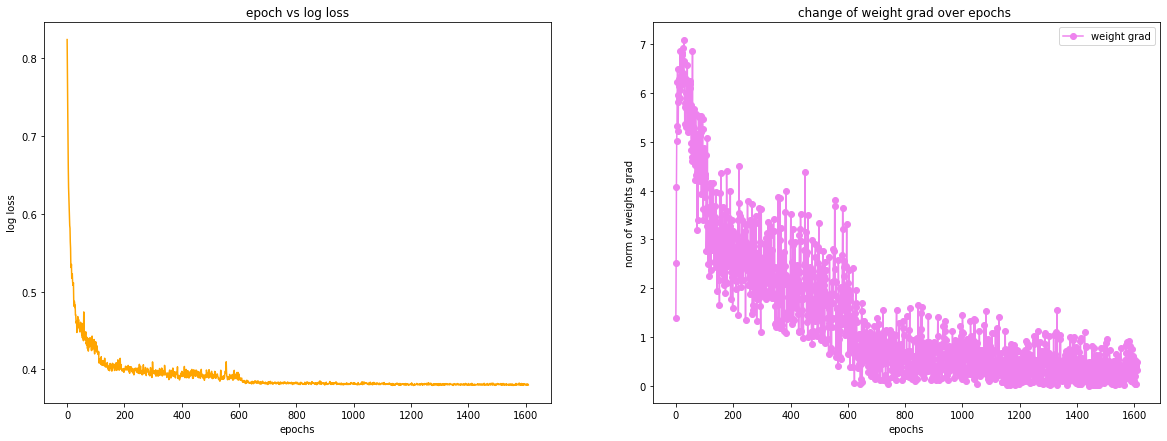

In [133]:
plot(loss,par)

T-SNE plot on the training dataset: 


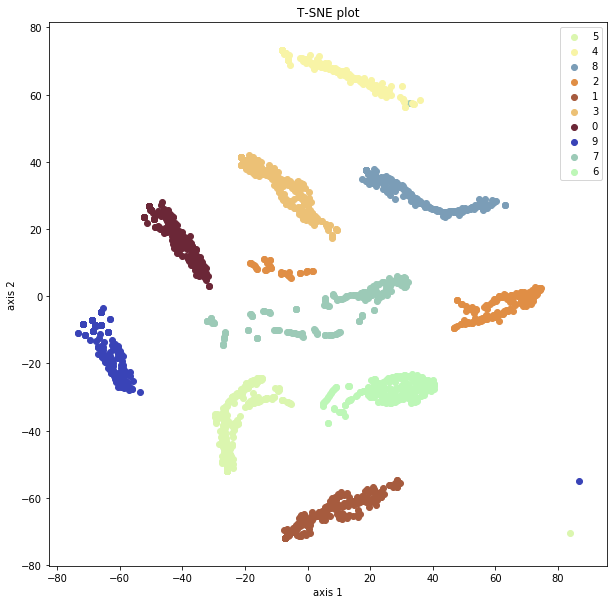

In [149]:
print("T-SNE plot on the training dataset: ")
tsne_map(traindl,modelcnn)


T-SNE plot on the testing dataset: 


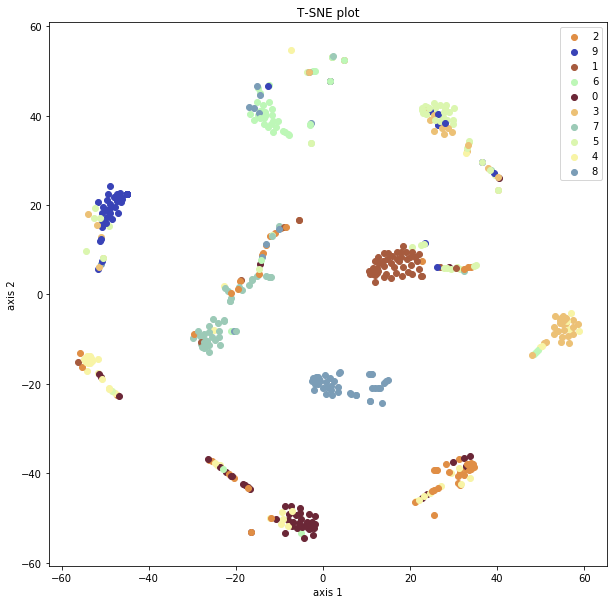

In [150]:
print("T-SNE plot on the testing dataset: ")
tsne_map(testdl,modelcnn)

In [144]:
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("validation accuracy:")
get_accuracy(valdl,modelcnn)

Training accuracy:
99.70000386238098 %
validation accuracy:
67.60563254356384 %


0.6760563254356384

In [145]:
print("Loss on test:")
test(modelcnn,testdl)
print("Training accuracy:")
get_accuracy(traindl,modelcnn)
print("Test accuracy:")
get_accuracy(testdl,modelcnn)
print("Training f1 score:")
get_f1(traindl,modelcnn)
print("Test f1 score:")
get_f1(testdl,modelcnn)

Loss on test:
1.7513818740844727
Training accuracy:
99.85000491142273 %
Test accuracy:
70.17892599105835 %
Training f1 score:
F1 score: 1.0
Test f1 score:
F1 score: 0.6998012065887451


0.6998012065887451

confusion matrix on the test dataset:


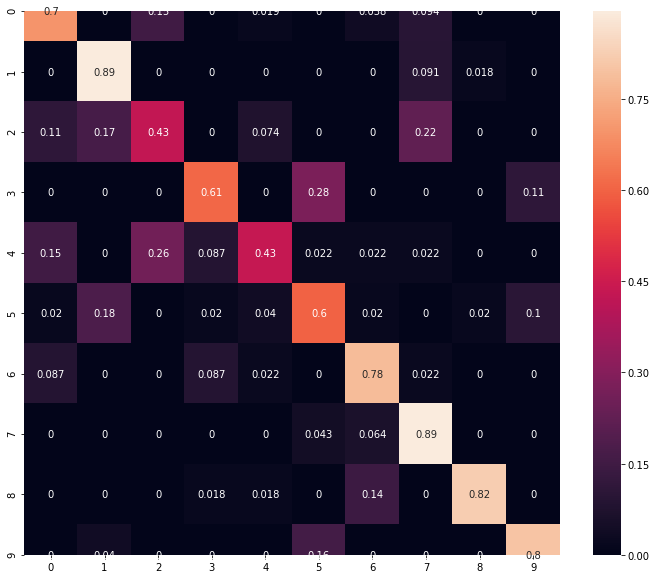

In [43]:
print("confusion matrix on the test dataset:")
confusionplot(testdl,modelcnn)

In [157]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl,modelcnn)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.78      0.79      0.79        53
           1       0.73      0.95      0.83        55
           2       0.59      0.48      0.53        54
           3       0.78      0.63      0.70        46
           4       0.70      0.41      0.52        46
           5       0.51      0.54      0.52        50
           6       0.64      0.80      0.71        46
           7       0.66      0.87      0.75        47
           8       0.93      0.75      0.83        56
           9       0.81      0.84      0.82        50

    accuracy                           0.71       503
   macro avg       0.71      0.71      0.70       503
weighted avg       0.72      0.71      0.70       503



### model 2: LSTM 

The data for the LSTM based model was prepared such that all the samples are of the size NX13,where N is the sequnce length of each sample.  

In [498]:
from torch.utils.data import Dataset, DataLoader
import os
class SDRDataset(Dataset):
    def __init__(self, metadata, type):
      self.metadata = metadata[metadata['split'] == type]
    def __len__(self):       
      return len(self.metadata)   
    def __getitem__(self, idx):        
      audio_file = self.metadata.iloc[idx]['identifier']      
      digit = self.metadata.iloc[idx]['label']        
      signal, sr = librosa.load(os.path.join("./speech_data",audio_file) + ".wav", sr=8000)  
      mel_spectrogram = extract_melspectrogram(signal, sr, num_mels=13)
      return torch.tensor(mel_spectrogram.T, dtype=torch.float32), torch.tensor(digit, dtype=torch.long)


In [499]:
train_dataset = SDRDataset(sdr_df, type = "TRAIN")
traindl2= DataLoader(train_dataset, batch_size=1, shuffle=True)
dev_dataset = SDRDataset(sdr_df, type = "DEV")
valdl2 = DataLoader(dev_dataset, batch_size=1, shuffle=True)
test_dataset = SDRDataset(sdr_df, type = "TEST")
testdl2 = DataLoader(test_dataset, batch_size=1, shuffle=True)

The LSTM architecture is having 3 bidirectional LSTM layers[5] followed by 3 Linear fully connected layers. Dropout layers are applied after every layer. the dropout probability is determined later during hyperparameter tuning.

In [500]:
class lstm(nn.Module):
     def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,op):
        super(lstm, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim
        self.op = op
        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim)
        # batch_dim = number of samples per batch
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout=self.op, bidirectional = True)#, nonlinearity='relu')

        # Readout layer
        self.fc1 = nn.Linear(hidden_dim * 2, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)
        self.drp = nn.Dropout(self.op) 
        self.softmax = nn.LogSoftmax(dim = 1)

     def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, _ = self.lstm(x, (h0.detach(),c0.detach()) )
        out = self.drp(self.fc1(out[:, -1, :])) 
        out = self.drp(self.fc2(out)) 
        out = self.drp(self.fc3(out)) 
        out = self.fc4(out) 
        return out
    
     
     
     def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01,opti='adam'):
            optidict={'adagrad':torch.optim.Adagrad(self.parameters(), lr=learning_rate),'adam':torch.optim.Adam(self.parameters(),lr=learning_rate),'sgd':torch.optim.SGD(self.parameters(), lr=learning_rate)}
            loss_fn = nn.CrossEntropyLoss()
            optimizer = optidict[opti]
            optimizer.weight_decay = lam #torch.optim.Adam(self.parameters(),lr=learning_rate,weight_decay=lam)
            lossrec=[]
            par_grad=[]
            for epoch in range(epochs):
                tloss=0
                total_grad=0
                for i,(xs,ys) in enumerate(train_loader):
                    xs=xs.to(device)
                    ys=ys.to(device)
                    pred = self.forward(xs.type(torch.FloatTensor).cuda())                
                    loss = loss_fn(pred,ys) 
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    grad=0
                    for p in self.parameters():
                        grad+=torch.norm(p.grad).item()

                    total_grad+=grad
                    tloss+=loss
                lossrec.append((tloss/len(train_loader)).log().item())
                par_grad.append((total_grad/len(train_loader)))
                print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item(),'grad:',(total_grad/len(train_loader)))
            return lossrec,par_grad

#### Tuning the Hyperparameters
The following script is for selecting the optimal values for the hyperparameter by training the model multiple times with the different set of hyperparameters and then evaluating them based on the validation loss obtained. The hyperparameter values that gives the lowest values for validation loss are reported.

In [502]:
##hyperparameter tuning
la2=0
optim2=''
op2=0
lams = [0.005,0.001,0.0005]
optis = ['adagrad','adam','sgd']
valoss=999
dp=[0.2,0.25,0.3]
for d in dp:
    for l in lams:
            for opt in optis:
                modellstm = lstm(13,300,3,10,d)
                modellstm.to(device)
                modellstm.train(traindl2,epochs = 20, learning_rate=0.001,lam=l,opti=opt)
                if valoss>test(modellstm,valdl2):
                    valoss=test(modellstm,valdl2)
                    print(valoss)
                    la2=l
                    optim2=opt
                    op2=d
print("optimal lambda",la2)
print("optimal optimiser",optim2) 
print("optimal dropout",op2) 

epoch: 0 loss: 1.886893630027771 grad: 24.39038729888611
epoch: 1 loss: 1.5090981721878052 grad: 41.07620384932973
epoch: 2 loss: 1.3562276363372803 grad: 44.392443139298805
epoch: 3 loss: 1.2639062404632568 grad: 45.47947036465509
epoch: 4 loss: 1.1482408046722412 grad: 50.137349739227766
epoch: 5 loss: 1.0123640298843384 grad: 54.042022064515855
epoch: 6 loss: 0.9259719848632812 grad: 59.89673644216315
epoch: 7 loss: 0.8652892708778381 grad: 60.82858336819418
epoch: 8 loss: 0.7831159830093384 grad: 63.69417482276467
epoch: 9 loss: 0.8378627300262451 grad: 92.0958751000449
epoch: 10 loss: 0.716705858707428 grad: 68.61127998859797
epoch: 11 loss: 0.6638830304145813 grad: 64.57827930551163
epoch: 12 loss: 0.6382091641426086 grad: 65.50871455176578
epoch: 13 loss: 0.5868451595306396 grad: 64.40863492850679
epoch: 14 loss: 0.5530391931533813 grad: 65.74960945257838
epoch: 15 loss: 0.5259122848510742 grad: 63.42939024004396
epoch: 16 loss: 0.4940769076347351 grad: 63.15122554482368
epoch: 

epoch: 16 loss: 0.2741161584854126 grad: 44.90490864710619
epoch: 17 loss: 0.2566972076892853 grad: 43.81845564775765
epoch: 18 loss: 0.2488875389099121 grad: 43.53845657509771
epoch: 19 loss: 0.23621152341365814 grad: 42.806852349341256
2.895931725943638
epoch: 0 loss: 2.2630372047424316 grad: 9.714893534599614
epoch: 1 loss: 2.160337209701538 grad: 10.680916811226735
epoch: 2 loss: 1.938913106918335 grad: 13.851092958130058
epoch: 3 loss: 1.8015302419662476 grad: 16.660034755979105
epoch: 4 loss: 1.471903920173645 grad: 18.54335288195086
epoch: 5 loss: 1.263859510421753 grad: 20.36273496691409
epoch: 6 loss: 1.048929214477539 grad: 20.38813972049688
epoch: 7 loss: 0.9586515426635742 grad: 20.9776068884634
epoch: 8 loss: 0.8033949136734009 grad: 20.55213015892556
epoch: 9 loss: 0.6453853249549866 grad: 18.330342341320122
epoch: 10 loss: 0.5698536038398743 grad: 18.6721711219038
epoch: 11 loss: 0.5267998576164246 grad: 17.67916250957267
epoch: 12 loss: 0.4259639382362366 grad: 14.81084

epoch: 13 loss: 2.3075172901153564 grad: 2.944606220914387
epoch: 14 loss: 2.3082430362701416 grad: 2.775676310799901
epoch: 15 loss: 2.318783760070801 grad: 3.9128976936571447
epoch: 16 loss: 2.1741890907287598 grad: 7.465703673995807
epoch: 17 loss: 2.1821539402008057 grad: 10.36352795276299
epoch: 18 loss: 2.0546836853027344 grad: 14.398540005312046
epoch: 19 loss: 1.9214600324630737 grad: 18.25691593069977
2.521530795040385
epoch: 0 loss: 2.306377649307251 grad: 3.9501442703443463
epoch: 1 loss: 2.3052256107330322 grad: 3.933023402115039
epoch: 2 loss: 2.303947687149048 grad: 3.935228604734584
epoch: 3 loss: 2.3037662506103516 grad: 3.948993161185412
epoch: 4 loss: 2.303488254547119 grad: 3.945362698295503
epoch: 5 loss: 2.30340313911438 grad: 3.938056806573295
epoch: 6 loss: 2.3046650886535645 grad: 3.929891029480903
epoch: 7 loss: 2.303152561187744 grad: 3.930841852853075
epoch: 8 loss: 2.302382230758667 grad: 3.929223407166777
epoch: 9 loss: 2.3032641410827637 grad: 3.9273784710

epoch: 10 loss: 2.302549362182617 grad: 4.100930197086302
epoch: 11 loss: 2.302765130996704 grad: 4.110909150035004
epoch: 12 loss: 2.302828311920166 grad: 4.107038731569017
epoch: 13 loss: 2.3034586906433105 grad: 4.104348873588373
epoch: 14 loss: 2.303367853164673 grad: 4.102570563305519
epoch: 15 loss: 2.3024497032165527 grad: 4.099266061108734
epoch: 16 loss: 2.3031704425811768 grad: 4.097881898522784
epoch: 17 loss: 2.302025318145752 grad: 4.087650120667647
epoch: 18 loss: 2.3026788234710693 grad: 4.092268724644789
epoch: 19 loss: 2.302828311920166 grad: 4.0964767718391375
2.3034831220715097
epoch: 0 loss: 2.112884283065796 grad: 17.46052364313608
epoch: 1 loss: 1.608406662940979 grad: 42.98734911277919
epoch: 2 loss: 1.237836241722107 grad: 60.82165473867754
epoch: 3 loss: 0.9945682287216187 grad: 69.29594862783674
epoch: 4 loss: 0.8483163714408875 grad: 67.34350027177926
epoch: 5 loss: 0.7278653979301453 grad: 67.18651735355841
epoch: 6 loss: 0.6485707759857178 grad: 69.47522427

In [507]:
la2=0.001
optim2 = 'adagrad'
op2 = 0.3

In [508]:
modellstm = lstm(13,300,3,10,op2)
modellstm.to(device)
losslstm=[]
parlstm=[]

In [509]:
total_params = sum(p.numel() for p in modellstm.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 5231460


In [569]:
loss2,par2=modellstm.train(traindl2,epochs = 200,learning_rate=0.0005,lam=la2,opti=optim2)#100-0.001 #50-0.05 #100-0.01 #300-0.005 #1260 -  
losslstm+=loss2
parlstm+=par2
print(test(modellstm,valdl2))

epoch: 0 loss: 0.29006949067115784 grad: 70.65696149330094
epoch: 1 loss: 0.100715272128582 grad: 37.94345529790228
epoch: 2 loss: 0.08786948770284653 grad: 30.114555227613142
epoch: 3 loss: 0.06301166862249374 grad: 22.884288541586983
epoch: 4 loss: 0.05710066109895706 grad: 19.201688987976027
epoch: 5 loss: 0.048478346318006516 grad: 15.353685103537712
epoch: 6 loss: 0.056079283356666565 grad: 24.159134450638557
epoch: 7 loss: 0.042572639882564545 grad: 13.056986032744682
epoch: 8 loss: 0.049222297966480255 grad: 16.85953566353665
epoch: 9 loss: 0.047547709196805954 grad: 15.586507278063625
epoch: 10 loss: 0.041832197457551956 grad: 15.428330295497107
epoch: 11 loss: 0.04456775635480881 grad: 15.049432995212184
epoch: 12 loss: 0.035782650113105774 grad: 11.638522618565055
epoch: 13 loss: 0.04854654148221016 grad: 23.163851177108075
epoch: 14 loss: 0.03994340822100639 grad: 12.766604673261888
epoch: 15 loss: 0.035150520503520966 grad: 11.186397932418574
epoch: 16 loss: 0.0268867500126

epoch: 134 loss: 0.0063383677043020725 grad: 4.1157003002583235
epoch: 135 loss: 0.01395602710545063 grad: 7.743097762263072
epoch: 136 loss: 0.00787433236837387 grad: 4.349870258460618
epoch: 137 loss: 0.007226372137665749 grad: 3.5826369116276
epoch: 138 loss: 0.0083105294033885 grad: 3.8315161836649905
epoch: 139 loss: 0.007267997600138187 grad: 4.225765592945624
epoch: 140 loss: 0.007672966457903385 grad: 3.54402501910101
epoch: 141 loss: 0.0096078896895051 grad: 6.221725997963756
epoch: 142 loss: 0.00738327344879508 grad: 3.632080308446554
epoch: 143 loss: 0.007084590382874012 grad: 4.148666499605571
epoch: 144 loss: 0.006681727711111307 grad: 3.307129414525299
epoch: 145 loss: 0.00866017583757639 grad: 3.9523965103977052
epoch: 146 loss: 0.008524087257683277 grad: 4.1665510044969
epoch: 147 loss: 0.006966063287109137 grad: 3.083062754160648
epoch: 148 loss: 0.00825642328709364 grad: 4.517117838983163
epoch: 149 loss: 0.02045331336557865 grad: 14.54707920203114
epoch: 150 loss: 0.

#### Training curves
The following shows the training curve for the LSTM based model trained with the optimal hyperparameter values. It can be observed that the loss reduces with time and also the norm of the gradient of the weights also comes closer to 0 after convergence. 

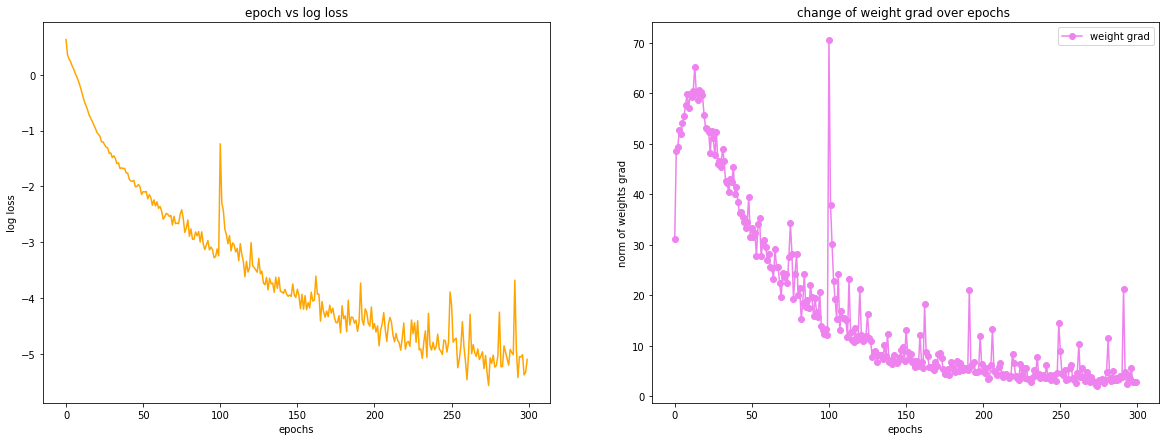

In [570]:
plot(losslstm,parlstm)

In [571]:
torch.save(modellstm,'D:/Saarland University/NNTI/project/models/modellstm.pt')

In [572]:
modellstm=torch.load('D:/Saarland University/NNTI/project/models/modellstm.pt')

T-SNE plot on the testing dataset:


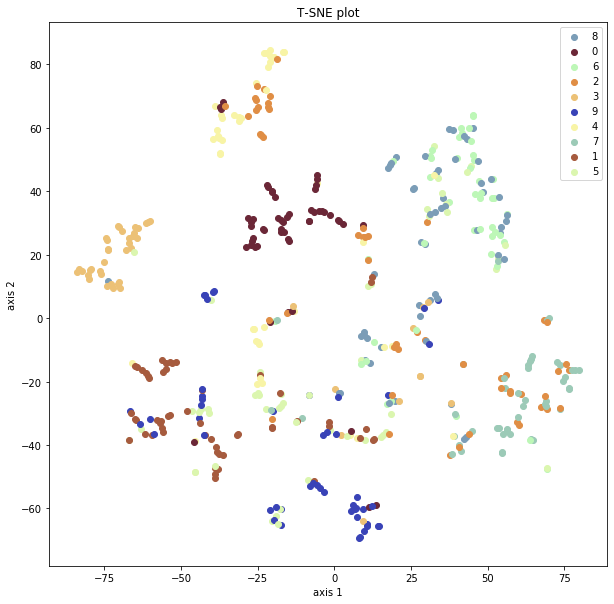

In [573]:
print("T-SNE plot on the testing dataset:")
tsne_map(testdl2,modellstm)

In [574]:
print("Training accuracy:")
get_accuracy(traindl2,modellstm)
print("validation accuracy:")
get_accuracy(valdl2,modellstm)

Training accuracy:
99.85000491142273 %
validation accuracy:
51.91146731376648 %


0.5191146731376648

In [622]:
print("Loss on test:")
test(modellstm,testdl2)
print("Training accuracy:")
get_accuracy(traindl2,modellstm)
print("Test accuracy:")
get_accuracy(testdl2,modellstm)
print("Training f1 score:")
get_f1(traindl2,modellstm)
print("Test f1 score:")
get_f1(testdl2,modellstm)

Loss on test:
4.605543970769243
Training accuracy:
99.9000072479248 %
Test accuracy:
52.08747386932373 %
Training f1 score:
F1 score: 0.9995
Test f1 score:
F1 score: 0.536779324055666


1.0

confusion matrix on the test dataset:


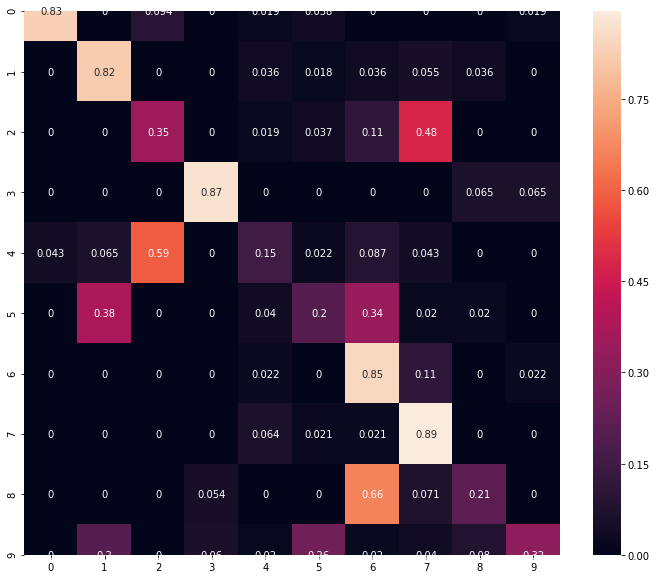

In [576]:
print("confusion matrix on the test dataset:")
confusionplot(testdl2,modellstm)

In [577]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl2,modellstm)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        53
           1       0.56      0.82      0.66        55
           2       0.41      0.39      0.40        54
           3       0.88      0.83      0.85        46
           4       0.41      0.15      0.22        46
           5       0.23      0.16      0.19        50
           6       0.36      0.83      0.50        46
           7       0.52      0.91      0.67        47
           8       0.36      0.14      0.21        56
           9       0.79      0.30      0.43        50

    accuracy                           0.53       503
   macro avg       0.55      0.54      0.50       503
weighted avg       0.55      0.53      0.50       503



## Model 3: GRU nodes


The GRU architecture is having 3 GRU layers[6] followed by 3 Linear fully connected layers. Dropout layers are applied after every layer. the dropout probability is determined later during hyperparameter tuning.

In [505]:
class gru(nn.Module):
     def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,op):
        super(gru, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.op = op
        self.lstm = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True,dropout=self.op, bidirectional = False)#, nonlinearity='relu')
        
        # Readout layer
        self.fc1 = nn.Linear(hidden_dim, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)
        self.drp = nn.Dropout(self.op) 

     def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, _ = self.lstm(x, h0.detach() )
        out = self.drp(self.fc1(out[:, -1, :])) 
        out = self.drp(self.fc2(out)) 
        out = self.drp(self.fc3(out)) 
        out = self.fc4(out) 
        return out
     
     def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01,opti='adam'):
            optidict={'adagrad':torch.optim.Adagrad(self.parameters(), lr=learning_rate),'adam':torch.optim.Adam(self.parameters(),lr=learning_rate),'sgd':torch.optim.SGD(self.parameters(), lr=learning_rate)}
            loss_fn = nn.CrossEntropyLoss()
            optimizer = optidict[opti]
            optimizer.weight_decay = lam #torch.optim.Adam(self.parameters(),lr=learning_rate,weight_decay=lam)
            lossrec=[]
            par_grad=[]
            for epoch in range(epochs):
                tloss=0
                total_grad=0
                for i,(xs,ys) in enumerate(train_loader):
                    xs=xs.to(device)
                    ys=ys.to(device)
                    pred = self.forward(xs.type(torch.FloatTensor).cuda())                
                    loss = loss_fn(pred,ys) 
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    grad=0
                    for p in self.parameters():
                        grad+=torch.norm(p.grad).item()

                    total_grad+=grad
                    tloss+=loss
                lossrec.append((tloss/len(train_loader)).log().item())
                par_grad.append((total_grad/len(train_loader)))
                print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item(),'grad:',(total_grad/len(train_loader)))
            return lossrec,par_grad

#### Tuning the Hyperparameters
The following script is for selecting the optimal values for the hyperparameter by training the model multiple times with the different set of hyperparameters and then evaluating them based on the validation loss obtained. The hyperparameter values that gives the lowest values for validation loss are reported.

In [506]:
##hyperparameter tuning
la3=0
optim3=''
op3=0
lams = [0.005,0.001,0.0005]
optis = ['adagrad','adam','sgd']
dp=[0.2,0.25,0.3]
valoss=999
for d in dp:
    for l in lams:
            for opt in optis:
                modelgru = gru(13,300,3,10,d)
                modelgru.to(device)
                modelgru.train(traindl2,epochs = 20, learning_rate=0.001,lam=l,opti=opt)
                if valoss>test(modelgru,valdl2):
                    valoss=test(modelgru,valdl2)
                    print(valoss)
                    la3=l
                    optim3=opt
                    op3=d

print("optimal lambda",la3)
print("optimal optimiser",optim3) 
print("optimal dropout",op3) 

epoch: 0 loss: 1.7856202125549316 grad: 27.84880131639936
epoch: 1 loss: 1.4441555738449097 grad: 40.70689341772627
epoch: 2 loss: 1.2757692337036133 grad: 44.192594334236
epoch: 3 loss: 1.1589734554290771 grad: 46.788749010769415
epoch: 4 loss: 1.0788260698318481 grad: 47.76001072949474
epoch: 5 loss: 1.0011959075927734 grad: 48.77970116989967
epoch: 6 loss: 0.9396648406982422 grad: 48.754435664050284
epoch: 7 loss: 0.8946279883384705 grad: 48.994496397767335
epoch: 8 loss: 0.8373995423316956 grad: 48.86666957046062
epoch: 9 loss: 0.7839179039001465 grad: 48.03751586283819
epoch: 10 loss: 0.7335975766181946 grad: 47.334648642257335
epoch: 11 loss: 0.6897276043891907 grad: 46.77948890905516
epoch: 12 loss: 0.6471343040466309 grad: 46.716038548893486
epoch: 13 loss: 0.6137343049049377 grad: 45.7118731013545
epoch: 14 loss: 0.5598127245903015 grad: 44.216803745553975
epoch: 15 loss: 0.5270741581916809 grad: 44.35322416058572
epoch: 16 loss: 0.5089881420135498 grad: 43.567652926186014
epo

epoch: 16 loss: 0.44288748502731323 grad: 41.85683545819364
epoch: 17 loss: 0.4287336468696594 grad: 42.75775927193831
epoch: 18 loss: 0.42176488041877747 grad: 41.866019275281175
epoch: 19 loss: 0.3894976079463959 grad: 39.973589790429195
1.9225804201951269
epoch: 0 loss: 1.7202337980270386 grad: 31.26142902672579
epoch: 1 loss: 0.788078784942627 grad: 29.220587387325647
epoch: 2 loss: 0.5592096447944641 grad: 24.406382968400916
epoch: 3 loss: 0.4656345248222351 grad: 21.843034961476803
epoch: 4 loss: 0.4299066662788391 grad: 21.921633366724233
epoch: 5 loss: 0.32148241996765137 grad: 18.48417718454964
epoch: 6 loss: 0.3550991415977478 grad: 20.505217564837377
epoch: 7 loss: 0.3338538110256195 grad: 20.3319923993439
epoch: 8 loss: 0.30977392196655273 grad: 19.333349570726337
epoch: 9 loss: 0.31869199872016907 grad: 20.303183399265997
epoch: 10 loss: 0.3380860686302185 grad: 22.55317016446735
epoch: 11 loss: 0.32694700360298157 grad: 23.06039809943519
epoch: 12 loss: 0.3490897715091705

epoch: 12 loss: 0.3957425653934479 grad: 23.618285645697693
epoch: 13 loss: 0.4070846438407898 grad: 25.867609221920368
epoch: 14 loss: 0.3233645558357239 grad: 24.780148674844266
epoch: 15 loss: 0.4531673789024353 grad: 31.102822365422437
epoch: 16 loss: 0.36091241240501404 grad: 23.783936792429543
epoch: 17 loss: 0.36214885115623474 grad: 26.48288272896824
epoch: 18 loss: 0.33529114723205566 grad: 24.4558421965783
epoch: 19 loss: 0.41186246275901794 grad: 29.578749520201175
6.064666621820429
epoch: 0 loss: 2.304198980331421 grad: 5.52162345301127
epoch: 1 loss: 2.3018813133239746 grad: 5.588463360508904
epoch: 2 loss: 2.2982871532440186 grad: 5.735841956838965
epoch: 3 loss: 2.2948684692382812 grad: 5.954993304458447
epoch: 4 loss: 2.2905421257019043 grad: 6.3071763280578885
epoch: 5 loss: 2.281625747680664 grad: 6.909874833306298
epoch: 6 loss: 2.269798755645752 grad: 7.8875790926832705
epoch: 7 loss: 2.2424988746643066 grad: 9.06841341610672
epoch: 8 loss: 2.1909399032592773 grad: 

epoch: 8 loss: 2.016057252883911 grad: 17.499211101057007
epoch: 9 loss: 1.849097490310669 grad: 24.069992690088228
epoch: 10 loss: 1.6659859418869019 grad: 30.814330939451583
epoch: 11 loss: 1.5731362104415894 grad: 36.01873979200283
epoch: 12 loss: 1.4886794090270996 grad: 38.527341115170856
epoch: 13 loss: 1.454525113105774 grad: 40.88369936203584
epoch: 14 loss: 1.3761563301086426 grad: 41.73264808942005
epoch: 15 loss: 1.2883497476577759 grad: 43.170345583171354
epoch: 16 loss: 1.1874593496322632 grad: 45.66879068114143
epoch: 17 loss: 1.1274690628051758 grad: 47.39908451693866
epoch: 18 loss: 1.103464961051941 grad: 48.71026367665333
epoch: 19 loss: 1.0691518783569336 grad: 47.76688225298366
2.435771085440895
epoch: 0 loss: 1.8789472579956055 grad: 27.959486121595372
epoch: 1 loss: 1.3924376964569092 grad: 43.379893261984805
epoch: 2 loss: 1.191699743270874 grad: 48.3197538423863
epoch: 3 loss: 1.0759263038635254 grad: 48.65398221433442
epoch: 4 loss: 0.9933781623840332 grad: 51.

In [511]:
modelgru = gru(13,300,3,10,op3)
modelgru.to(device)
lossgru=[]
pargru=[]

In [512]:
total_params = sum(p.numel() for p in modelgru.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 1452960


In [559]:
loss3,par3=modelgru.train(traindl2,epochs = 200,learning_rate=0.0005,lam=la3,opti=optim3) #100-0.001 #200-0.05 #500-0.005 #150-0.001

lossgru+=loss3
pargru+=par3
print(test(modelgru,valdl2))

epoch: 0 loss: 0.6332976222038269 grad: 133.79882162413293
epoch: 1 loss: 0.18335086107254028 grad: 58.917047492460014
epoch: 2 loss: 0.12488298118114471 grad: 49.44904610343962
epoch: 3 loss: 0.07201915979385376 grad: 37.364247169436105
epoch: 4 loss: 0.06383931636810303 grad: 27.2248356979623
epoch: 5 loss: 0.047340795397758484 grad: 23.00502389903448
epoch: 6 loss: 0.0375472828745842 grad: 16.6797374738456
epoch: 7 loss: 0.028213681653141975 grad: 12.85903928160482
epoch: 8 loss: 0.034599773585796356 grad: 13.366337544754526
epoch: 9 loss: 0.02229805663228035 grad: 9.968232261259969
epoch: 10 loss: 0.02132926695048809 grad: 8.642990513749075
epoch: 11 loss: 0.01735709048807621 grad: 10.448235379025034
epoch: 12 loss: 0.019435623660683632 grad: 10.196479083364949
epoch: 13 loss: 0.0168759785592556 grad: 7.218092347625197
epoch: 14 loss: 0.015266474336385727 grad: 6.749232732104528
epoch: 15 loss: 0.015245450660586357 grad: 5.402481257151225
epoch: 16 loss: 0.016001282259821892 grad: 

epoch: 133 loss: 0.004186295438557863 grad: 1.095335564123306
epoch: 134 loss: 0.006453741807490587 grad: 1.5441812869410396
epoch: 135 loss: 0.004052225966006517 grad: 1.3133600917262747
epoch: 136 loss: 0.004484320059418678 grad: 1.5995006839982935
epoch: 137 loss: 0.005967681761831045 grad: 1.7636549147096534
epoch: 138 loss: 0.004064831882715225 grad: 1.2765995761275657
epoch: 139 loss: 0.00463382201269269 grad: 1.3277035739609113
epoch: 140 loss: 0.0034560326021164656 grad: 1.1594324987771993
epoch: 141 loss: 0.004224528092890978 grad: 1.3424262380094267
epoch: 142 loss: 0.0056365192867815495 grad: 1.5216367649907723
epoch: 143 loss: 0.003946993965655565 grad: 1.3328328609371047
epoch: 144 loss: 0.003444319823756814 grad: 1.0082840847809644
epoch: 145 loss: 0.004156783223152161 grad: 1.2522371270836279
epoch: 146 loss: 0.0038189191836863756 grad: 1.4255046987363302
epoch: 147 loss: 0.004333038814365864 grad: 1.5998452011977937
epoch: 148 loss: 0.0032086982391774654 grad: 1.0142044

In [561]:
print(test(modelgru,valdl2))

5.831251793309299
5.831251793309299


#### Training curves
The following shows the training curve for the GRU based model trained with the optimal hyperparameter values. It can be observed that the loss reduces with time and also the norm of the gradient of the weights also comes closer to 0 after convergence. The convergence of the GRU architecture is faster than the LSTM network.

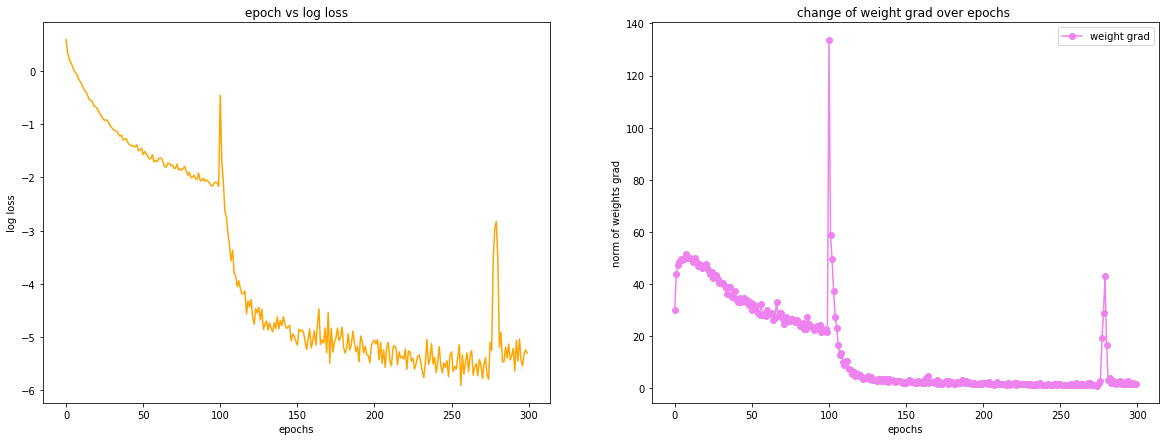

In [560]:
plot(lossgru,pargru)

In [578]:
torch.save(modelgru,'D:/Saarland University/NNTI/project/models/modelgru.pt')

In [579]:
modelgru=torch.load('D:/Saarland University/NNTI/project/models/modellstm.pt')

T-SNE plot on the testing dataset:


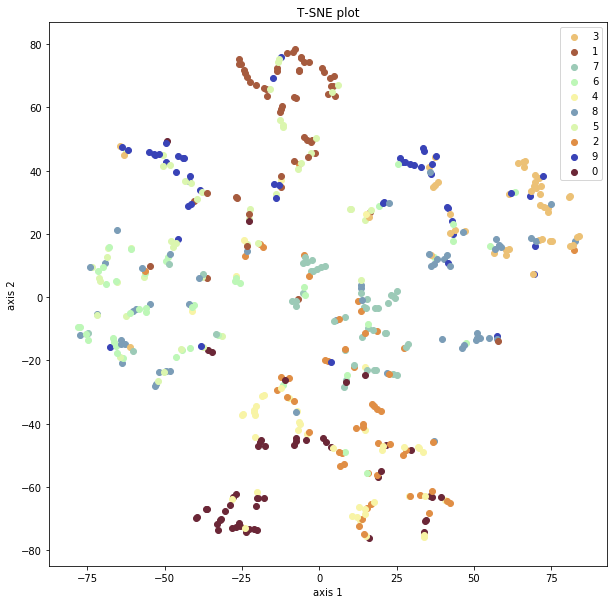

In [564]:
print("T-SNE plot on the testing dataset:")
tsne_map(testdl2,modelgru)

In [565]:
print("Training accuracy:")
get_accuracy(traindl2,modelgru)
print("validation accuracy:")
get_accuracy(valdl2,modelgru)

Training accuracy:
99.9500036239624 %
validation accuracy:
53.118711709976196 %


0.531187117099762

In [566]:
print("Loss on test:")
test(modelgru,testdl2)
print("Training accuracy:")
get_accuracy(traindl2,modelgru)
print("Test accuracy:")
get_accuracy(testdl2,modelgru)
print("Training f1 score:")
get_f1(traindl2,modelgru)
print("Test f1 score:")
get_f1(testdl2,modelgru)

Loss on test:
5.562884283624471
Training accuracy:
99.9000072479248 %
Test accuracy:
55.06957769393921 %
Training f1 score:
F1 score: 0.9995
Test f1 score:
F1 score: 0.5347912524850894


1.0

confusion matrix on the test dataset:


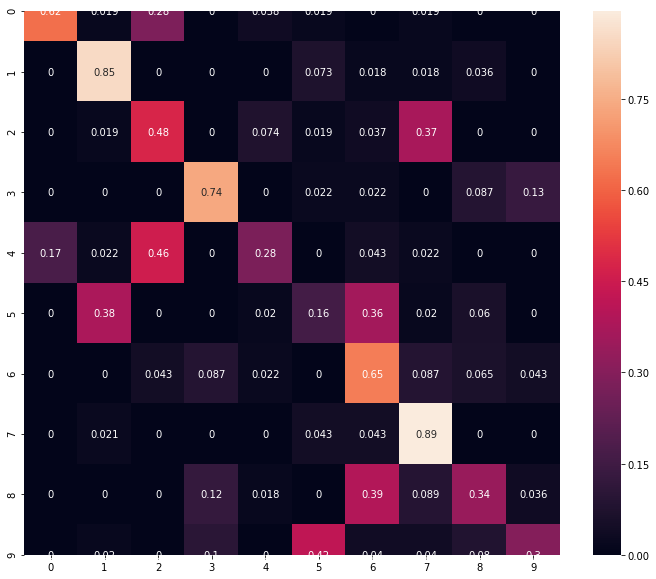

In [567]:
print("confusion matrix on the test dataset:")
confusionplot(testdl2,modelgru)

In [568]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl2,modelgru)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.85      0.64      0.73        53
           1       0.66      0.84      0.74        55
           2       0.41      0.52      0.46        54
           3       0.71      0.70      0.70        46
           4       0.58      0.24      0.34        46
           5       0.26      0.20      0.23        50
           6       0.36      0.63      0.46        46
           7       0.55      0.89      0.68        47
           8       0.53      0.34      0.41        56
           9       0.52      0.32      0.40        50

    accuracy                           0.53       503
   macro avg       0.54      0.53      0.51       503
weighted avg       0.54      0.53      0.52       503



## Analysing statistical significance Between models:
we tested the two best performing models for the analysis, namely the CNN based model and the GRU based model and also the baseline Linear is also compared

#### Creating bootstrapped Data.

In [595]:
acc=[]
for i in tqdm(range(503)):
    dummystats=np.zeros((1,melspectrogram.shape[0],maxlength+27))
    datadictstats = {'TEST':dummy}
    labeldictstats = {'TEST':[]}

    for j in range(503):
        idx = randint(0, 502)
        path = sdr_df[sdr_df['split']=='TEST']['file'].iloc[idx]
        label = sdr_df[sdr_df['split']=='TEST']['label'].iloc[idx]
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadictstats['TEST']=torch.tensor(np.concatenate((datadictstats['TEST'],data),axis=0))
        labeldictstats['TEST'].append(label)

    test_datastats = datadictstats['TEST'][1:] 
    test_ystats = labeldictstats['TEST']

    custom_test_dataset = customDataset(test_datastats, test_ystats)
    custom_test_loader = customDataLoader(custom_test_dataset, batch_size=503)
    testdlstats = custom_test_loader.loader()

    acc.append(get_accuracy(testdlstats,modelcnn))


70.37773132324219 %
72.76341915130615 %
73.95625710487366 %
69.98011469841003 %
75.94432830810547 %
70.37773132324219 %
72.16699719429016 %
72.365802526474 %
67.99204349517822 %
71.76938056945801 %
70.77534198760986 %
67.39562153816223 %
66.40158891677856 %
71.57057523727417 %
68.78727078437805 %
69.1848874092102 %
67.79323816299438 %
67.39562153816223 %
70.17892599105835 %
71.37176394462585 %
69.98011469841003 %
69.7813093662262 %
70.17892599105835 %
66.6003942489624 %
67.99204349517822 %
71.96818590164185 %
68.58846545219421 %
72.76341915130615 %
70.57653665542603 %
73.55864644050598 %
68.78727078437805 %
72.16699719429016 %
70.97415328025818 %
68.58846545219421 %
68.58846545219421 %
71.17295861244202 %
70.97415328025818 %
73.55864644050598 %
69.1848874092102 %
71.76938056945801 %
69.38369274139404 %
68.98608207702637 %
70.77534198760986 %
68.19085478782654 %
68.78727078437805 %
66.79919958114624 %
69.1848874092102 %
68.78727078437805 %
67.39562153816223 %
71.17295861244202 %
69.9801

70.37773132324219 %
68.78727078437805 %
67.59443283081055 %
68.98608207702637 %
69.1848874092102 %
69.98011469841003 %
66.40158891677856 %
71.96818590164185 %
73.35983514785767 %
72.16699719429016 %
69.98011469841003 %
72.16699719429016 %
73.55864644050598 %
69.58250403404236 %
67.39562153816223 %
71.37176394462585 %
69.98011469841003 %
70.97415328025818 %
73.35983514785767 %
69.7813093662262 %
75.5467176437378 %
70.37773132324219 %
74.15506839752197 %
71.96818590164185 %
71.37176394462585 %
69.1848874092102 %
69.38369274139404 %
69.1848874092102 %
69.98011469841003 %
68.98608207702637 %
70.77534198760986 %
69.1848874092102 %
69.7813093662262 %
71.37176394462585 %
72.96222448348999 %
68.58846545219421 %
72.16699719429016 %
70.97415328025818 %
69.7813093662262 %
70.97415328025818 %
71.96818590164185 %
73.55864644050598 %
66.79919958114624 %
66.99801087379456 %
69.7813093662262 %
67.79323816299438 %
73.16102981567383 %
72.16699719429016 %
72.76341915130615 %
71.17295861244202 %
68.588465

In [598]:
acc2=[]
for i in tqdm(range(503)):
    dummystats2=np.zeros((1,melspectrogram.shape[0],maxlength+27))
    datadictstats2 = {'TEST':dummy}
    labeldictstats2 = {'TEST':[]}
    test_datasetstats2 = SDRDataset(sdr_df, type = "TEST")
    testdl2stats2 = DataLoader(test_datasetstats2, batch_size=1, shuffle=True)##shuffle =True ensures resampling same samples
    acc2.append(get_accuracy(testdl2stats2,modelgru))



  0%|                                                                                          | 0/503 [00:00<?, ?it/s]

54.07554507255554 %




  0%|▏                                                                                 | 1/503 [00:03<26:13,  3.13s/it]

52.485084533691406 %




  0%|▎                                                                                 | 2/503 [00:05<25:27,  3.05s/it]

53.67792844772339 %




  1%|▍                                                                                 | 3/503 [00:08<24:52,  2.99s/it]

53.28031778335571 %




  1%|▋                                                                                 | 4/503 [00:11<24:28,  2.94s/it]

51.68985724449158 %




  1%|▊                                                                                 | 5/503 [00:14<24:15,  2.92s/it]

52.485084533691406 %




  1%|▉                                                                                 | 6/503 [00:17<24:05,  2.91s/it]

52.08747386932373 %




  1%|█▏                                                                                | 7/503 [00:20<24:13,  2.93s/it]

52.68389582633972 %




  2%|█▎                                                                                | 8/503 [00:23<24:07,  2.93s/it]

54.47315573692322 %




  2%|█▍                                                                                | 9/503 [00:26<24:03,  2.92s/it]

53.0815064907074 %




  2%|█▌                                                                               | 10/503 [00:29<24:08,  2.94s/it]

53.47912311553955 %




  2%|█▊                                                                               | 11/503 [00:32<23:56,  2.92s/it]

52.485084533691406 %




  2%|█▉                                                                               | 12/503 [00:35<23:56,  2.93s/it]

52.28627920150757 %




  3%|██                                                                               | 13/503 [00:37<23:51,  2.92s/it]

53.0815064907074 %




  3%|██▎                                                                              | 14/503 [00:40<23:44,  2.91s/it]

52.485084533691406 %




  3%|██▍                                                                              | 15/503 [00:43<23:55,  2.94s/it]

53.67792844772339 %




  3%|██▌                                                                              | 16/503 [00:46<23:57,  2.95s/it]

52.08747386932373 %




  3%|██▋                                                                              | 17/503 [00:49<23:44,  2.93s/it]

51.49105191230774 %




  4%|██▉                                                                              | 18/503 [00:52<23:38,  2.93s/it]

52.28627920150757 %




  4%|███                                                                              | 19/503 [00:55<23:24,  2.90s/it]

53.0815064907074 %




  4%|███▏                                                                             | 20/503 [00:58<23:19,  2.90s/it]

52.88270115852356 %




  4%|███▍                                                                             | 21/503 [01:01<23:13,  2.89s/it]

53.876739740371704 %




  4%|███▌                                                                             | 22/503 [01:04<23:08,  2.89s/it]

52.28627920150757 %




  5%|███▋                                                                             | 23/503 [01:06<23:02,  2.88s/it]

53.28031778335571 %




  5%|███▊                                                                             | 24/503 [01:09<23:01,  2.88s/it]

53.67792844772339 %




  5%|████                                                                             | 25/503 [01:12<22:55,  2.88s/it]

53.47912311553955 %




  5%|████▏                                                                            | 26/503 [01:15<22:56,  2.89s/it]

53.0815064907074 %




  5%|████▎                                                                            | 27/503 [01:18<22:48,  2.87s/it]

54.47315573692322 %




  6%|████▌                                                                            | 28/503 [01:21<22:45,  2.88s/it]

52.28627920150757 %




  6%|████▋                                                                            | 29/503 [01:24<22:41,  2.87s/it]

53.28031778335571 %




  6%|████▊                                                                            | 30/503 [01:27<22:40,  2.88s/it]

53.67792844772339 %




  6%|████▉                                                                            | 31/503 [01:29<22:36,  2.87s/it]

52.28627920150757 %




  6%|█████▏                                                                           | 32/503 [01:32<22:29,  2.87s/it]

52.485084533691406 %




  7%|█████▎                                                                           | 33/503 [01:35<22:24,  2.86s/it]

53.47912311553955 %




  7%|█████▍                                                                           | 34/503 [01:38<22:22,  2.86s/it]

53.28031778335571 %




  7%|█████▋                                                                           | 35/503 [01:41<22:24,  2.87s/it]

52.88270115852356 %




  7%|█████▊                                                                           | 36/503 [01:44<22:23,  2.88s/it]

54.07554507255554 %




  7%|█████▉                                                                           | 37/503 [01:47<22:16,  2.87s/it]

51.68985724449158 %




  8%|██████                                                                           | 38/503 [01:50<22:12,  2.87s/it]

53.47912311553955 %




  8%|██████▎                                                                          | 39/503 [01:52<22:12,  2.87s/it]

52.88270115852356 %




  8%|██████▍                                                                          | 40/503 [01:55<22:10,  2.87s/it]

54.07554507255554 %




  8%|██████▌                                                                          | 41/503 [01:58<22:12,  2.88s/it]

52.68389582633972 %




  8%|██████▊                                                                          | 42/503 [02:01<22:09,  2.88s/it]

52.28627920150757 %




  9%|██████▉                                                                          | 43/503 [02:04<22:08,  2.89s/it]

53.0815064907074 %




  9%|███████                                                                          | 44/503 [02:07<22:08,  2.89s/it]

52.28627920150757 %




  9%|███████▏                                                                         | 45/503 [02:10<22:04,  2.89s/it]

51.88866853713989 %




  9%|███████▍                                                                         | 46/503 [02:13<22:20,  2.93s/it]

52.88270115852356 %




  9%|███████▌                                                                         | 47/503 [02:16<22:24,  2.95s/it]

53.28031778335571 %




 10%|███████▋                                                                         | 48/503 [02:19<22:24,  2.96s/it]

52.485084533691406 %




 10%|███████▉                                                                         | 49/503 [02:22<22:28,  2.97s/it]

52.68389582633972 %




 10%|████████                                                                         | 50/503 [02:25<22:21,  2.96s/it]

52.485084533691406 %




 10%|████████▏                                                                        | 51/503 [02:28<22:20,  2.97s/it]

52.485084533691406 %




 10%|████████▎                                                                        | 52/503 [02:31<22:20,  2.97s/it]

52.68389582633972 %




 11%|████████▌                                                                        | 53/503 [02:34<22:05,  2.94s/it]

51.88866853713989 %




 11%|████████▋                                                                        | 54/503 [02:36<21:58,  2.94s/it]

53.28031778335571 %




 11%|████████▊                                                                        | 55/503 [02:39<22:04,  2.96s/it]

52.68389582633972 %




 11%|█████████                                                                        | 56/503 [02:42<21:54,  2.94s/it]

51.2922465801239 %




 11%|█████████▏                                                                       | 57/503 [02:45<21:43,  2.92s/it]

52.28627920150757 %




 12%|█████████▎                                                                       | 58/503 [02:48<21:42,  2.93s/it]

54.07554507255554 %




 12%|█████████▌                                                                       | 59/503 [02:51<21:35,  2.92s/it]

53.876739740371704 %




 12%|█████████▋                                                                       | 60/503 [02:54<21:34,  2.92s/it]

54.67196702957153 %




 12%|█████████▊                                                                       | 61/503 [02:57<21:26,  2.91s/it]

52.28627920150757 %




 12%|█████████▉                                                                       | 62/503 [03:00<21:29,  2.92s/it]

52.28627920150757 %




 13%|██████████▏                                                                      | 63/503 [03:03<21:27,  2.93s/it]

53.28031778335571 %




 13%|██████████▎                                                                      | 64/503 [03:06<21:20,  2.92s/it]

51.88866853713989 %




 13%|██████████▍                                                                      | 65/503 [03:09<21:14,  2.91s/it]

52.88270115852356 %




 13%|██████████▋                                                                      | 66/503 [03:11<21:06,  2.90s/it]

51.49105191230774 %




 13%|██████████▊                                                                      | 67/503 [03:14<21:04,  2.90s/it]

52.08747386932373 %




 14%|██████████▉                                                                      | 68/503 [03:17<21:18,  2.94s/it]

53.28031778335571 %




 14%|███████████                                                                      | 69/503 [03:20<21:20,  2.95s/it]

52.88270115852356 %




 14%|███████████▎                                                                     | 70/503 [03:23<21:27,  2.97s/it]

53.28031778335571 %




 14%|███████████▍                                                                     | 71/503 [03:26<21:14,  2.95s/it]

53.67792844772339 %




 14%|███████████▌                                                                     | 72/503 [03:29<21:10,  2.95s/it]

51.49105191230774 %




 15%|███████████▊                                                                     | 73/503 [03:32<21:07,  2.95s/it]

52.28627920150757 %




 15%|███████████▉                                                                     | 74/503 [03:35<20:59,  2.94s/it]

53.28031778335571 %




 15%|████████████                                                                     | 75/503 [03:38<20:55,  2.93s/it]

53.47912311553955 %




 15%|████████████▏                                                                    | 76/503 [03:41<20:51,  2.93s/it]

52.68389582633972 %




 15%|████████████▍                                                                    | 77/503 [03:44<20:43,  2.92s/it]

52.88270115852356 %




 16%|████████████▌                                                                    | 78/503 [03:47<20:53,  2.95s/it]

53.28031778335571 %




 16%|████████████▋                                                                    | 79/503 [03:50<20:49,  2.95s/it]

52.68389582633972 %




 16%|████████████▉                                                                    | 80/503 [03:53<20:41,  2.93s/it]

53.47912311553955 %




 16%|█████████████                                                                    | 81/503 [03:56<20:34,  2.93s/it]

52.88270115852356 %




 16%|█████████████▏                                                                   | 82/503 [03:59<20:35,  2.94s/it]

52.485084533691406 %




 17%|█████████████▎                                                                   | 83/503 [04:01<20:28,  2.93s/it]

52.08747386932373 %




 17%|█████████████▌                                                                   | 84/503 [04:04<20:18,  2.91s/it]

52.68389582633972 %




 17%|█████████████▋                                                                   | 85/503 [04:07<20:16,  2.91s/it]

53.28031778335571 %




 17%|█████████████▊                                                                   | 86/503 [04:10<20:15,  2.92s/it]

51.88866853713989 %




 17%|██████████████                                                                   | 87/503 [04:13<20:09,  2.91s/it]

51.68985724449158 %




 17%|██████████████▏                                                                  | 88/503 [04:16<20:04,  2.90s/it]

52.28627920150757 %




 18%|██████████████▎                                                                  | 89/503 [04:19<20:08,  2.92s/it]

52.485084533691406 %




 18%|██████████████▍                                                                  | 90/503 [04:22<20:11,  2.93s/it]

51.2922465801239 %




 18%|██████████████▋                                                                  | 91/503 [04:25<20:03,  2.92s/it]

53.67792844772339 %




 18%|██████████████▊                                                                  | 92/503 [04:28<20:01,  2.92s/it]

51.2922465801239 %




 18%|██████████████▉                                                                  | 93/503 [04:31<20:03,  2.93s/it]

51.68985724449158 %




 19%|███████████████▏                                                                 | 94/503 [04:34<20:05,  2.95s/it]

53.876739740371704 %




 19%|███████████████▎                                                                 | 95/503 [04:37<19:56,  2.93s/it]

53.67792844772339 %




 19%|███████████████▍                                                                 | 96/503 [04:40<20:01,  2.95s/it]

52.485084533691406 %




 19%|███████████████▌                                                                 | 97/503 [04:42<19:56,  2.95s/it]

53.0815064907074 %




 19%|███████████████▊                                                                 | 98/503 [04:45<19:45,  2.93s/it]

52.88270115852356 %




 20%|███████████████▉                                                                 | 99/503 [04:48<20:02,  2.98s/it]

53.876739740371704 %




 20%|███████████████▉                                                                | 100/503 [04:51<20:00,  2.98s/it]

52.08747386932373 %




 20%|████████████████                                                                | 101/503 [04:54<19:50,  2.96s/it]

52.68389582633972 %




 20%|████████████████▏                                                               | 102/503 [04:57<19:40,  2.94s/it]

53.0815064907074 %




 20%|████████████████▍                                                               | 103/503 [05:00<19:27,  2.92s/it]

51.49105191230774 %




 21%|████████████████▌                                                               | 104/503 [05:03<19:26,  2.92s/it]

51.49105191230774 %




 21%|████████████████▋                                                               | 105/503 [05:06<19:17,  2.91s/it]

51.88866853713989 %




 21%|████████████████▊                                                               | 106/503 [05:09<19:26,  2.94s/it]

52.68389582633972 %




 21%|█████████████████                                                               | 107/503 [05:12<19:24,  2.94s/it]

52.08747386932373 %




 21%|█████████████████▏                                                              | 108/503 [05:15<19:32,  2.97s/it]

52.08747386932373 %




 22%|█████████████████▎                                                              | 109/503 [05:18<19:26,  2.96s/it]

52.08747386932373 %




 22%|█████████████████▍                                                              | 110/503 [05:21<19:20,  2.95s/it]

52.485084533691406 %




 22%|█████████████████▋                                                              | 111/503 [05:24<19:13,  2.94s/it]

53.876739740371704 %




 22%|█████████████████▊                                                              | 112/503 [05:27<19:12,  2.95s/it]

52.88270115852356 %




 22%|█████████████████▉                                                              | 113/503 [05:30<19:18,  2.97s/it]

53.47912311553955 %




 23%|██████████████████▏                                                             | 114/503 [05:33<19:08,  2.95s/it]

53.28031778335571 %




 23%|██████████████████▎                                                             | 115/503 [05:35<18:57,  2.93s/it]

52.485084533691406 %




 23%|██████████████████▍                                                             | 116/503 [05:38<18:53,  2.93s/it]

52.08747386932373 %




 23%|██████████████████▌                                                             | 117/503 [05:41<19:06,  2.97s/it]

52.08747386932373 %




 23%|██████████████████▊                                                             | 118/503 [05:44<19:11,  2.99s/it]

51.88866853713989 %




 24%|██████████████████▉                                                             | 119/503 [05:48<19:22,  3.03s/it]

52.08747386932373 %




 24%|███████████████████                                                             | 120/503 [05:51<19:20,  3.03s/it]

52.88270115852356 %




 24%|███████████████████▏                                                            | 121/503 [05:54<19:13,  3.02s/it]

52.28627920150757 %




 24%|███████████████████▍                                                            | 122/503 [05:57<19:13,  3.03s/it]

53.47912311553955 %




 24%|███████████████████▌                                                            | 123/503 [06:00<19:05,  3.01s/it]

52.68389582633972 %




 25%|███████████████████▋                                                            | 124/503 [06:03<19:05,  3.02s/it]

52.08747386932373 %




 25%|███████████████████▉                                                            | 125/503 [06:06<18:59,  3.01s/it]

52.88270115852356 %




 25%|████████████████████                                                            | 126/503 [06:09<19:07,  3.04s/it]

52.08747386932373 %




 25%|████████████████████▏                                                           | 127/503 [06:12<18:50,  3.01s/it]

54.27435040473938 %




 25%|████████████████████▎                                                           | 128/503 [06:15<18:45,  3.00s/it]

52.28627920150757 %




 26%|████████████████████▌                                                           | 129/503 [06:18<18:41,  3.00s/it]

52.68389582633972 %




 26%|████████████████████▋                                                           | 130/503 [06:21<18:37,  3.00s/it]

52.68389582633972 %




 26%|████████████████████▊                                                           | 131/503 [06:24<18:28,  2.98s/it]

53.876739740371704 %




 26%|████████████████████▉                                                           | 132/503 [06:27<18:19,  2.96s/it]

51.49105191230774 %




 26%|█████████████████████▏                                                          | 133/503 [06:30<18:14,  2.96s/it]

53.0815064907074 %




 27%|█████████████████████▎                                                          | 134/503 [06:33<18:26,  3.00s/it]

52.68389582633972 %




 27%|█████████████████████▍                                                          | 135/503 [06:36<18:23,  3.00s/it]

53.0815064907074 %




 27%|█████████████████████▋                                                          | 136/503 [06:39<18:25,  3.01s/it]

53.28031778335571 %




 27%|█████████████████████▊                                                          | 137/503 [06:42<18:19,  3.00s/it]

52.68389582633972 %




 27%|█████████████████████▉                                                          | 138/503 [06:45<18:08,  2.98s/it]

53.47912311553955 %




 28%|██████████████████████                                                          | 139/503 [06:48<18:01,  2.97s/it]

53.28031778335571 %




 28%|██████████████████████▎                                                         | 140/503 [06:51<18:05,  2.99s/it]

51.49105191230774 %




 28%|██████████████████████▍                                                         | 141/503 [06:53<17:53,  2.96s/it]

52.485084533691406 %




 28%|██████████████████████▌                                                         | 142/503 [06:56<17:54,  2.98s/it]

53.0815064907074 %




 28%|██████████████████████▋                                                         | 143/503 [07:00<18:04,  3.01s/it]

52.88270115852356 %




 29%|██████████████████████▉                                                         | 144/503 [07:03<18:00,  3.01s/it]

50.69582462310791 %




 29%|███████████████████████                                                         | 145/503 [07:05<17:44,  2.97s/it]

52.28627920150757 %




 29%|███████████████████████▏                                                        | 146/503 [07:08<17:36,  2.96s/it]

54.07554507255554 %




 29%|███████████████████████▍                                                        | 147/503 [07:11<17:30,  2.95s/it]

51.49105191230774 %




 29%|███████████████████████▌                                                        | 148/503 [07:14<17:26,  2.95s/it]

53.67792844772339 %




 30%|███████████████████████▋                                                        | 149/503 [07:17<17:22,  2.94s/it]

53.47912311553955 %




 30%|███████████████████████▊                                                        | 150/503 [07:20<17:20,  2.95s/it]

51.88866853713989 %




 30%|████████████████████████                                                        | 151/503 [07:23<17:14,  2.94s/it]

53.0815064907074 %




 30%|████████████████████████▏                                                       | 152/503 [07:26<17:20,  2.96s/it]

53.876739740371704 %




 30%|████████████████████████▎                                                       | 153/503 [07:29<17:14,  2.96s/it]

52.485084533691406 %




 31%|████████████████████████▍                                                       | 154/503 [07:32<17:06,  2.94s/it]

51.49105191230774 %




 31%|████████████████████████▋                                                       | 155/503 [07:35<17:09,  2.96s/it]

53.876739740371704 %




 31%|████████████████████████▊                                                       | 156/503 [07:38<17:06,  2.96s/it]

51.49105191230774 %




 31%|████████████████████████▉                                                       | 157/503 [07:41<17:01,  2.95s/it]

52.88270115852356 %




 31%|█████████████████████████▏                                                      | 158/503 [07:44<16:57,  2.95s/it]

52.28627920150757 %




 32%|█████████████████████████▎                                                      | 159/503 [07:47<16:48,  2.93s/it]

51.88866853713989 %




 32%|█████████████████████████▍                                                      | 160/503 [07:50<16:45,  2.93s/it]

52.28627920150757 %




 32%|█████████████████████████▌                                                      | 161/503 [07:52<16:40,  2.93s/it]

53.0815064907074 %




 32%|█████████████████████████▊                                                      | 162/503 [07:55<16:37,  2.93s/it]

52.08747386932373 %




 32%|█████████████████████████▉                                                      | 163/503 [07:58<16:32,  2.92s/it]

53.0815064907074 %




 33%|██████████████████████████                                                      | 164/503 [08:01<16:29,  2.92s/it]

52.485084533691406 %




 33%|██████████████████████████▏                                                     | 165/503 [08:04<16:31,  2.93s/it]

53.0815064907074 %




 33%|██████████████████████████▍                                                     | 166/503 [08:07<16:25,  2.93s/it]

51.68985724449158 %




 33%|██████████████████████████▌                                                     | 167/503 [08:10<16:24,  2.93s/it]

53.47912311553955 %




 33%|██████████████████████████▋                                                     | 168/503 [08:13<16:28,  2.95s/it]

52.08747386932373 %




 34%|██████████████████████████▉                                                     | 169/503 [08:16<16:30,  2.97s/it]

53.47912311553955 %




 34%|███████████████████████████                                                     | 170/503 [08:19<16:26,  2.96s/it]

52.08747386932373 %




 34%|███████████████████████████▏                                                    | 171/503 [08:22<16:37,  3.00s/it]

53.28031778335571 %




 34%|███████████████████████████▎                                                    | 172/503 [08:25<16:26,  2.98s/it]

53.28031778335571 %




 34%|███████████████████████████▌                                                    | 173/503 [08:28<16:34,  3.01s/it]

54.07554507255554 %




 35%|███████████████████████████▋                                                    | 174/503 [08:31<16:34,  3.02s/it]

51.68985724449158 %




 35%|███████████████████████████▊                                                    | 175/503 [08:34<16:25,  3.00s/it]

53.28031778335571 %




 35%|███████████████████████████▉                                                    | 176/503 [08:37<16:20,  3.00s/it]

52.28627920150757 %




 35%|████████████████████████████▏                                                   | 177/503 [08:40<16:13,  2.99s/it]

52.485084533691406 %




 35%|████████████████████████████▎                                                   | 178/503 [08:43<16:03,  2.97s/it]

51.88866853713989 %




 36%|████████████████████████████▍                                                   | 179/503 [08:46<15:57,  2.96s/it]

54.27435040473938 %




 36%|████████████████████████████▋                                                   | 180/503 [08:49<15:52,  2.95s/it]

53.67792844772339 %




 36%|████████████████████████████▊                                                   | 181/503 [08:52<15:46,  2.94s/it]

53.28031778335571 %




 36%|████████████████████████████▉                                                   | 182/503 [08:55<15:48,  2.95s/it]

52.88270115852356 %




 36%|█████████████████████████████                                                   | 183/503 [08:58<15:42,  2.94s/it]

53.67792844772339 %




 37%|█████████████████████████████▎                                                  | 184/503 [09:01<15:40,  2.95s/it]

52.68389582633972 %




 37%|█████████████████████████████▍                                                  | 185/503 [09:04<15:34,  2.94s/it]

52.485084533691406 %




 37%|█████████████████████████████▌                                                  | 186/503 [09:06<15:30,  2.93s/it]

51.88866853713989 %




 37%|█████████████████████████████▋                                                  | 187/503 [09:09<15:25,  2.93s/it]

50.69582462310791 %




 37%|█████████████████████████████▉                                                  | 188/503 [09:12<15:24,  2.93s/it]

51.88866853713989 %




 38%|██████████████████████████████                                                  | 189/503 [09:15<15:20,  2.93s/it]

50.497013330459595 %




 38%|██████████████████████████████▏                                                 | 190/503 [09:18<15:22,  2.95s/it]

51.49105191230774 %




 38%|██████████████████████████████▍                                                 | 191/503 [09:21<15:17,  2.94s/it]

51.88866853713989 %




 38%|██████████████████████████████▌                                                 | 192/503 [09:24<15:16,  2.95s/it]

52.68389582633972 %




 38%|██████████████████████████████▋                                                 | 193/503 [09:27<15:09,  2.93s/it]

54.27435040473938 %




 39%|██████████████████████████████▊                                                 | 194/503 [09:30<15:08,  2.94s/it]

54.07554507255554 %




 39%|███████████████████████████████                                                 | 195/503 [09:33<15:01,  2.93s/it]

52.08747386932373 %




 39%|███████████████████████████████▏                                                | 196/503 [09:36<14:57,  2.92s/it]

52.68389582633972 %




 39%|███████████████████████████████▎                                                | 197/503 [09:39<14:56,  2.93s/it]

53.0815064907074 %




 39%|███████████████████████████████▍                                                | 198/503 [09:42<14:53,  2.93s/it]

52.68389582633972 %




 40%|███████████████████████████████▋                                                | 199/503 [09:45<14:53,  2.94s/it]

52.08747386932373 %




 40%|███████████████████████████████▊                                                | 200/503 [09:48<14:49,  2.94s/it]

53.47912311553955 %




 40%|███████████████████████████████▉                                                | 201/503 [09:50<14:44,  2.93s/it]

52.88270115852356 %




 40%|████████████████████████████████▏                                               | 202/503 [09:53<14:39,  2.92s/it]

51.68985724449158 %




 40%|████████████████████████████████▎                                               | 203/503 [09:56<14:33,  2.91s/it]

52.68389582633972 %




 41%|████████████████████████████████▍                                               | 204/503 [09:59<14:35,  2.93s/it]

53.0815064907074 %




 41%|████████████████████████████████▌                                               | 205/503 [10:02<14:28,  2.91s/it]

52.08747386932373 %




 41%|████████████████████████████████▊                                               | 206/503 [10:05<14:27,  2.92s/it]

52.08747386932373 %




 41%|████████████████████████████████▉                                               | 207/503 [10:08<14:22,  2.91s/it]

52.28627920150757 %




 41%|█████████████████████████████████                                               | 208/503 [10:11<14:18,  2.91s/it]

52.88270115852356 %




 42%|█████████████████████████████████▏                                              | 209/503 [10:14<14:19,  2.92s/it]

54.07554507255554 %




 42%|█████████████████████████████████▍                                              | 210/503 [10:17<14:17,  2.93s/it]

52.88270115852356 %




 42%|█████████████████████████████████▌                                              | 211/503 [10:20<14:11,  2.91s/it]

52.68389582633972 %




 42%|█████████████████████████████████▋                                              | 212/503 [10:23<14:06,  2.91s/it]

51.88866853713989 %




 42%|█████████████████████████████████▉                                              | 213/503 [10:25<14:02,  2.91s/it]

52.68389582633972 %




 43%|██████████████████████████████████                                              | 214/503 [10:28<14:01,  2.91s/it]

53.47912311553955 %




 43%|██████████████████████████████████▏                                             | 215/503 [10:31<13:56,  2.90s/it]

53.67792844772339 %




 43%|██████████████████████████████████▎                                             | 216/503 [10:34<14:04,  2.94s/it]

52.88270115852356 %




 43%|██████████████████████████████████▌                                             | 217/503 [10:37<14:08,  2.97s/it]

52.08747386932373 %




 43%|██████████████████████████████████▋                                             | 218/503 [10:40<14:05,  2.97s/it]

51.2922465801239 %




 44%|██████████████████████████████████▊                                             | 219/503 [10:43<13:59,  2.96s/it]

52.68389582633972 %




 44%|██████████████████████████████████▉                                             | 220/503 [10:46<13:53,  2.95s/it]

52.08747386932373 %




 44%|███████████████████████████████████▏                                            | 221/503 [10:49<13:50,  2.94s/it]

52.68389582633972 %




 44%|███████████████████████████████████▎                                            | 222/503 [10:52<13:46,  2.94s/it]

52.28627920150757 %




 44%|███████████████████████████████████▍                                            | 223/503 [10:55<13:49,  2.96s/it]

53.67792844772339 %




 45%|███████████████████████████████████▋                                            | 224/503 [10:58<13:52,  2.98s/it]

51.2922465801239 %




 45%|███████████████████████████████████▊                                            | 225/503 [11:01<14:00,  3.02s/it]

52.28627920150757 %




 45%|███████████████████████████████████▉                                            | 226/503 [11:04<13:57,  3.02s/it]

53.0815064907074 %




 45%|████████████████████████████████████                                            | 227/503 [11:07<13:55,  3.03s/it]

52.28627920150757 %




 45%|████████████████████████████████████▎                                           | 228/503 [11:10<13:52,  3.03s/it]

51.68985724449158 %




 46%|████████████████████████████████████▍                                           | 229/503 [11:13<13:47,  3.02s/it]

52.88270115852356 %




 46%|████████████████████████████████████▌                                           | 230/503 [11:16<13:42,  3.01s/it]

53.876739740371704 %




 46%|████████████████████████████████████▋                                           | 231/503 [11:19<13:39,  3.01s/it]

52.08747386932373 %




 46%|████████████████████████████████████▉                                           | 232/503 [11:22<13:37,  3.02s/it]

51.88866853713989 %




 46%|█████████████████████████████████████                                           | 233/503 [11:25<13:29,  3.00s/it]

53.0815064907074 %




 47%|█████████████████████████████████████▏                                          | 234/503 [11:28<13:27,  3.00s/it]

52.485084533691406 %




 47%|█████████████████████████████████████▍                                          | 235/503 [11:31<13:27,  3.01s/it]

52.485084533691406 %




 47%|█████████████████████████████████████▌                                          | 236/503 [11:34<13:26,  3.02s/it]

52.485084533691406 %




 47%|█████████████████████████████████████▋                                          | 237/503 [11:37<13:13,  2.98s/it]

53.67792844772339 %




 47%|█████████████████████████████████████▊                                          | 238/503 [11:40<13:07,  2.97s/it]

51.68985724449158 %




 48%|██████████████████████████████████████                                          | 239/503 [11:43<12:59,  2.95s/it]

51.68985724449158 %




 48%|██████████████████████████████████████▏                                         | 240/503 [11:46<12:56,  2.95s/it]

51.49105191230774 %




 48%|██████████████████████████████████████▎                                         | 241/503 [11:49<12:57,  2.97s/it]

53.876739740371704 %




 48%|██████████████████████████████████████▍                                         | 242/503 [11:52<12:49,  2.95s/it]

52.485084533691406 %




 48%|██████████████████████████████████████▋                                         | 243/503 [11:55<12:43,  2.94s/it]

54.07554507255554 %




 49%|██████████████████████████████████████▊                                         | 244/503 [11:58<12:40,  2.94s/it]

53.47912311553955 %




 49%|██████████████████████████████████████▉                                         | 245/503 [12:01<12:39,  2.94s/it]

50.89462995529175 %




 49%|███████████████████████████████████████▏                                        | 246/503 [12:04<12:34,  2.94s/it]

51.88866853713989 %




 49%|███████████████████████████████████████▎                                        | 247/503 [12:07<12:28,  2.92s/it]

52.08747386932373 %




 49%|███████████████████████████████████████▍                                        | 248/503 [12:09<12:27,  2.93s/it]

52.28627920150757 %




 50%|███████████████████████████████████████▌                                        | 249/503 [12:12<12:27,  2.94s/it]

53.28031778335571 %




 50%|███████████████████████████████████████▊                                        | 250/503 [12:15<12:22,  2.94s/it]

52.28627920150757 %




 50%|███████████████████████████████████████▉                                        | 251/503 [12:18<12:16,  2.92s/it]

52.88270115852356 %




 50%|████████████████████████████████████████                                        | 252/503 [12:21<12:16,  2.93s/it]

53.28031778335571 %




 50%|████████████████████████████████████████▏                                       | 253/503 [12:24<12:10,  2.92s/it]

53.67792844772339 %




 50%|████████████████████████████████████████▍                                       | 254/503 [12:27<12:07,  2.92s/it]

53.28031778335571 %




 51%|████████████████████████████████████████▌                                       | 255/503 [12:30<12:09,  2.94s/it]

53.876739740371704 %




 51%|████████████████████████████████████████▋                                       | 256/503 [12:33<12:02,  2.92s/it]

53.47912311553955 %




 51%|████████████████████████████████████████▊                                       | 257/503 [12:36<11:57,  2.91s/it]

52.88270115852356 %




 51%|█████████████████████████████████████████                                       | 258/503 [12:39<11:52,  2.91s/it]

52.68389582633972 %




 51%|█████████████████████████████████████████▏                                      | 259/503 [12:42<11:54,  2.93s/it]

51.68985724449158 %




 52%|█████████████████████████████████████████▎                                      | 260/503 [12:45<11:52,  2.93s/it]

52.68389582633972 %




 52%|█████████████████████████████████████████▌                                      | 261/503 [12:48<11:48,  2.93s/it]

51.49105191230774 %




 52%|█████████████████████████████████████████▋                                      | 262/503 [12:50<11:42,  2.92s/it]

53.47912311553955 %




 52%|█████████████████████████████████████████▊                                      | 263/503 [12:53<11:37,  2.91s/it]

52.08747386932373 %




 52%|█████████████████████████████████████████▉                                      | 264/503 [12:56<11:34,  2.91s/it]

52.68389582633972 %




 53%|██████████████████████████████████████████▏                                     | 265/503 [12:59<11:35,  2.92s/it]

52.68389582633972 %




 53%|██████████████████████████████████████████▎                                     | 266/503 [13:02<11:33,  2.93s/it]

52.485084533691406 %




 53%|██████████████████████████████████████████▍                                     | 267/503 [13:05<11:34,  2.94s/it]

53.47912311553955 %




 53%|██████████████████████████████████████████▌                                     | 268/503 [13:08<11:29,  2.93s/it]

52.08747386932373 %




 53%|██████████████████████████████████████████▊                                     | 269/503 [13:11<11:25,  2.93s/it]

53.67792844772339 %




 54%|██████████████████████████████████████████▉                                     | 270/503 [13:14<11:21,  2.93s/it]

52.08747386932373 %




 54%|███████████████████████████████████████████                                     | 271/503 [13:17<11:20,  2.93s/it]

54.07554507255554 %




 54%|███████████████████████████████████████████▎                                    | 272/503 [13:20<11:14,  2.92s/it]

51.2922465801239 %




 54%|███████████████████████████████████████████▍                                    | 273/503 [13:23<11:11,  2.92s/it]

53.67792844772339 %




 54%|███████████████████████████████████████████▌                                    | 274/503 [13:26<11:11,  2.93s/it]

52.68389582633972 %




 55%|███████████████████████████████████████████▋                                    | 275/503 [13:29<11:08,  2.93s/it]

53.28031778335571 %




 55%|███████████████████████████████████████████▉                                    | 276/503 [13:31<11:05,  2.93s/it]

53.0815064907074 %




 55%|████████████████████████████████████████████                                    | 277/503 [13:34<11:00,  2.92s/it]

53.0815064907074 %




 55%|████████████████████████████████████████████▏                                   | 278/503 [13:37<10:55,  2.91s/it]

52.88270115852356 %




 55%|████████████████████████████████████████████▎                                   | 279/503 [13:40<10:53,  2.92s/it]

53.0815064907074 %




 56%|████████████████████████████████████████████▌                                   | 280/503 [13:43<10:52,  2.93s/it]

53.67792844772339 %




 56%|████████████████████████████████████████████▋                                   | 281/503 [13:46<10:47,  2.92s/it]

52.68389582633972 %




 56%|████████████████████████████████████████████▊                                   | 282/503 [13:49<10:44,  2.92s/it]

52.28627920150757 %




 56%|█████████████████████████████████████████████                                   | 283/503 [13:52<10:41,  2.92s/it]

53.0815064907074 %




 56%|█████████████████████████████████████████████▏                                  | 284/503 [13:55<10:39,  2.92s/it]

53.47912311553955 %




 57%|█████████████████████████████████████████████▎                                  | 285/503 [13:58<10:36,  2.92s/it]

52.88270115852356 %




 57%|█████████████████████████████████████████████▍                                  | 286/503 [14:01<10:37,  2.94s/it]

53.67792844772339 %




 57%|█████████████████████████████████████████████▋                                  | 287/503 [14:04<10:32,  2.93s/it]

51.093435287475586 %




 57%|█████████████████████████████████████████████▊                                  | 288/503 [14:07<10:30,  2.93s/it]

53.47912311553955 %




 57%|█████████████████████████████████████████████▉                                  | 289/503 [14:09<10:26,  2.93s/it]

52.485084533691406 %




 58%|██████████████████████████████████████████████                                  | 290/503 [14:12<10:23,  2.93s/it]

51.88866853713989 %




 58%|██████████████████████████████████████████████▎                                 | 291/503 [14:15<10:21,  2.93s/it]

52.485084533691406 %




 58%|██████████████████████████████████████████████▍                                 | 292/503 [14:18<10:15,  2.92s/it]

53.876739740371704 %




 58%|██████████████████████████████████████████████▌                                 | 293/503 [14:21<10:13,  2.92s/it]

51.88866853713989 %




 58%|██████████████████████████████████████████████▊                                 | 294/503 [14:24<10:10,  2.92s/it]

52.28627920150757 %




 59%|██████████████████████████████████████████████▉                                 | 295/503 [14:27<10:06,  2.92s/it]

52.28627920150757 %




 59%|███████████████████████████████████████████████                                 | 296/503 [14:30<10:04,  2.92s/it]

53.0815064907074 %




 59%|███████████████████████████████████████████████▏                                | 297/503 [14:33<10:04,  2.93s/it]

51.68985724449158 %




 59%|███████████████████████████████████████████████▍                                | 298/503 [14:36<10:02,  2.94s/it]

52.88270115852356 %




 59%|███████████████████████████████████████████████▌                                | 299/503 [14:39<09:59,  2.94s/it]

53.0815064907074 %




 60%|███████████████████████████████████████████████▋                                | 300/503 [14:42<09:57,  2.94s/it]

53.0815064907074 %




 60%|███████████████████████████████████████████████▊                                | 301/503 [14:45<09:53,  2.94s/it]

52.485084533691406 %




 60%|████████████████████████████████████████████████                                | 302/503 [14:48<09:51,  2.94s/it]

53.28031778335571 %




 60%|████████████████████████████████████████████████▏                               | 303/503 [14:50<09:46,  2.93s/it]

52.68389582633972 %




 60%|████████████████████████████████████████████████▎                               | 304/503 [14:53<09:43,  2.93s/it]

53.47912311553955 %




 61%|████████████████████████████████████████████████▌                               | 305/503 [14:56<09:40,  2.93s/it]

52.68389582633972 %




 61%|████████████████████████████████████████████████▋                               | 306/503 [14:59<09:36,  2.93s/it]

51.2922465801239 %




 61%|████████████████████████████████████████████████▊                               | 307/503 [15:02<09:33,  2.93s/it]

52.68389582633972 %




 61%|████████████████████████████████████████████████▉                               | 308/503 [15:05<09:28,  2.92s/it]

51.88866853713989 %




 61%|█████████████████████████████████████████████████▏                              | 309/503 [15:08<09:27,  2.93s/it]

52.88270115852356 %




 62%|█████████████████████████████████████████████████▎                              | 310/503 [15:11<09:22,  2.92s/it]

54.27435040473938 %




 62%|█████████████████████████████████████████████████▍                              | 311/503 [15:14<09:21,  2.92s/it]

52.485084533691406 %




 62%|█████████████████████████████████████████████████▌                              | 312/503 [15:17<09:17,  2.92s/it]

52.485084533691406 %




 62%|█████████████████████████████████████████████████▊                              | 313/503 [15:20<09:17,  2.93s/it]

53.28031778335571 %




 62%|█████████████████████████████████████████████████▉                              | 314/503 [15:23<09:14,  2.94s/it]

52.88270115852356 %




 63%|██████████████████████████████████████████████████                              | 315/503 [15:26<09:11,  2.93s/it]

53.0815064907074 %




 63%|██████████████████████████████████████████████████▎                             | 316/503 [15:29<09:09,  2.94s/it]

52.485084533691406 %




 63%|██████████████████████████████████████████████████▍                             | 317/503 [15:31<09:03,  2.92s/it]

51.68985724449158 %




 63%|██████████████████████████████████████████████████▌                             | 318/503 [15:34<09:01,  2.93s/it]

53.47912311553955 %




 63%|██████████████████████████████████████████████████▋                             | 319/503 [15:37<08:58,  2.93s/it]

52.08747386932373 %




 64%|██████████████████████████████████████████████████▉                             | 320/503 [15:40<08:56,  2.93s/it]

52.88270115852356 %




 64%|███████████████████████████████████████████████████                             | 321/503 [15:43<08:54,  2.93s/it]

51.68985724449158 %




 64%|███████████████████████████████████████████████████▏                            | 322/503 [15:46<08:50,  2.93s/it]

52.08747386932373 %




 64%|███████████████████████████████████████████████████▎                            | 323/503 [15:49<08:51,  2.96s/it]

53.0815064907074 %




 64%|███████████████████████████████████████████████████▌                            | 324/503 [15:52<08:47,  2.95s/it]

53.67792844772339 %




 65%|███████████████████████████████████████████████████▋                            | 325/503 [15:55<08:42,  2.94s/it]

51.68985724449158 %




 65%|███████████████████████████████████████████████████▊                            | 326/503 [15:58<08:38,  2.93s/it]

51.2922465801239 %




 65%|████████████████████████████████████████████████████                            | 327/503 [16:01<08:35,  2.93s/it]

53.0815064907074 %




 65%|████████████████████████████████████████████████████▏                           | 328/503 [16:04<08:35,  2.95s/it]

53.28031778335571 %




 65%|████████████████████████████████████████████████████▎                           | 329/503 [16:07<08:41,  3.00s/it]

52.28627920150757 %




 66%|████████████████████████████████████████████████████▍                           | 330/503 [16:10<08:38,  3.00s/it]

53.28031778335571 %




 66%|████████████████████████████████████████████████████▋                           | 331/503 [16:13<08:33,  2.98s/it]

52.08747386932373 %




 66%|████████████████████████████████████████████████████▊                           | 332/503 [16:16<08:31,  2.99s/it]

53.67792844772339 %




 66%|████████████████████████████████████████████████████▉                           | 333/503 [16:19<08:26,  2.98s/it]

52.68389582633972 %




 66%|█████████████████████████████████████████████████████                           | 334/503 [16:22<08:21,  2.97s/it]

52.485084533691406 %




 67%|█████████████████████████████████████████████████████▎                          | 335/503 [16:25<08:17,  2.96s/it]

53.0815064907074 %




 67%|█████████████████████████████████████████████████████▍                          | 336/503 [16:28<08:14,  2.96s/it]

52.68389582633972 %




 67%|█████████████████████████████████████████████████████▌                          | 337/503 [16:31<08:10,  2.95s/it]

52.485084533691406 %




 67%|█████████████████████████████████████████████████████▊                          | 338/503 [16:33<08:05,  2.94s/it]

52.28627920150757 %




 67%|█████████████████████████████████████████████████████▉                          | 339/503 [16:36<08:03,  2.95s/it]

53.0815064907074 %




 68%|██████████████████████████████████████████████████████                          | 340/503 [16:39<08:00,  2.95s/it]

52.28627920150757 %




 68%|██████████████████████████████████████████████████████▏                         | 341/503 [16:42<08:02,  2.98s/it]

52.485084533691406 %




 68%|██████████████████████████████████████████████████████▍                         | 342/503 [16:45<08:01,  2.99s/it]

51.49105191230774 %




 68%|██████████████████████████████████████████████████████▌                         | 343/503 [16:48<07:59,  2.99s/it]

52.485084533691406 %




 68%|██████████████████████████████████████████████████████▋                         | 344/503 [16:51<07:57,  3.00s/it]

52.08747386932373 %




 69%|██████████████████████████████████████████████████████▊                         | 345/503 [16:54<07:52,  2.99s/it]

51.68985724449158 %




 69%|███████████████████████████████████████████████████████                         | 346/503 [16:57<07:49,  2.99s/it]

52.88270115852356 %




 69%|███████████████████████████████████████████████████████▏                        | 347/503 [17:00<07:44,  2.98s/it]

52.28627920150757 %




 69%|███████████████████████████████████████████████████████▎                        | 348/503 [17:03<07:42,  2.98s/it]

52.88270115852356 %




 69%|███████████████████████████████████████████████████████▌                        | 349/503 [17:06<07:38,  2.98s/it]

53.67792844772339 %




 70%|███████████████████████████████████████████████████████▋                        | 350/503 [17:09<07:32,  2.96s/it]

53.28031778335571 %




 70%|███████████████████████████████████████████████████████▊                        | 351/503 [17:12<07:28,  2.95s/it]

51.49105191230774 %




 70%|███████████████████████████████████████████████████████▉                        | 352/503 [17:15<07:25,  2.95s/it]

52.68389582633972 %




 70%|████████████████████████████████████████████████████████▏                       | 353/503 [17:18<07:20,  2.93s/it]

52.28627920150757 %




 70%|████████████████████████████████████████████████████████▎                       | 354/503 [17:21<07:17,  2.93s/it]

52.28627920150757 %




 71%|████████████████████████████████████████████████████████▍                       | 355/503 [17:24<07:14,  2.94s/it]

51.88866853713989 %




 71%|████████████████████████████████████████████████████████▌                       | 356/503 [17:27<07:10,  2.93s/it]

53.67792844772339 %




 71%|████████████████████████████████████████████████████████▊                       | 357/503 [17:30<07:07,  2.93s/it]

52.68389582633972 %




 71%|████████████████████████████████████████████████████████▉                       | 358/503 [17:33<07:06,  2.94s/it]

53.0815064907074 %




 71%|█████████████████████████████████████████████████████████                       | 359/503 [17:36<07:02,  2.94s/it]

52.88270115852356 %




 72%|█████████████████████████████████████████████████████████▎                      | 360/503 [17:39<07:00,  2.94s/it]

51.88866853713989 %




 72%|█████████████████████████████████████████████████████████▍                      | 361/503 [17:42<06:57,  2.94s/it]

51.68985724449158 %




 72%|█████████████████████████████████████████████████████████▌                      | 362/503 [17:44<06:53,  2.94s/it]

54.07554507255554 %




 72%|█████████████████████████████████████████████████████████▋                      | 363/503 [17:47<06:52,  2.95s/it]

52.485084533691406 %




 72%|█████████████████████████████████████████████████████████▉                      | 364/503 [17:50<06:48,  2.94s/it]

53.0815064907074 %




 73%|██████████████████████████████████████████████████████████                      | 365/503 [17:53<06:43,  2.92s/it]

52.68389582633972 %




 73%|██████████████████████████████████████████████████████████▏                     | 366/503 [17:56<06:39,  2.91s/it]

52.485084533691406 %




 73%|██████████████████████████████████████████████████████████▎                     | 367/503 [17:59<06:39,  2.94s/it]

52.88270115852356 %




 73%|██████████████████████████████████████████████████████████▌                     | 368/503 [18:02<06:38,  2.95s/it]

52.485084533691406 %




 73%|██████████████████████████████████████████████████████████▋                     | 369/503 [18:05<06:34,  2.94s/it]

53.28031778335571 %




 74%|██████████████████████████████████████████████████████████▊                     | 370/503 [18:08<06:29,  2.93s/it]

52.28627920150757 %




 74%|███████████████████████████████████████████████████████████                     | 371/503 [18:11<06:26,  2.93s/it]

53.0815064907074 %




 74%|███████████████████████████████████████████████████████████▏                    | 372/503 [18:14<06:22,  2.92s/it]

53.47912311553955 %




 74%|███████████████████████████████████████████████████████████▎                    | 373/503 [18:17<06:19,  2.92s/it]

51.49105191230774 %




 74%|███████████████████████████████████████████████████████████▍                    | 374/503 [18:20<06:17,  2.92s/it]

52.08747386932373 %




 75%|███████████████████████████████████████████████████████████▋                    | 375/503 [18:23<06:14,  2.93s/it]

53.67792844772339 %




 75%|███████████████████████████████████████████████████████████▊                    | 376/503 [18:25<06:11,  2.93s/it]

52.485084533691406 %




 75%|███████████████████████████████████████████████████████████▉                    | 377/503 [18:28<06:11,  2.95s/it]

53.28031778335571 %




 75%|████████████████████████████████████████████████████████████                    | 378/503 [18:31<06:07,  2.94s/it]

52.68389582633972 %




 75%|████████████████████████████████████████████████████████████▎                   | 379/503 [18:34<06:02,  2.93s/it]

52.88270115852356 %




 76%|████████████████████████████████████████████████████████████▍                   | 380/503 [18:37<05:58,  2.91s/it]

53.47912311553955 %




 76%|████████████████████████████████████████████████████████████▌                   | 381/503 [18:40<05:56,  2.92s/it]

52.88270115852356 %




 76%|████████████████████████████████████████████████████████████▊                   | 382/503 [18:43<05:53,  2.92s/it]

52.485084533691406 %




 76%|████████████████████████████████████████████████████████████▉                   | 383/503 [18:46<05:50,  2.92s/it]

52.88270115852356 %




 76%|█████████████████████████████████████████████████████████████                   | 384/503 [18:49<05:48,  2.93s/it]

53.47912311553955 %




 77%|█████████████████████████████████████████████████████████████▏                  | 385/503 [18:52<05:45,  2.92s/it]

52.88270115852356 %




 77%|█████████████████████████████████████████████████████████████▍                  | 386/503 [18:55<05:41,  2.92s/it]

52.08747386932373 %




 77%|█████████████████████████████████████████████████████████████▌                  | 387/503 [18:58<05:38,  2.92s/it]

53.47912311553955 %




 77%|█████████████████████████████████████████████████████████████▋                  | 388/503 [19:01<05:35,  2.92s/it]

53.47912311553955 %




 77%|█████████████████████████████████████████████████████████████▊                  | 389/503 [19:03<05:32,  2.91s/it]

52.68389582633972 %




 78%|██████████████████████████████████████████████████████████████                  | 390/503 [19:06<05:28,  2.91s/it]

52.28627920150757 %




 78%|██████████████████████████████████████████████████████████████▏                 | 391/503 [19:09<05:27,  2.92s/it]

53.28031778335571 %




 78%|██████████████████████████████████████████████████████████████▎                 | 392/503 [19:12<05:25,  2.93s/it]

51.68985724449158 %




 78%|██████████████████████████████████████████████████████████████▌                 | 393/503 [19:15<05:21,  2.92s/it]

51.68985724449158 %




 78%|██████████████████████████████████████████████████████████████▋                 | 394/503 [19:18<05:17,  2.91s/it]

53.67792844772339 %




 79%|██████████████████████████████████████████████████████████████▊                 | 395/503 [19:21<05:14,  2.91s/it]

51.88866853713989 %




 79%|██████████████████████████████████████████████████████████████▉                 | 396/503 [19:24<05:12,  2.92s/it]

51.68985724449158 %




 79%|███████████████████████████████████████████████████████████████▏                | 397/503 [19:27<05:08,  2.91s/it]

52.28627920150757 %




 79%|███████████████████████████████████████████████████████████████▎                | 398/503 [19:30<05:06,  2.92s/it]

53.47912311553955 %




 79%|███████████████████████████████████████████████████████████████▍                | 399/503 [19:33<05:02,  2.91s/it]

50.89462995529175 %




 80%|███████████████████████████████████████████████████████████████▌                | 400/503 [19:36<05:01,  2.93s/it]

51.49105191230774 %




 80%|███████████████████████████████████████████████████████████████▊                | 401/503 [19:39<05:01,  2.96s/it]

54.07554507255554 %




 80%|███████████████████████████████████████████████████████████████▉                | 402/503 [19:42<04:59,  2.97s/it]

51.88866853713989 %




 80%|████████████████████████████████████████████████████████████████                | 403/503 [19:45<05:00,  3.01s/it]

52.28627920150757 %




 80%|████████████████████████████████████████████████████████████████▎               | 404/503 [19:48<04:58,  3.01s/it]

52.28627920150757 %




 81%|████████████████████████████████████████████████████████████████▍               | 405/503 [19:51<04:53,  3.00s/it]

51.49105191230774 %




 81%|████████████████████████████████████████████████████████████████▌               | 406/503 [19:54<04:48,  2.98s/it]

53.0815064907074 %




 81%|████████████████████████████████████████████████████████████████▋               | 407/503 [19:57<04:43,  2.95s/it]

52.08747386932373 %




 81%|████████████████████████████████████████████████████████████████▉               | 408/503 [19:59<04:39,  2.95s/it]

52.485084533691406 %




 81%|█████████████████████████████████████████████████████████████████               | 409/503 [20:02<04:35,  2.93s/it]

52.88270115852356 %




 82%|█████████████████████████████████████████████████████████████████▏              | 410/503 [20:05<04:31,  2.92s/it]

53.0815064907074 %




 82%|█████████████████████████████████████████████████████████████████▎              | 411/503 [20:08<04:29,  2.93s/it]

52.485084533691406 %




 82%|█████████████████████████████████████████████████████████████████▌              | 412/503 [20:11<04:25,  2.92s/it]

53.47912311553955 %




 82%|█████████████████████████████████████████████████████████████████▋              | 413/503 [20:14<04:22,  2.92s/it]

52.28627920150757 %




 82%|█████████████████████████████████████████████████████████████████▊              | 414/503 [20:17<04:19,  2.92s/it]

52.28627920150757 %




 83%|██████████████████████████████████████████████████████████████████              | 415/503 [20:20<04:17,  2.92s/it]

52.88270115852356 %




 83%|██████████████████████████████████████████████████████████████████▏             | 416/503 [20:23<04:17,  2.96s/it]

52.88270115852356 %




 83%|██████████████████████████████████████████████████████████████████▎             | 417/503 [20:26<04:13,  2.94s/it]

52.08747386932373 %




 83%|██████████████████████████████████████████████████████████████████▍             | 418/503 [20:29<04:09,  2.94s/it]

50.89462995529175 %




 83%|██████████████████████████████████████████████████████████████████▋             | 419/503 [20:32<04:06,  2.93s/it]

52.68389582633972 %




 83%|██████████████████████████████████████████████████████████████████▊             | 420/503 [20:35<04:02,  2.93s/it]

53.67792844772339 %




 84%|██████████████████████████████████████████████████████████████████▉             | 421/503 [20:37<03:59,  2.92s/it]

52.485084533691406 %




 84%|███████████████████████████████████████████████████████████████████             | 422/503 [20:40<03:56,  2.92s/it]

53.28031778335571 %




 84%|███████████████████████████████████████████████████████████████████▎            | 423/503 [20:43<03:55,  2.94s/it]

52.88270115852356 %




 84%|███████████████████████████████████████████████████████████████████▍            | 424/503 [20:46<03:51,  2.94s/it]

52.68389582633972 %




 84%|███████████████████████████████████████████████████████████████████▌            | 425/503 [20:49<03:49,  2.94s/it]

54.67196702957153 %




 85%|███████████████████████████████████████████████████████████████████▊            | 426/503 [20:52<03:45,  2.93s/it]

53.876739740371704 %




 85%|███████████████████████████████████████████████████████████████████▉            | 427/503 [20:55<03:43,  2.94s/it]

52.28627920150757 %




 85%|████████████████████████████████████████████████████████████████████            | 428/503 [20:58<03:40,  2.94s/it]

53.0815064907074 %




 85%|████████████████████████████████████████████████████████████████████▏           | 429/503 [21:01<03:37,  2.93s/it]

53.47912311553955 %




 85%|████████████████████████████████████████████████████████████████████▍           | 430/503 [21:04<03:34,  2.94s/it]

51.2922465801239 %




 86%|████████████████████████████████████████████████████████████████████▌           | 431/503 [21:07<03:31,  2.93s/it]

53.47912311553955 %




 86%|████████████████████████████████████████████████████████████████████▋           | 432/503 [21:10<03:28,  2.93s/it]

52.88270115852356 %




 86%|████████████████████████████████████████████████████████████████████▊           | 433/503 [21:13<03:24,  2.92s/it]

52.68389582633972 %




 86%|█████████████████████████████████████████████████████████████████████           | 434/503 [21:16<03:21,  2.92s/it]

51.49105191230774 %




 86%|█████████████████████████████████████████████████████████████████████▏          | 435/503 [21:19<03:18,  2.92s/it]

50.89462995529175 %




 87%|█████████████████████████████████████████████████████████████████████▎          | 436/503 [21:21<03:16,  2.94s/it]

52.485084533691406 %




 87%|█████████████████████████████████████████████████████████████████████▌          | 437/503 [21:24<03:13,  2.93s/it]

53.0815064907074 %




 87%|█████████████████████████████████████████████████████████████████████▋          | 438/503 [21:27<03:11,  2.95s/it]

52.28627920150757 %




 87%|█████████████████████████████████████████████████████████████████████▊          | 439/503 [21:30<03:08,  2.95s/it]

52.28627920150757 %




 87%|█████████████████████████████████████████████████████████████████████▉          | 440/503 [21:33<03:06,  2.96s/it]

53.0815064907074 %




 88%|██████████████████████████████████████████████████████████████████████▏         | 441/503 [21:36<03:02,  2.94s/it]

52.88270115852356 %




 88%|██████████████████████████████████████████████████████████████████████▎         | 442/503 [21:39<02:59,  2.95s/it]

52.68389582633972 %




 88%|██████████████████████████████████████████████████████████████████████▍         | 443/503 [21:42<02:56,  2.95s/it]

53.876739740371704 %




 88%|██████████████████████████████████████████████████████████████████████▌         | 444/503 [21:45<02:53,  2.94s/it]

52.68389582633972 %




 88%|██████████████████████████████████████████████████████████████████████▊         | 445/503 [21:48<02:51,  2.95s/it]

52.88270115852356 %




 89%|██████████████████████████████████████████████████████████████████████▉         | 446/503 [21:51<02:47,  2.94s/it]

51.88866853713989 %




 89%|███████████████████████████████████████████████████████████████████████         | 447/503 [21:54<02:43,  2.93s/it]

52.28627920150757 %




 89%|███████████████████████████████████████████████████████████████████████▎        | 448/503 [21:57<02:40,  2.92s/it]

53.28031778335571 %




 89%|███████████████████████████████████████████████████████████████████████▍        | 449/503 [22:00<02:37,  2.92s/it]

52.68389582633972 %




 89%|███████████████████████████████████████████████████████████████████████▌        | 450/503 [22:03<02:34,  2.92s/it]

52.28627920150757 %




 90%|███████████████████████████████████████████████████████████████████████▋        | 451/503 [22:06<02:33,  2.95s/it]

52.28627920150757 %




 90%|███████████████████████████████████████████████████████████████████████▉        | 452/503 [22:09<02:29,  2.94s/it]

52.28627920150757 %




 90%|████████████████████████████████████████████████████████████████████████        | 453/503 [22:11<02:26,  2.92s/it]

53.28031778335571 %




 90%|████████████████████████████████████████████████████████████████████████▏       | 454/503 [22:14<02:23,  2.93s/it]

52.28627920150757 %




 90%|████████████████████████████████████████████████████████████████████████▎       | 455/503 [22:17<02:20,  2.93s/it]

53.28031778335571 %




 91%|████████████████████████████████████████████████████████████████████████▌       | 456/503 [22:20<02:17,  2.93s/it]

52.68389582633972 %




 91%|████████████████████████████████████████████████████████████████████████▋       | 457/503 [22:23<02:14,  2.92s/it]

53.28031778335571 %




 91%|████████████████████████████████████████████████████████████████████████▊       | 458/503 [22:26<02:11,  2.93s/it]

52.88270115852356 %




 91%|█████████████████████████████████████████████████████████████████████████       | 459/503 [22:29<02:09,  2.93s/it]

52.28627920150757 %




 91%|█████████████████████████████████████████████████████████████████████████▏      | 460/503 [22:32<02:06,  2.94s/it]

54.07554507255554 %




 92%|█████████████████████████████████████████████████████████████████████████▎      | 461/503 [22:35<02:02,  2.92s/it]

53.0815064907074 %




 92%|█████████████████████████████████████████████████████████████████████████▍      | 462/503 [22:38<01:59,  2.92s/it]

51.49105191230774 %




 92%|█████████████████████████████████████████████████████████████████████████▋      | 463/503 [22:41<01:57,  2.93s/it]

52.485084533691406 %




 92%|█████████████████████████████████████████████████████████████████████████▊      | 464/503 [22:44<01:53,  2.92s/it]

52.08747386932373 %




 92%|█████████████████████████████████████████████████████████████████████████▉      | 465/503 [22:47<01:51,  2.92s/it]

53.47912311553955 %




 93%|██████████████████████████████████████████████████████████████████████████      | 466/503 [22:49<01:48,  2.93s/it]

52.88270115852356 %




 93%|██████████████████████████████████████████████████████████████████████████▎     | 467/503 [22:52<01:45,  2.92s/it]

53.67792844772339 %




 93%|██████████████████████████████████████████████████████████████████████████▍     | 468/503 [22:55<01:42,  2.91s/it]

53.28031778335571 %




 93%|██████████████████████████████████████████████████████████████████████████▌     | 469/503 [22:58<01:39,  2.92s/it]

53.67792844772339 %




 93%|██████████████████████████████████████████████████████████████████████████▊     | 470/503 [23:01<01:36,  2.93s/it]

52.68389582633972 %




 94%|██████████████████████████████████████████████████████████████████████████▉     | 471/503 [23:04<01:33,  2.93s/it]

53.47912311553955 %




 94%|███████████████████████████████████████████████████████████████████████████     | 472/503 [23:07<01:31,  2.97s/it]

51.88866853713989 %




 94%|███████████████████████████████████████████████████████████████████████████▏    | 473/503 [23:10<01:28,  2.96s/it]

53.0815064907074 %




 94%|███████████████████████████████████████████████████████████████████████████▍    | 474/503 [23:13<01:25,  2.95s/it]

51.49105191230774 %




 94%|███████████████████████████████████████████████████████████████████████████▌    | 475/503 [23:16<01:22,  2.95s/it]

52.68389582633972 %




 95%|███████████████████████████████████████████████████████████████████████████▋    | 476/503 [23:19<01:19,  2.94s/it]

52.08747386932373 %




 95%|███████████████████████████████████████████████████████████████████████████▊    | 477/503 [23:22<01:16,  2.95s/it]

53.0815064907074 %




 95%|████████████████████████████████████████████████████████████████████████████    | 478/503 [23:25<01:13,  2.95s/it]

52.485084533691406 %




 95%|████████████████████████████████████████████████████████████████████████████▏   | 479/503 [23:28<01:10,  2.95s/it]

52.485084533691406 %




 95%|████████████████████████████████████████████████████████████████████████████▎   | 480/503 [23:31<01:07,  2.95s/it]

52.28627920150757 %




 96%|████████████████████████████████████████████████████████████████████████████▌   | 481/503 [23:34<01:04,  2.93s/it]

50.69582462310791 %




 96%|████████████████████████████████████████████████████████████████████████████▋   | 482/503 [23:37<01:01,  2.94s/it]

51.88866853713989 %




 96%|████████████████████████████████████████████████████████████████████████████▊   | 483/503 [23:39<00:58,  2.93s/it]

53.0815064907074 %




 96%|████████████████████████████████████████████████████████████████████████████▉   | 484/503 [23:42<00:56,  2.95s/it]

53.0815064907074 %




 96%|█████████████████████████████████████████████████████████████████████████████▏  | 485/503 [23:45<00:52,  2.94s/it]

52.88270115852356 %




 97%|█████████████████████████████████████████████████████████████████████████████▎  | 486/503 [23:48<00:49,  2.93s/it]

52.485084533691406 %




 97%|█████████████████████████████████████████████████████████████████████████████▍  | 487/503 [23:51<00:47,  2.94s/it]

53.0815064907074 %




 97%|█████████████████████████████████████████████████████████████████████████████▌  | 488/503 [23:54<00:44,  2.94s/it]

53.47912311553955 %




 97%|█████████████████████████████████████████████████████████████████████████████▊  | 489/503 [23:57<00:41,  2.93s/it]

52.08747386932373 %




 97%|█████████████████████████████████████████████████████████████████████████████▉  | 490/503 [24:00<00:37,  2.92s/it]

53.47912311553955 %




 98%|██████████████████████████████████████████████████████████████████████████████  | 491/503 [24:03<00:35,  2.94s/it]

52.08747386932373 %




 98%|██████████████████████████████████████████████████████████████████████████████▎ | 492/503 [24:06<00:32,  2.95s/it]

53.28031778335571 %




 98%|██████████████████████████████████████████████████████████████████████████████▍ | 493/503 [24:09<00:29,  2.95s/it]

52.68389582633972 %




 98%|██████████████████████████████████████████████████████████████████████████████▌ | 494/503 [24:12<00:26,  2.95s/it]

50.69582462310791 %




 98%|██████████████████████████████████████████████████████████████████████████████▋ | 495/503 [24:15<00:23,  2.96s/it]

52.08747386932373 %




 99%|██████████████████████████████████████████████████████████████████████████████▉ | 496/503 [24:18<00:20,  2.97s/it]

53.47912311553955 %




 99%|███████████████████████████████████████████████████████████████████████████████ | 497/503 [24:21<00:17,  2.97s/it]

53.0815064907074 %




 99%|███████████████████████████████████████████████████████████████████████████████▏| 498/503 [24:24<00:14,  2.96s/it]

51.88866853713989 %




 99%|███████████████████████████████████████████████████████████████████████████████▎| 499/503 [24:27<00:11,  2.97s/it]

51.68985724449158 %




 99%|███████████████████████████████████████████████████████████████████████████████▌| 500/503 [24:30<00:08,  2.98s/it]

53.47912311553955 %




100%|███████████████████████████████████████████████████████████████████████████████▋| 501/503 [24:33<00:05,  2.99s/it]

51.88866853713989 %




100%|███████████████████████████████████████████████████████████████████████████████▊| 502/503 [24:36<00:03,  3.02s/it]

51.68985724449158 %




100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [24:39<00:00,  2.94s/it]


In [601]:
N=25
acc3=[]
for i in tqdm(range(503)):
    dummy=np.zeros((1,N*13))
    datadictstatslin = {'TEST':dummy}
    labeldictstatslin = {'TEST':[]}
    for _ in range(503) :
            idx = randint(0, 502)
            path = sdr_df[sdr_df['split']=='TEST']['file'].iloc[idx]
            label = sdr_df[sdr_df['split']=='TEST']['label'].iloc[idx]
            x, sr = librosa.load(path, sr=SAMPLING_RATE)
            melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
            data=downsample_spectrogram(melspectrogram, N)
            datadictstatslin['TEST']=np.concatenate((datadictstatslin['TEST'],data),axis=0)
            labeldictstatslin['TEST'].append(label)

    test_data = datadictstatslin['TEST'][1:]
    test_y = labeldictstatslin['TEST']
    Xtest = PPD.transform(test_data)
    acc3.append(accuracy_score(test_y, model1.predict(Xtest)))



  0%|                                                                                          | 0/503 [00:00<?, ?it/s]

  0%|▏                                                                                 | 1/503 [00:02<21:39,  2.59s/it]

  0%|▎                                                                                 | 2/503 [00:05<21:39,  2.59s/it]

  1%|▍                                                                                 | 3/503 [00:07<21:29,  2.58s/it]

  1%|▋                                                                                 | 4/503 [00:10<21:33,  2.59s/it]

  1%|▊                                                                                 | 5/503 [00:12<21:19,  2.57s/it]

  1%|▉                                                                                 | 6/503 [00:15<21:02,  2.54s/it]

  1%|█▏                                                                                | 7/503 [00:17<21:01,  2.54s/it]

  2%|█▎                       

 13%|██████████▊                                                                      | 67/503 [02:47<17:58,  2.47s/it]

 14%|██████████▉                                                                      | 68/503 [02:49<18:02,  2.49s/it]

 14%|███████████                                                                      | 69/503 [02:52<17:50,  2.47s/it]

 14%|███████████▎                                                                     | 70/503 [02:54<17:41,  2.45s/it]

 14%|███████████▍                                                                     | 71/503 [02:57<17:35,  2.44s/it]

 14%|███████████▌                                                                     | 72/503 [02:59<17:34,  2.45s/it]

 15%|███████████▊                                                                     | 73/503 [03:01<17:29,  2.44s/it]

 15%|███████████▉                                                                     | 74/503 [03:04<17:30,  2.45s/it]

 15%|████████████               

 27%|█████████████████████▎                                                          | 134/503 [05:33<16:15,  2.64s/it]

 27%|█████████████████████▍                                                          | 135/503 [05:36<16:00,  2.61s/it]

 27%|█████████████████████▋                                                          | 136/503 [05:38<15:48,  2.58s/it]

 27%|█████████████████████▊                                                          | 137/503 [05:41<15:41,  2.57s/it]

 27%|█████████████████████▉                                                          | 138/503 [05:43<15:25,  2.54s/it]

 28%|██████████████████████                                                          | 139/503 [05:46<15:28,  2.55s/it]

 28%|██████████████████████▎                                                         | 140/503 [05:49<15:40,  2.59s/it]

 28%|██████████████████████▍                                                         | 141/503 [05:51<15:41,  2.60s/it]

 28%|██████████████████████▌    

 40%|███████████████████████████████▉                                                | 201/503 [08:20<12:36,  2.50s/it]

 40%|████████████████████████████████▏                                               | 202/503 [08:23<12:31,  2.50s/it]

 40%|████████████████████████████████▎                                               | 203/503 [08:25<12:26,  2.49s/it]

 41%|████████████████████████████████▍                                               | 204/503 [08:28<12:31,  2.51s/it]

 41%|████████████████████████████████▌                                               | 205/503 [08:30<12:23,  2.50s/it]

 41%|████████████████████████████████▊                                               | 206/503 [08:33<12:16,  2.48s/it]

 41%|████████████████████████████████▉                                               | 207/503 [08:35<12:14,  2.48s/it]

 41%|█████████████████████████████████                                               | 208/503 [08:38<12:07,  2.47s/it]

 42%|███████████████████████████

 53%|██████████████████████████████████████████▌                                     | 268/503 [11:07<09:42,  2.48s/it]

 53%|██████████████████████████████████████████▊                                     | 269/503 [11:09<09:38,  2.47s/it]

 54%|██████████████████████████████████████████▉                                     | 270/503 [11:12<09:38,  2.48s/it]

 54%|███████████████████████████████████████████                                     | 271/503 [11:14<09:33,  2.47s/it]

 54%|███████████████████████████████████████████▎                                    | 272/503 [11:17<09:32,  2.48s/it]

 54%|███████████████████████████████████████████▍                                    | 273/503 [11:19<09:33,  2.49s/it]

 54%|███████████████████████████████████████████▌                                    | 274/503 [11:22<09:28,  2.48s/it]

 55%|███████████████████████████████████████████▋                                    | 275/503 [11:24<09:24,  2.48s/it]

 55%|███████████████████████████

 67%|█████████████████████████████████████████████████████▎                          | 335/503 [13:55<06:58,  2.49s/it]

 67%|█████████████████████████████████████████████████████▍                          | 336/503 [13:57<06:57,  2.50s/it]

 67%|█████████████████████████████████████████████████████▌                          | 337/503 [14:00<06:55,  2.50s/it]

 67%|█████████████████████████████████████████████████████▊                          | 338/503 [14:02<06:53,  2.51s/it]

 67%|█████████████████████████████████████████████████████▉                          | 339/503 [14:05<06:50,  2.50s/it]

 68%|██████████████████████████████████████████████████████                          | 340/503 [14:07<06:45,  2.49s/it]

 68%|██████████████████████████████████████████████████████▏                         | 341/503 [14:10<06:46,  2.51s/it]

 68%|██████████████████████████████████████████████████████▍                         | 342/503 [14:12<06:44,  2.51s/it]

 68%|███████████████████████████

 80%|███████████████████████████████████████████████████████████████▉                | 402/503 [16:41<04:05,  2.43s/it]

 80%|████████████████████████████████████████████████████████████████                | 403/503 [16:43<04:02,  2.43s/it]

 80%|████████████████████████████████████████████████████████████████▎               | 404/503 [16:46<04:01,  2.44s/it]

 81%|████████████████████████████████████████████████████████████████▍               | 405/503 [16:48<03:59,  2.44s/it]

 81%|████████████████████████████████████████████████████████████████▌               | 406/503 [16:50<03:57,  2.45s/it]

 81%|████████████████████████████████████████████████████████████████▋               | 407/503 [16:53<03:55,  2.45s/it]

 81%|████████████████████████████████████████████████████████████████▉               | 408/503 [16:55<03:52,  2.44s/it]

 81%|█████████████████████████████████████████████████████████████████               | 409/503 [16:58<03:50,  2.45s/it]

 82%|███████████████████████████

 93%|██████████████████████████████████████████████████████████████████████████▌     | 469/503 [19:25<01:23,  2.46s/it]

 93%|██████████████████████████████████████████████████████████████████████████▊     | 470/503 [19:28<01:21,  2.47s/it]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 471/503 [19:30<01:18,  2.47s/it]

 94%|███████████████████████████████████████████████████████████████████████████     | 472/503 [19:33<01:16,  2.46s/it]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 473/503 [19:35<01:13,  2.45s/it]

 94%|███████████████████████████████████████████████████████████████████████████▍    | 474/503 [19:38<01:10,  2.44s/it]

 94%|███████████████████████████████████████████████████████████████████████████▌    | 475/503 [19:40<01:08,  2.43s/it]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 476/503 [19:43<01:06,  2.46s/it]

 95%|███████████████████████████

In [615]:
cnn_mean_acc=np.array(acc).mean()
cnn_std_acc=np.array(acc).std()

gru_mean_acc = np.array(acc2).mean()
gru_std_acc = np.array(acc2).std()

linear_mean_acc = np.array(acc3).mean()
linear_std_acc =np.array(acc3).std()

In [616]:
print(cnn_mean_acc)
print(cnn_std_acc)
print(gru_mean_acc)
print(gru_std_acc)
print(linear_mean_acc)
print(linear_std_acc)

0.7041567398113
0.021007194370289205
0.5268784674925074
0.007567391184445204
0.4014679319707995
0.022001346912426594


### CNN vs Linear model

In [617]:
#Difference in mean accuracy between the CNN and linear model
mean_diff1 = cnn_mean_acc - linear_mean_acc

# Concatenate the accuracy values for both models
combined_acc1 = np.concatenate((np.random.normal(cnn_mean_acc, cnn_std_acc, size=503), 
                               np.random.normal(linear_mean_acc, linear_std_acc, size=503)))

n_bootstrap1 = 503
bootstrap_diff1 = np.zeros(n_bootstrap1)
for i in range(n_bootstrap1):
    resampled_acc1 = np.random.choice(combined_acc1, size=len(combined_acc1), replace=True)
    cnn_mean = np.mean(resampled_acc1[:503])
    linear_mean1 = np.mean(resampled_acc1[503:])
    bootstrap_diff1[i] = cnn_mean - linear_mean1

# Calculate the p-value
p_value1 = np.mean(bootstrap_diff1 >= mean_diff1)

print("the value is p-value: {:.15f}".format(p_value1))
if p_value1 < 0.05:
    print("\nThe difference between the mean accuracy of the CNN and linear regression models is statistically significant.")
else:
    print("\nThe difference between the mean accuracy of the CNN and linear regression models is statistically insignificant.")

the value is p-value: 0.000000000000000

The difference between the mean accuracy of the CNN and linear regression models is statistically significant.


### GRU vs Linear model

In [618]:
#Difference in mean accuracy between the GRU and linear model
mean_diff2 = gru_mean_acc - linear_mean_acc

# Concatenate the accuracy values for both models
combined_acc2 = np.concatenate((np.random.normal(gru_mean_acc, gru_std_acc, size=503), 
                               np.random.normal(linear_mean_acc, linear_std_acc, size=503)))

n_bootstrap2 = 503
bootstrap_diff2 = np.zeros(n_bootstrap2)
for i in range(n_bootstrap2):
    resampled_acc2 = np.random.choice(combined_acc2, size=len(combined_acc2), replace=True)
    gru_mean = np.mean(resampled_acc2[:503])
    linear_mean2 = np.mean(resampled_acc2[503:])
    bootstrap_diff2[i] = gru_mean - linear_mean2

# Calculate the p-value
p_value2 = np.mean(bootstrap_diff2 >= mean_diff2)

print("the value is p-value: {:.5f}".format(p_value2))
if p_value2 < 0.05:
    print("\nThe difference between the mean accuracy of the GRU and linear regression models is statistically significant.")
else:
    print("\nThe difference between the mean accuracy of the GRU and linear regression models is statistically insignificant.")

the value is p-value: 0.00000

The difference between the mean accuracy of the GRU and linear regression models is statistically significant.


In [619]:
#Difference in mean accuracy between the GRU and linear model
mean_diff3 = gru_mean_acc - cnn_mean_acc

# Concatenate the accuracy values for both models
combined_acc3 = np.concatenate((np.random.normal(gru_mean_acc, gru_std_acc, size=503), 
                               np.random.normal(cnn_mean_acc, cnn_std_acc, size=503)))

n_bootstrap3 = 503
bootstrap_diff3 = np.zeros(n_bootstrap3)
for i in range(n_bootstrap3):
    resampled_acc3 = np.random.choice(combined_acc3, size=len(combined_acc3), replace=True)
    gru_mean = np.mean(resampled_acc3[:503])
    cnn_mean2 = np.mean(resampled_acc3[503:])
    bootstrap_diff3[i] = gru_mean - cnn_mean2

# Calculate the p-value
p_value3 = np.mean(bootstrap_diff3 >= mean_diff3)

print("the value is p-value: {:.5f}".format(p_value2))
if p_value3 < 0.05:
    print("\nThe difference between the mean accuracy of the GRU and linear regression models is statistically significant.")
else:
    print("\nThe difference between the mean accuracy of the GRU and linear regression models is statistically insignificant.")

the value is p-value: 0.00000

The difference between the mean accuracy of the GRU and linear regression models is statistically insignificant.


## Task III (Open Ended)
1. Consider the case where we have speech data from a single speaker (e.g., george). Train your models on this subset of the data. What do you observe? How does this affect the model performance? 

2. Even though a model is trained on a single speaker, we would like the model to generalizes to any speaker. To this end, one can use data augmentation techniques to artificially create more samples for each class. Some of these augmentations can be applied on the spectrogram (e.g., SpecAugment https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html), and other can be applied on the raw waveform before creating the spectrogram such as pitch manipulation (https://github.com/facebookresearch/WavAugment). Explore the effect of one type of augmentation from each type. Report your observation and anaylze the confusion matrices.

3. Data augmentation techniques create different "views" of each training sample in a stochastic or determinstic approach. One can leaverage speech data augmentation to create views for training a neural network in a contrastive learning setting with margin-based objective function (for more info, read http://proceedings.mlr.press/v130/al-tahan21a/al-tahan21a.pdf). Implement at least one model using a contrastive loss based on different views of the training samples. Does this model improve over the model without contrastive learning? Report and discuss your observations. 

For more information on the contrastive learning framework, you can refer to this paper
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9226466

## 3. Contrastive learning [7,8]

For this task we have trained an initial model based on the Siamese Network[9]. To do this we took the CNN model took earlier and added few fully connected layers to it so that it produces an embedding of 128 dimensions for each input audio sample. further fully connected layes are applied to this output which will predict the class of the input audio signal. The loss is a combination of the contrastive loss that is obtained by comparing the embeddings of two sample pairs(positive and negative) and the cross entropy loss obtained by the predicted class by the model for each sample.
Once this training is done we then extract the trained CNN layers of the model and use for the downsampling task. For that two  fully connected layers with 350 and 10 nodes respectively are used. 10 nodes for each class is added to the extracted CNN layers and the new model is then trained on the downsampling task dataset (same as the dataset used to train the CNN based architecture in Task 2) for 100 epochs. We tried freezing the CNN layers but it didnot gave good results hence we ended up fining tuning the entire trained model.

In [533]:
from random import randint
class ContrastiveLoss(torch.nn.Module):
    """
    Source: https://gist.github.com/dimartinot/80abaabaea9a6ef3d9ab0ab199927ee4#file-contrastive_loss-py
    TODO: rewrite
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, dist, label):

        loss = torch.mean(1/2*(label) * torch.pow(dist, 2) +
                                      1/2*(1-label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2))

        return loss

In [534]:
class customSiameseDataset(Dataset):
    def __init__(self, datalistx1,datalistx2, labelsx1,labelsx2,labelsx1x2):
        self.labelsx1 = labelsx1
        self.labelsx2 = labelsx2
        self.labelsx1x2 = labelsx1x2
        self.datalistx1 = datalistx1 
        self.datalistx2 = datalistx2
        
    def __len__(self):
        return self.datalistx1.shape[0]
    
    def __getitem__(self, idx):
        labelsx1 = self.labelsx1[idx]
        labelsx2 = self.labelsx2[idx]
        labelsx1x2 = self.labelsx1x2[idx]
        datax1 = self.datalistx1[idx]
        datax2 = self.datalistx2[idx]
        return datax1,datax2,labelsx1,labelsx2,labelsx1x2


class customSiameseDataLoader(DataLoader):
    def __init__(self, customdata, batch_size, collate_fn=None):
        self.customdata = customdata
        self.batch_size = batch_size

    def loader(self):
        return DataLoader(self.customdata, self.batch_size)

#### Creating the audio pairs
The below script is to create the sample pairs. The postive pairs are prepared by adding noise to the input audio and the negative pairs are created by taking another sample and adding noise to it. The noise is added to the new sample so that there is no correlation between the different samples.

In [466]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict4 = {'TRAINx1':dummy,'TRAINx2':dummy,'DEVx1':dummy,'DEVx2':dummy,'TESTx1':dummy,'TESTx2':dummy}
labeldict4 = {'TRAINx1':[],'TRAINx2':[],'TRAINx1x2':[],'DEVx1':[],'DEVx2':[],'DEVx1x2':[],'TESTx1':[],'TESTx2':[],'TESTx1x2':[]}
i=0
for path,split,label in tqdm(zip(sdr_df['file'],sdr_df['split'],sdr_df['label'])):
    x, sr = librosa.load(path, sr=SAMPLING_RATE)
    melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
    data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))
    data = data.view(1,melspectrogram.shape[0],-1) 
    datadict4[split+str('x1')]=torch.tensor(np.concatenate((datadict4[split+str('x1')],data),axis=0))
    labeldict4[split+str('x1')].append(label)
    
    noise = np.random.normal(scale=0.001, size=len(x))
    x_with_noise = x + noise
    melspectrogram1 = extract_melspectrogram(x_with_noise, sr, num_mels=13)/max_val
    data1 = torch.tensor(np.concatenate((melspectrogram1,np.zeros((melspectrogram1.shape[0],maxlength-melspectrogram1.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
    data1 = data1.view(1,melspectrogram1.shape[0],-1)
    datadict4[split+str('x2')]=torch.tensor(np.concatenate((datadict4[split+str('x2')],data1),axis=0))
    labeldict4[split+str('x2')].append(label)
    labeldict4[split+str('x1x2')].append(1)
    
    idx=i
    index = randint(0, len(sdr_df))
    while label==sdr_df['label'].iloc[index]:
        index = randint(0, len(sdr_df))
        
    path2=sdr_df['file'].iloc[index]
    split2=sdr_df['split'].iloc[index]
    x2, sr2 = librosa.load(path2, sr=SAMPLING_RATE)
    noise2 = np.random.normal(scale=0.001, size=len(x2))
    x2_w_noise = x2 + noise2
    melspectrogram2 = extract_melspectrogram(x2_w_noise, sr2, num_mels=13)/max_val
    data2 = torch.tensor(np.concatenate((melspectrogram2,np.zeros((melspectrogram2.shape[0],maxlength-melspectrogram2.shape[1]+27))),axis = 1))
    data2 = data2.view(1,melspectrogram2.shape[0],-1) 
    datadict4[split+str('x1')] = torch.tensor(np.concatenate((datadict4[split+str('x1')],data),axis=0))
    labeldict4[split+str('x1')].append(label)
    datadict4[split+str('x2')] = torch.tensor(np.concatenate((datadict4[split+str('x2')],data2),axis=0))
    labeldict4[split+str('x2')].append(sdr_df['label'].iloc[index])
    labeldict4[split+str('x1x2')].append(0)
    i+=1



0it [00:00, ?it/s]

21it [00:00, 202.46it/s]

38it [00:00, 187.24it/s]

52it [00:00, 164.80it/s]

63it [00:00, 139.18it/s]

75it [00:00, 129.91it/s]

86it [00:00, 116.31it/s]

97it [00:00, 106.17it/s]

107it [00:00, 102.41it/s]

117it [00:00, 96.75it/s] 

127it [00:01, 87.53it/s]

136it [00:01, 78.84it/s]

145it [00:01, 70.76it/s]

153it [00:01, 68.65it/s]

161it [00:01, 68.98it/s]

169it [00:01, 61.84it/s]

176it [00:01, 60.48it/s]

183it [00:02, 56.00it/s]

189it [00:02, 56.54it/s]

195it [00:02, 57.25it/s]

201it [00:02, 54.47it/s]

207it [00:02, 54.09it/s]

213it [00:02, 49.95it/s]

219it [00:02, 49.75it/s]

226it [00:02, 54.39it/s]

232it [00:03, 54.18it/s]

238it [00:03, 54.34it/s]

244it [00:03, 52.18it/s]

250it [00:03, 47.74it/s]

255it [00:03, 47.88it/s]

260it [00:03, 42.81it/s]

265it [00:03, 37.96it/s]

270it [00:03, 37.88it/s]

274it [00:04, 37.03it/s]

279it [00:04, 38.60it/s]

283it [00:04, 38.48it/s]

287it [00:04, 37.74it/s]

292it [00:04, 40.37it/s]

298it [00:04, 

1042it [00:45, 11.02it/s]

1044it [00:45, 11.88it/s]

1046it [00:45, 11.83it/s]

1048it [00:45, 12.55it/s]

1050it [00:45, 11.47it/s]

1052it [00:45, 12.18it/s]

1054it [00:46, 11.27it/s]

1056it [00:46, 10.74it/s]

1058it [00:46, 10.42it/s]

1060it [00:46, 11.21it/s]

1062it [00:46, 11.95it/s]

1064it [00:46, 12.65it/s]

1066it [00:47, 11.51it/s]

1068it [00:47, 10.88it/s]

1070it [00:47, 11.72it/s]

1073it [00:47, 13.13it/s]

1075it [00:47, 11.80it/s]

1077it [00:48, 12.53it/s]

1080it [00:48, 13.73it/s]

1082it [00:48, 11.94it/s]

1084it [00:48, 12.50it/s]

1086it [00:48, 11.34it/s]

1088it [00:48, 12.10it/s]

1090it [00:49, 12.69it/s]

1092it [00:49, 11.39it/s]

1094it [00:49, 10.61it/s]

1096it [00:49, 11.31it/s]

1098it [00:49, 12.03it/s]

1100it [00:50, 10.92it/s]

1102it [00:50, 11.74it/s]

1104it [00:50, 12.39it/s]

1106it [00:50, 11.18it/s]

1108it [00:50, 11.91it/s]

1110it [00:50, 12.45it/s]

1112it [00:50, 12.83it/s]

1115it [00:51, 15.48it/s]

1117it [00:51, 12.70it/s]

1

1564it [01:38,  9.68it/s]

1567it [01:38, 11.82it/s]

1569it [01:38, 11.18it/s]

1571it [01:39, 10.84it/s]

1573it [01:39, 10.69it/s]

1575it [01:39, 10.53it/s]

1577it [01:39,  8.91it/s]

1579it [01:40,  9.19it/s]

1581it [01:40,  8.04it/s]

1582it [01:40,  7.27it/s]

1583it [01:40,  6.99it/s]

1584it [01:40,  6.74it/s]

1587it [01:41,  7.82it/s]

1589it [01:41,  8.32it/s]

1590it [01:41,  7.53it/s]

1592it [01:41,  8.13it/s]

1593it [01:41,  7.37it/s]

1594it [01:42,  7.01it/s]

1595it [01:42,  6.64it/s]

1596it [01:42,  6.53it/s]

1598it [01:42,  7.27it/s]

1600it [01:42,  7.94it/s]

1601it [01:42,  7.27it/s]

1602it [01:43,  6.91it/s]

1603it [01:43,  6.65it/s]

1605it [01:43,  7.32it/s]

1607it [01:43,  7.98it/s]

1608it [01:43,  7.34it/s]

1609it [01:43,  6.93it/s]

1610it [01:44,  6.67it/s]

1611it [01:44,  6.53it/s]

1612it [01:44,  6.39it/s]

1615it [01:44,  7.50it/s]

1617it [01:44,  8.05it/s]

1620it [01:45, 10.02it/s]

1622it [01:45, 10.00it/s]

1624it [01:45,  8.44it/s]

1

2037it [02:40,  9.43it/s]

2039it [02:40,  8.96it/s]

2041it [02:40,  7.38it/s]

2042it [02:41,  6.52it/s]

2043it [02:41,  5.99it/s]

2045it [02:41,  6.46it/s]

2046it [02:41,  5.92it/s]

2047it [02:42,  5.58it/s]

2048it [02:42,  5.40it/s]

2049it [02:42,  5.29it/s]

2050it [02:42,  5.14it/s]

2051it [02:42,  5.12it/s]

2052it [02:43,  5.02it/s]

2053it [02:43,  5.02it/s]

2055it [02:43,  5.65it/s]

2056it [02:43,  5.43it/s]

2057it [02:43,  5.28it/s]

2058it [02:44,  5.19it/s]

2059it [02:44,  5.13it/s]

2060it [02:44,  4.99it/s]

2062it [02:44,  6.39it/s]

2064it [02:44,  6.65it/s]

2065it [02:45,  5.94it/s]

2066it [02:45,  5.42it/s]

2067it [02:45,  5.26it/s]

2068it [02:45,  5.12it/s]

2069it [02:45,  5.08it/s]

2070it [02:46,  5.05it/s]

2071it [02:46,  5.00it/s]

2072it [02:46,  4.99it/s]

2074it [02:46,  6.38it/s]

2075it [02:46,  5.79it/s]

2077it [02:47,  6.30it/s]

2078it [02:47,  5.83it/s]

2079it [02:47,  5.28it/s]

2081it [02:47,  5.84it/s]

2082it [02:48,  5.37it/s]

2

2440it [03:48,  4.29it/s]

2442it [03:48,  4.79it/s]

2443it [03:48,  4.59it/s]

2444it [03:49,  4.39it/s]

2445it [03:49,  4.32it/s]

2446it [03:49,  4.17it/s]

2448it [03:49,  5.36it/s]

2449it [03:50,  4.85it/s]

2450it [03:50,  4.64it/s]

2451it [03:50,  4.37it/s]

2452it [03:50,  4.30it/s]

2453it [03:51,  4.30it/s]

2454it [03:51,  4.27it/s]

2455it [03:51,  4.26it/s]

2456it [03:51,  4.24it/s]

2457it [03:52,  4.18it/s]

2458it [03:52,  4.18it/s]

2460it [03:52,  4.70it/s]

2461it [03:52,  4.51it/s]

2462it [03:53,  4.38it/s]

2463it [03:53,  4.29it/s]

2465it [03:53,  4.70it/s]

2467it [03:53,  5.14it/s]

2468it [03:54,  4.79it/s]

2469it [03:54,  4.53it/s]

2471it [03:54,  4.91it/s]

2472it [03:54,  4.63it/s]

2473it [03:55,  4.38it/s]

2474it [03:55,  4.34it/s]

2475it [03:55,  4.27it/s]

2476it [03:55,  4.25it/s]

2477it [03:56,  4.20it/s]

2478it [03:56,  4.24it/s]

2479it [03:56,  4.18it/s]

2480it [03:56,  4.22it/s]

2481it [03:57,  4.22it/s]

2482it [03:57,  4.18it/s]

2

2835it [05:05,  4.47it/s]

2836it [05:06,  4.13it/s]

2837it [05:06,  4.02it/s]

2839it [05:06,  5.11it/s]

2840it [05:06,  4.55it/s]

2841it [05:07,  4.25it/s]

2842it [05:07,  4.10it/s]

2844it [05:07,  4.51it/s]

2845it [05:08,  4.21it/s]

2846it [05:08,  4.04it/s]

2847it [05:08,  3.78it/s]

2849it [05:09,  4.22it/s]

2850it [05:09,  3.84it/s]

2851it [05:09,  3.79it/s]

2852it [05:09,  3.74it/s]

2854it [05:10,  4.18it/s]

2855it [05:10,  4.05it/s]

2857it [05:10,  5.06it/s]

2859it [05:10,  6.22it/s]

2861it [05:10,  7.37it/s]

2862it [05:11,  5.57it/s]

2864it [05:11,  5.69it/s]

2865it [05:11,  4.87it/s]

2866it [05:12,  4.37it/s]

2867it [05:12,  4.12it/s]

2869it [05:12,  5.20it/s]

2871it [05:12,  6.35it/s]

2872it [05:12,  5.15it/s]

2873it [05:13,  4.59it/s]

2874it [05:13,  4.27it/s]

2875it [05:13,  4.03it/s]

2876it [05:14,  3.88it/s]

2877it [05:14,  3.77it/s]

2878it [05:14,  3.69it/s]

2879it [05:14,  3.63it/s]

2880it [05:15,  3.59it/s]

2881it [05:15,  3.62it/s]

2

In [535]:
train_datax1 = datadict4['TRAINx1'][1:]
train_datax2 = datadict4['TRAINx2'][1:]
test_datax1 = datadict4['TESTx1'][1:]
test_datax2 = datadict4['TESTx2'][1:]
val_datax1 = datadict4['DEVx1'][1:]
val_datax2 = datadict4['DEVx2'][1:]

train_y1 = labeldict4['TRAINx1'] 
train_y2 = labeldict4['TRAINx2']
train_y12 = labeldict4['TRAINx1x2']
test_y1 = labeldict4['TESTx1']
test_y2 = labeldict4['TESTx2']
test_y12 = labeldict4['TESTx1x2']

val_y1 = labeldict4['DEVx1']
val_y2 = labeldict4['DEVx2'] 
val_y12 = labeldict4['DEVx1x2'] 

In [536]:
print(train_datax1.shape)
print(train_datax2.shape)
print(len(train_y1))
print(len(train_y2))
print(len(train_y12))

print(test_datax1.shape)
print(test_datax2.shape)
print(len(test_y1))
print(len(test_y2))
print(len(test_y12))

print(val_datax1.shape)
print(val_datax2.shape)
print(len(val_y1))
print(len(val_y2))
print(len(val_y12))

torch.Size([4000, 13, 256])
torch.Size([4000, 13, 256])
4000
4000
4000
torch.Size([1006, 13, 256])
torch.Size([1006, 13, 256])
1006
1006
1006
torch.Size([994, 13, 256])
torch.Size([994, 13, 256])
994
994
994


In [537]:
custom_train_dataset = customSiameseDataset(train_datax1,train_datax2, train_y1,train_y2,train_y12)
custom_train_loader = customSiameseDataLoader(custom_train_dataset, batch_size=32)
traindl = custom_train_loader.loader()

custom_test_dataset = customSiameseDataset(test_datax1,test_datax2, test_y1,test_y2,test_y12)
custom_test_loader = customSiameseDataLoader(custom_test_dataset, batch_size=503)
testdl = custom_test_loader.loader()

custom_val_dataset = customSiameseDataset(val_datax1,val_datax2, val_y1,val_y2,val_y12)
custom_val_loader = customSiameseDataLoader(custom_val_dataset, batch_size=32)
valdl = custom_val_loader.loader()

In [538]:
class siameseModel(nn.Module):
    def __init__(self, input_dim, kernel_size,d):
        super(siameseModel, self).__init__() 
        self.input_dim = input_dim
        self.k_size = kernel_size 
        self.d=d
        layers = []
        layers.append(nn.Conv1d(in_channels=self.input_dim, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        
        layers.append(nn.Conv1d(in_channels=26, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=52, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(52))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        
        layers.append(nn.Conv1d(in_channels=52, out_channels=104, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=104, out_channels=104, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(104))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        layers.append(nn.Conv1d(in_channels=104, out_channels=104, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=104, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(52))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        
        layers.append(nn.Conv1d(in_channels=52, out_channels=52, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=52, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.Conv1d(in_channels=26, out_channels=26, kernel_size=self.k_size, padding='same',bias=False, stride=1))
        layers.append(nn.Dropout(p=self.d))
        layers.append(nn.BatchNorm1d(26))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        layers.append(torch.nn.Flatten())
        layers.append(torch.nn.Linear(26 * 4, 256))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(256, 128))
        
        self.embed = nn.Sequential(*layers)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 10, bias=True),
        )
        
    def convlay(self):
        return self.embed ##this is used for creating the downsampled model

    def forward(self, x):
        # Reshape input tensor to be compatible with convolutional layers
        embed = self.embed(x.type(torch.FloatTensor).cuda())
        pred = self.fc_layers(embed)
        return embed,pred
    
    def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01,opti='adam'):
        optidict={'adagrad':torch.optim.Adagrad(self.parameters(), lr=learning_rate),'adam':torch.optim.Adam(self.parameters(),lr=learning_rate),'sgd':torch.optim.SGD(self.parameters(), lr=learning_rate)}
        loss_fn1 = ContrastiveLoss()
        loss_fn2 = nn.CrossEntropyLoss()
        dist =  nn.CosineSimilarity(dim=1, eps=1e-6)
        optimizer = optidict[opti]
        optimizer.weight_decay = lam #torch.optim.Adam(self.parameters(),lr=learning_rate,weight_decay=lam)
        lossrec=[]
        par_grad=[]
        for epoch in range(epochs):
            tloss=0
            total_grad=0
            for i,(x1s,x2s,y1s,y2s,y1y2s) in enumerate(train_loader): #for datax1,datax2,labelsx1,labelsx2,labelsx1x2 in traindl:
                x1s=x1s.to(device)
                x2s=x2s.to(device)
                y1s=y1s.to(device)
                y2s=y2s.to(device)
                y1y2s=y1y2s.to(device)
                
                embed1,pred1 = self.forward(x1s.type(torch.FloatTensor).cuda())  
                embed2,pred2 = self.forward(x2s.type(torch.FloatTensor).cuda())
                
                lossCE = 0.5*(loss_fn2(pred2,y2s.cuda()) + loss_fn2(pred1,y1s.cuda())) 
                
                distance= 1 - dist(embed1, embed2)
                
                lossCL = loss_fn1(distance, y1y2s)
                
                loss = lossCE+lossCL 
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                grad=0
                for p in self.parameters():
                    grad+=torch.norm(p.grad).item()
                    
                total_grad+=grad
                tloss+=loss
            lossrec.append((tloss/len(train_loader)).log().item())
            par_grad.append((total_grad/len(train_loader)))
            print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item(),'grad:',(total_grad/len(train_loader)))
        return lossrec,par_grad

In [539]:
class downsample(nn.Module):
    def __init__(self,cnn):
        super(downsample, self).__init__()
        self.conv_layers=cnn
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 350, bias=True),
            nn.ReLU(),
            nn.Linear(350, 10, bias=True),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        # Reshape input tensor to be compatible with convolutional layers
        x = self.conv_layers(x.type(torch.FloatTensor).cuda())
        x = x.view(x.size(0), -1)  # Flatten tensor
        x = self.fc_layers(x)
        return x
    
    def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01,opti='adam'):
        optidict={'adagrad':torch.optim.Adagrad(self.parameters(), lr=learning_rate),'adam':torch.optim.Adam(self.parameters(),lr=learning_rate),'sgd':torch.optim.SGD(self.parameters(), lr=learning_rate)}
        loss_fn =  nn.CrossEntropyLoss()
        optimizer = optidict[opti]
        optimizer.weight_decay = lam #torch.optim.Adam(self.parameters(),lr=learning_rate,weight_decay=lam)
        lossrec=[]
        par_grad=[]
        for epoch in range(epochs):
            tloss=0
            total_grad=0
            for i,(xs,ys) in enumerate(train_loader):
                xs=xs.to(device)
                ys=ys.to(device)
                pred = self.forward(xs.type(torch.FloatTensor).cuda()) 
                
                loss = loss_fn(pred,ys) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                grad=0
                for p in self.parameters():
                    grad+=torch.norm(p.grad).item()
                    
                total_grad+=grad
                tloss+=loss
            lossrec.append((tloss/len(train_loader)).log().item())
            par_grad.append((total_grad/len(train_loader)))
            print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item(),'grad:',(total_grad/len(train_loader)))
        return lossrec,par_grad
    
    

In [540]:
# this model will be used for the similarity finding task to train the model initially
modelSia=siameseModel(13,3,0.2)
modelSia.to('cuda')
losssia=[]
parsia=[]

In [541]:
loss4,par4=modelSia.train(traindl,epochs = 1500,learning_rate=0.01,lam=0.001,opti='adam') #110-0.001 #500-0.0005 #500 - 0.0001 #500 0.00005
losssia+=loss4
parsia+=par4

epoch: 0 loss: 2.588728189468384 grad: 4.982971076278948
epoch: 1 loss: 2.1496520042419434 grad: 4.920015956340357
epoch: 2 loss: 1.905318260192871 grad: 4.791583287376911
epoch: 3 loss: 1.7615715265274048 grad: 4.810147609788925
epoch: 4 loss: 1.6475387811660767 grad: 5.371626103512943
epoch: 5 loss: 1.5631893873214722 grad: 5.615270646594465
epoch: 6 loss: 1.4445481300354004 grad: 5.411753021597862
epoch: 7 loss: 1.367249846458435 grad: 5.542062719963491
epoch: 8 loss: 1.2997629642486572 grad: 5.630604948222637
epoch: 9 loss: 1.258231282234192 grad: 5.656412811934948
epoch: 10 loss: 1.1766276359558105 grad: 5.664038297623396
epoch: 11 loss: 1.166700839996338 grad: 5.780725960619748
epoch: 12 loss: 1.1052030324935913 grad: 5.510539942085743
epoch: 13 loss: 1.0899767875671387 grad: 5.696154460258782
epoch: 14 loss: 1.0807257890701294 grad: 5.642205059230328
epoch: 15 loss: 0.9991105198860168 grad: 5.368619159758091
epoch: 16 loss: 0.9483726024627686 grad: 5.3754723965600135
epoch: 17 l

epoch: 137 loss: 0.28829267621040344 grad: 2.0553343972694127
epoch: 138 loss: 0.2894260287284851 grad: 1.913904849091079
epoch: 139 loss: 0.2970614731311798 grad: 2.2677145447600635
epoch: 140 loss: 0.3037671744823456 grad: 2.391025595160667
epoch: 141 loss: 0.2798402011394501 grad: 1.9068503945497797
epoch: 142 loss: 0.26541826128959656 grad: 1.5888156232098118
epoch: 143 loss: 0.29449453949928284 grad: 2.334298830886837
epoch: 144 loss: 0.28685954213142395 grad: 1.9996611058395355
epoch: 145 loss: 0.29953432083129883 grad: 2.2215669236034157
epoch: 146 loss: 0.2797195017337799 grad: 1.8269572454830632
epoch: 147 loss: 0.27334657311439514 grad: 1.9853208893492702
epoch: 148 loss: 0.2813369035720825 grad: 1.979347647344228
epoch: 149 loss: 0.2795417904853821 grad: 1.9371785907151644
epoch: 150 loss: 0.27630025148391724 grad: 1.8815200825901701
epoch: 151 loss: 0.2789258360862732 grad: 2.0966866154824384
epoch: 152 loss: 0.3122113347053528 grad: 2.303245818592608
epoch: 153 loss: 0.270

epoch: 270 loss: 0.23315143585205078 grad: 1.1472108303556452
epoch: 271 loss: 0.23221220076084137 grad: 1.0765623962378594
epoch: 272 loss: 0.24916869401931763 grad: 1.3205887539847754
epoch: 273 loss: 0.2555699944496155 grad: 1.3407725467880955
epoch: 274 loss: 0.23913292586803436 grad: 1.3088510321422364
epoch: 275 loss: 0.25863566994667053 grad: 1.6225752941254759
epoch: 276 loss: 0.2657531797885895 grad: 1.7010410694882738
epoch: 277 loss: 0.2350764125585556 grad: 1.1417444028025494
epoch: 278 loss: 0.23898980021476746 grad: 1.209687032513204
epoch: 279 loss: 0.24262447655200958 grad: 1.289507767290459
epoch: 280 loss: 0.23086532950401306 grad: 1.02934847776033
epoch: 281 loss: 0.23847004771232605 grad: 1.1932566686429782
epoch: 282 loss: 0.2463306486606598 grad: 1.3749753556640498
epoch: 283 loss: 0.23304519057273865 grad: 1.1487957660451065
epoch: 284 loss: 0.24205175042152405 grad: 1.2737614566423
epoch: 285 loss: 0.2387499064207077 grad: 1.158941071200883
epoch: 286 loss: 0.22

epoch: 403 loss: 0.23019729554653168 grad: 0.7744783946458483
epoch: 404 loss: 0.22653718292713165 grad: 0.9084788078077254
epoch: 405 loss: 0.21963651478290558 grad: 0.7466270744421927
epoch: 406 loss: 0.2247868776321411 grad: 0.7917722257047135
epoch: 407 loss: 0.2275983989238739 grad: 0.76941034881433
epoch: 408 loss: 0.22546669840812683 grad: 0.8083285168517031
epoch: 409 loss: 0.2247069776058197 grad: 0.8675022172682512
epoch: 410 loss: 0.25175487995147705 grad: 1.3566008744532592
epoch: 411 loss: 0.2559056580066681 grad: 1.391931758052786
epoch: 412 loss: 0.22624672949314117 grad: 0.9020166361048468
epoch: 413 loss: 0.22880136966705322 grad: 0.9295251491060189
epoch: 414 loss: 0.22318348288536072 grad: 0.8167176791122766
epoch: 415 loss: 0.2296953648328781 grad: 1.0469961347664065
epoch: 416 loss: 0.23260490596294403 grad: 0.9983835396390641
epoch: 417 loss: 0.22856873273849487 grad: 0.8968969062974793
epoch: 418 loss: 0.22953027486801147 grad: 0.8736849852144369
epoch: 419 loss:

epoch: 536 loss: 0.22462421655654907 grad: 0.8588494714135886
epoch: 537 loss: 0.2247108370065689 grad: 0.8447180745101941
epoch: 538 loss: 0.22204096615314484 grad: 0.8660259241943131
epoch: 539 loss: 0.2275739461183548 grad: 0.8852840046105702
epoch: 540 loss: 0.21007753908634186 grad: 0.5692645131840145
epoch: 541 loss: 0.22835633158683777 grad: 1.0087400952536045
epoch: 542 loss: 0.22647444903850555 grad: 0.8186186674761193
epoch: 543 loss: 0.24246318638324738 grad: 1.0545777212419198
epoch: 544 loss: 0.23098477721214294 grad: 0.9955018559322343
epoch: 545 loss: 0.22781750559806824 grad: 0.907923740563885
epoch: 546 loss: 0.22107304632663727 grad: 0.6961659334221914
epoch: 547 loss: 0.21349765360355377 grad: 0.6330049345562293
epoch: 548 loss: 0.22155176103115082 grad: 0.7686044404744607
epoch: 549 loss: 0.21478593349456787 grad: 0.4975510050873054
epoch: 550 loss: 0.2137478142976761 grad: 0.4708382647393155
epoch: 551 loss: 0.20935265719890594 grad: 0.5931727159834208
epoch: 552 l

epoch: 669 loss: 0.21342232823371887 grad: 0.696460003395614
epoch: 670 loss: 0.2148514986038208 grad: 0.5358399077876893
epoch: 671 loss: 0.20398224890232086 grad: 0.3621082884512234
epoch: 672 loss: 0.23090505599975586 grad: 0.8341773140134828
epoch: 673 loss: 0.21434251964092255 grad: 0.5696809907004353
epoch: 674 loss: 0.20830944180488586 grad: 0.45948754312942536
epoch: 675 loss: 0.20572379231452942 grad: 0.4368706820248044
epoch: 676 loss: 0.22474659979343414 grad: 0.8465465283888188
epoch: 677 loss: 0.2125055342912674 grad: 0.6392992771170466
epoch: 678 loss: 0.21156767010688782 grad: 0.5897424554545933
epoch: 679 loss: 0.21754604578018188 grad: 0.7207779943451605
epoch: 680 loss: 0.22277654707431793 grad: 0.6329297484667186
epoch: 681 loss: 0.2178650200366974 grad: 0.819853161977444
epoch: 682 loss: 0.2437276542186737 grad: 1.0590328907412185
epoch: 683 loss: 0.21463951468467712 grad: 0.619416487764509
epoch: 684 loss: 0.23282156884670258 grad: 0.9197848694643762
epoch: 685 los

epoch: 802 loss: 0.21166858077049255 grad: 0.5442447294493722
epoch: 803 loss: 0.21004125475883484 grad: 0.5382158016213052
epoch: 804 loss: 0.205446258187294 grad: 0.436180209119153
epoch: 805 loss: 0.2027825266122818 grad: 0.4052993612271989
epoch: 806 loss: 0.2108377367258072 grad: 0.5313011757944878
epoch: 807 loss: 0.21123065054416656 grad: 0.561837336649296
epoch: 808 loss: 0.2145601361989975 grad: 0.5625783397466002
epoch: 809 loss: 0.2043798267841339 grad: 0.4149890567536504
epoch: 810 loss: 0.22105582058429718 grad: 0.8000269529515645
epoch: 811 loss: 0.2373274713754654 grad: 1.2097725858698796
epoch: 812 loss: 0.20845384895801544 grad: 0.5059197983344333
epoch: 813 loss: 0.2319311648607254 grad: 0.8856015665885607
epoch: 814 loss: 0.24265295267105103 grad: 1.212991093589717
epoch: 815 loss: 0.22506077587604523 grad: 0.7550757909038294
epoch: 816 loss: 0.2230152189731598 grad: 0.7729951171254797
epoch: 817 loss: 0.23775772750377655 grad: 0.8652885160246806
epoch: 818 loss: 0.2

epoch: 934 loss: 0.2103026956319809 grad: 0.5171251232228824
epoch: 935 loss: 0.21652550995349884 grad: 0.684830076373124
epoch: 936 loss: 0.22105926275253296 grad: 0.7202243941693669
epoch: 937 loss: 0.22886107861995697 grad: 0.9155982295773974
epoch: 938 loss: 0.2712208926677704 grad: 1.6744779576185391
epoch: 939 loss: 0.2526593804359436 grad: 1.182774329294254
epoch: 940 loss: 0.2244289517402649 grad: 0.7332293940587696
epoch: 941 loss: 0.2159750908613205 grad: 0.6038484494215609
epoch: 942 loss: 0.2094620168209076 grad: 0.49589543230185334
epoch: 943 loss: 0.20932459831237793 grad: 0.4677409076969197
epoch: 944 loss: 0.22106531262397766 grad: 0.667463095885847
epoch: 945 loss: 0.22025957703590393 grad: 0.6278347033985919
epoch: 946 loss: 0.2038843333721161 grad: 0.38146105088633614
epoch: 947 loss: 0.21477293968200684 grad: 0.5508487942629545
epoch: 948 loss: 0.20450326800346375 grad: 0.3780568995869744
epoch: 949 loss: 0.21229387819766998 grad: 0.6078519836902596
epoch: 950 loss:

epoch: 1065 loss: 0.20192012190818787 grad: 0.3586594772533881
epoch: 1066 loss: 0.2039490044116974 grad: 0.4715349902732232
epoch: 1067 loss: 0.22840487957000732 grad: 0.7938772716306048
epoch: 1068 loss: 0.2258756160736084 grad: 0.8103243488430162
epoch: 1069 loss: 0.21519267559051514 grad: 0.6993056757473964
epoch: 1070 loss: 0.22622516751289368 grad: 0.9329875925855886
epoch: 1071 loss: 0.3014635741710663 grad: 1.8042555348287497
epoch: 1072 loss: 0.23208816349506378 grad: 0.8978011551461786
epoch: 1073 loss: 0.22407816350460052 grad: 0.7666470044937523
epoch: 1074 loss: 0.2135757952928543 grad: 0.7000851864644319
epoch: 1075 loss: 0.21076975762844086 grad: 0.5131333468092525
epoch: 1076 loss: 0.20614883303642273 grad: 0.4743448206815519
epoch: 1077 loss: 0.21047230064868927 grad: 0.4380225396951646
epoch: 1078 loss: 0.20350542664527893 grad: 0.4808232931398161
epoch: 1079 loss: 0.21064455807209015 grad: 0.5798283973922389
epoch: 1080 loss: 0.20836316049098969 grad: 0.4423708111233

epoch: 1195 loss: 0.20604853332042694 grad: 0.43396147746399605
epoch: 1196 loss: 0.20308302342891693 grad: 0.4475153064515689
epoch: 1197 loss: 0.20030349493026733 grad: 0.45239204749249917
epoch: 1198 loss: 0.22597740590572357 grad: 0.7111572255525992
epoch: 1199 loss: 0.20526348054409027 grad: 0.3669337641102029
epoch: 1200 loss: 0.20987333357334137 grad: 0.4924346671983894
epoch: 1201 loss: 0.2031756043434143 grad: 0.3668242874170064
epoch: 1202 loss: 0.20568032562732697 grad: 0.40622659996651417
epoch: 1203 loss: 0.2059287428855896 grad: 0.47692754556677025
epoch: 1204 loss: 0.20442228019237518 grad: 0.5055192184729312
epoch: 1205 loss: 0.2306138277053833 grad: 0.9192103551787277
epoch: 1206 loss: 0.2213703989982605 grad: 0.8067912504610504
epoch: 1207 loss: 0.21127428114414215 grad: 0.5013655141944519
epoch: 1208 loss: 0.2023748755455017 grad: 0.3932434414250287
epoch: 1209 loss: 0.24685856699943542 grad: 1.4134068777733915
epoch: 1210 loss: 0.2645207941532135 grad: 1.64524456271

epoch: 1325 loss: 0.20700526237487793 grad: 0.43100021981127246
epoch: 1326 loss: 0.20299221575260162 grad: 0.38425064466317416
epoch: 1327 loss: 0.20220890641212463 grad: 0.3127249911860895
epoch: 1328 loss: 0.20492295920848846 grad: 0.4880669120289817
epoch: 1329 loss: 0.22377027571201324 grad: 0.8790425895486769
epoch: 1330 loss: 0.21282188594341278 grad: 0.59623612932369
epoch: 1331 loss: 0.20103539526462555 grad: 0.4039802250868647
epoch: 1332 loss: 0.21820615231990814 grad: 0.7381586208855915
epoch: 1333 loss: 0.21084368228912354 grad: 0.5050165590980323
epoch: 1334 loss: 0.2081693410873413 grad: 0.5329383178375474
epoch: 1335 loss: 0.20088492333889008 grad: 0.4073421687954069
epoch: 1336 loss: 0.2103363275527954 grad: 0.607438257324214
epoch: 1337 loss: 0.20391523838043213 grad: 0.4513159237930577
epoch: 1338 loss: 0.20277002453804016 grad: 0.39604086184245124
epoch: 1339 loss: 0.19624382257461548 grad: 0.31620375252840194
epoch: 1340 loss: 0.21647384762763977 grad: 0.6956628163

epoch: 1455 loss: 0.2853825092315674 grad: 1.9473133592093628
epoch: 1456 loss: 0.25875744223594666 grad: 1.1259787819568592
epoch: 1457 loss: 0.20997850596904755 grad: 0.549173822700388
epoch: 1458 loss: 0.20756053924560547 grad: 0.42391751242539977
epoch: 1459 loss: 0.21494485437870026 grad: 0.5525285147611249
epoch: 1460 loss: 0.2119295448064804 grad: 0.634537238077708
epoch: 1461 loss: 0.21512341499328613 grad: 0.5881677065159902
epoch: 1462 loss: 0.2055191695690155 grad: 0.48443324800495974
epoch: 1463 loss: 0.2079511433839798 grad: 0.459276670972823
epoch: 1464 loss: 0.20563149452209473 grad: 0.44250167947427416
epoch: 1465 loss: 0.20842613279819489 grad: 0.5024445096555137
epoch: 1466 loss: 0.1988779604434967 grad: 0.32315318654820907
epoch: 1467 loss: 0.217299684882164 grad: 0.5645634828382681
epoch: 1468 loss: 0.20330122113227844 grad: 0.528509166507618
epoch: 1469 loss: 0.2230253517627716 grad: 0.6095018226269767
epoch: 1470 loss: 0.22097048163414001 grad: 0.5805219269559275


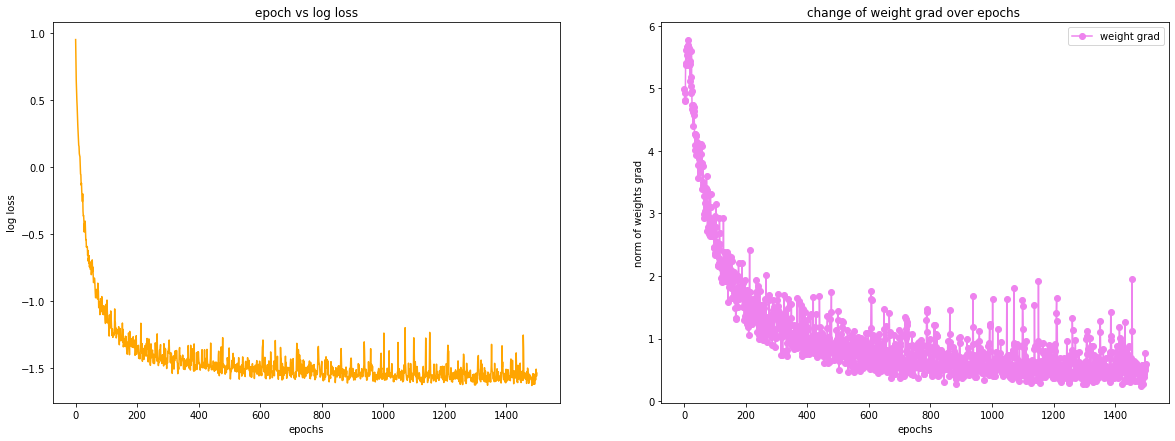

In [542]:
plot(losssia,parsia)

In [543]:
torch.save(modelSia,'D:/Saarland University/NNTI/project/models/modelSia.pt')

In [544]:
# we then extract the trained CNN layers from the previous model
cnn=modelSia.convlay()
for param in cnn.parameters():
    param.requires_grad = True
cnn.to('cuda')

Sequential(
  (0): Conv1d(13, 26, kernel_size=(3,), stride=(1,), padding=same, bias=False)
  (1): Dropout(p=0.2, inplace=False)
  (2): Conv1d(26, 26, kernel_size=(3,), stride=(1,), padding=same, bias=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv1d(26, 52, kernel_size=(3,), stride=(1,), padding=same, bias=False)
  (8): Dropout(p=0.2, inplace=False)
  (9): Conv1d(52, 52, kernel_size=(3,), stride=(1,), padding=same, bias=False)
  (10): Dropout(p=0.2, inplace=False)
  (11): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv1d(52, 104, kernel_size=(3,), stride=(1,), padding=same, bias=False)
  (15): Dropout(p=0.2, inplace=False)
  (16): Conv1d(104, 104, kernel_siz

In [545]:
dummy=np.zeros((1,melspectrogram.shape[0],maxlength+27))
datadict = {'TRAIN':dummy,'DEV':dummy,'TEST':dummy}
labeldict = {'TRAIN':[],'DEV':[],'TEST':[]}
for path,split,label in zip(sdr_df['file'],sdr_df['split'],sdr_df['label']):
        x, sr = librosa.load(path, sr=SAMPLING_RATE)
        melspectrogram = extract_melspectrogram(x, sr, num_mels=13)/max_val
        data = torch.tensor(np.concatenate((melspectrogram,np.zeros((melspectrogram.shape[0],maxlength-melspectrogram.shape[1]+27))),axis = 1))## the dimension is made to be 256 so that it works with the maxpooling layers in the architecture.
        data = data.view(1,melspectrogram.shape[0],-1) 
        datadict[split]=torch.tensor(np.concatenate((datadict[split],data),axis=0))
        labeldict[split].append(label)
train_data = datadict['TRAIN'][1:]
test_data = datadict['TEST'][1:]
val_data = datadict['DEV'][1:]
train_y = labeldict['TRAIN'] 
test_y = labeldict['TEST']
val_y = labeldict['DEV']

In [546]:
## same as the one for cnn architecture
custom_train_dataset = customDataset(train_data, train_y)
custom_train_loader = customDataLoader(custom_train_dataset, batch_size=32)
traindl = custom_train_loader.loader()

custom_test_dataset = customDataset(test_data, test_y)
custom_test_loader = customDataLoader(custom_test_dataset, batch_size=503)
testdl = custom_test_loader.loader()

custom_val_dataset = customDataset(val_data, val_y)
custom_val_loader = customDataLoader(custom_val_dataset, batch_size=32)
valdl = custom_val_loader.loader()

In [551]:
#creating the network for the downsample task
downmodel=downsample(cnn)
downmodel.to('cuda')


downsample(
  (conv_layers): Sequential(
    (0): Conv1d(13, 26, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (1): Dropout(p=0.2, inplace=False)
    (2): Conv1d(26, 26, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv1d(26, 52, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv1d(52, 52, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv1d(52, 104, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (15): Drop

In [552]:
lossdown=[]
pardown=[]

In [553]:
total_params = sum(p.numel() for p in downmodel.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 237786


The same hyperparameters are used that are obtained from the CNN based architecture in task 2

In [554]:
loss5,par5=downmodel.train(traindl,epochs = 100,learning_rate=0.001,lam=la,opti=optim) #100-0.01 #500-0.005 #500 - 0.001 #500 - 0.0001 #500 0.00005
lossdown+=loss5
pardown+=par5
print(test(downmodel,valdl))

epoch: 0 loss: 1.6290206909179688 grad: 0.5567023538995504
epoch: 1 loss: 1.5570411682128906 grad: 0.08987300841666486
epoch: 2 loss: 1.4683914184570312 grad: 0.11508636128723135
epoch: 3 loss: 1.4616585969924927 grad: 0.02141493692623239
epoch: 4 loss: 1.4624667167663574 grad: 0.04217420989926727
epoch: 5 loss: 1.4619059562683105 grad: 0.020649170101511787
epoch: 6 loss: 1.4630279541015625 grad: 0.04145168013504223
epoch: 7 loss: 1.4628103971481323 grad: 0.021264579339886257
epoch: 8 loss: 1.461591124534607 grad: 0.024334570534639614
epoch: 9 loss: 1.462347149848938 grad: 0.06738515776248596
epoch: 10 loss: 1.4614243507385254 grad: 0.01690831811324093
epoch: 11 loss: 1.46139395236969 grad: 0.017663857418671967
epoch: 12 loss: 1.4617739915847778 grad: 0.015056364516263092
epoch: 13 loss: 1.4611663818359375 grad: 0.0010203646813270726
epoch: 14 loss: 1.4635556936264038 grad: 0.015881893945867462
epoch: 15 loss: 1.4625413417816162 grad: 0.014439145118542102
epoch: 16 loss: 1.461798429489

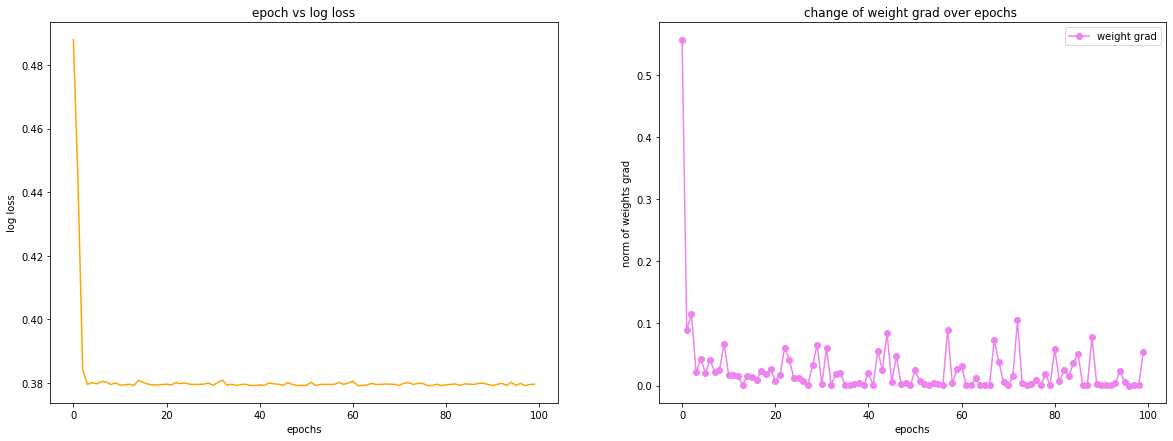

In [555]:
plot(lossdown,pardown)

T-SNE plot on the testing dataset: 


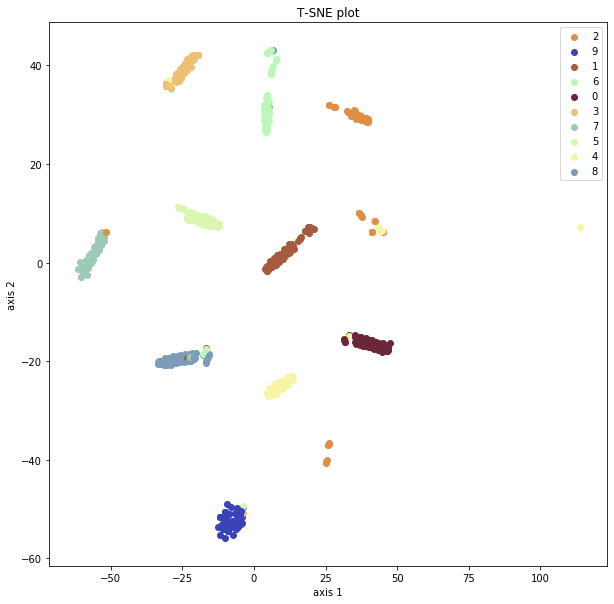

In [556]:
print("T-SNE plot on the testing dataset: ")
tsne_map(testdl,downmodel)

In [557]:
print("Training accuracy:")
get_accuracy(traindl,downmodel)
print("validation accuracy:")
get_accuracy(valdl,downmodel)

Training accuracy:
99.80000257492065 %
validation accuracy:
93.36015582084656 %


0.9336015582084656

In [558]:
print("Loss on test:")
test(downmodel,testdl)
print("Training accuracy:")
get_accuracy(traindl,downmodel)
print("Test accuracy:")
get_accuracy(testdl,downmodel)
print("Training f1 score:")
get_f1(traindl,downmodel)
print("Test f1 score:")
get_f1(testdl,downmodel)

Loss on test:
1.5068379640579224
Training accuracy:
99.9500036239624 %
Test accuracy:
94.43339705467224 %
Training f1 score:
F1 score: 0.031484375
Test f1 score:
F1 score: 0.0018813560307618402


0.9463220834732056

confusion matrix on the test dataset:


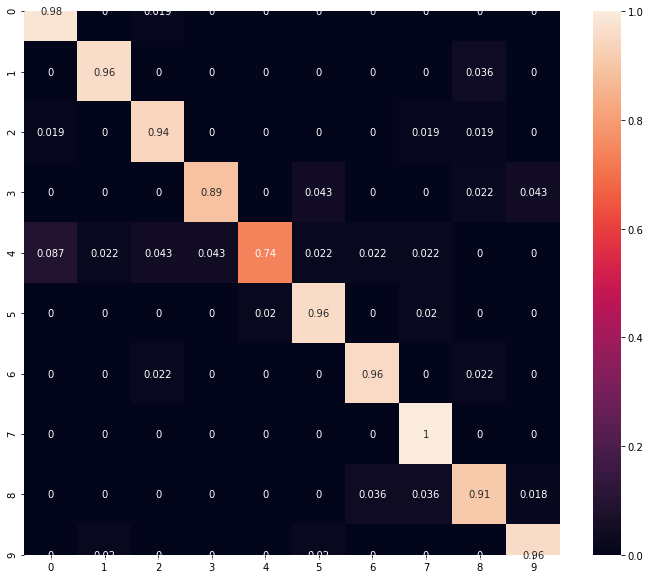

In [620]:
print("confusion matrix on the test dataset:")
confusionplot(testdl,downmodel)

In [621]:
print("\nThe Classification Report for test set classification\n")
classificationReport(testdl,downmodel)


The Classification Report for test set classification

              precision    recall  f1-score   support

           0       0.93      0.96      0.94        53
           1       0.98      0.98      0.98        55
           2       0.98      1.00      0.99        54
           3       0.98      0.91      0.94        46
           4       1.00      0.80      0.89        46
           5       0.98      1.00      0.99        50
           6       0.96      0.93      0.95        46
           7       0.90      1.00      0.95        47
           8       0.97      1.00      0.98        56
           9       0.94      0.98      0.96        50

    accuracy                           0.96       503
   macro avg       0.96      0.96      0.96       503
weighted avg       0.96      0.96      0.96       503



## References:
[1]Y. Sunaga, R. Natsuaki and A. Hirose, "Similar343
land-form discovery: Complex absolute-value max344
pooling in complex-valued convolutional neural net-345
works in interferometric synthetic aperture radar,"346
2020 International Joint Conference on Neural Net-347
works (IJCNN), Glasgow, UK, 2020, pp. 1-7, doi:348
10.1109/IJCNN48605.2020.9207122

[2]Zou, H., & Hastie, T. (2005). Regularization and Variable Selection via the Elastic Net. Journal of the Royal Statistical Society. Series B (Statistical Methodology), 67(2), 301-320. https://doi.org/10.2307/3647580

[3]Lei Huang, Jie Qin, Yi Zhou, Fan Zhu, Li Liu,360
and Ling Shao. Normalization Techniques in Train-361
ing DNNs: Methodology, Analysis and Application.362
arXiv preprint arXiv:2106.05345, 2021

[4] https://towardsdatascience.com/translational-invariance-vs-translational-equivariance-f9fbc8fca63a

[5] Sepp Hochreiter and Jürgen Schmidhuber. Long367
short-term memory. Neural Computation, 9(8):1735–368
1780, November 1997. ISSN 0899-7667.369
10.1162/neco.1997.9.8.1735. URL https://doi.370
org/10.1162/neco.1997.9.8.1735.3715

[6]Junyoung Chung, Çaglar Gülçehre, KyungHyun Cho,362
and Yoshua Bengio. Empirical Evaluation of Gated363
Recurrent Neural Networks on Sequence Modeling.364
CoRR, abs/1412.3555, 2014. http://arxiv.org/365
abs/1412.3555
[7]https://gist.github.com/dimartinot/80abaabaea9a6ef3d9ab0ab199927ee4#file-contrastive_loss-py

[8]Mohsenzadeh, Y. (2020). CLAR: Contrastive350
Learning of Auditory Representations. ArXiv.351
/abs/2010.09542

[9]Gregory Koch, Richard Zemel, Ruslan Salakhutdi-378
nov. Siamese Neural Networks for One-shot Image379
Recognition

[10]van der Maaten, Laurens and Hinton, Geoffrey. Visu-372
alizing Data using t-SNE. Journal of Machine Learn-373
ing Research 2008